In [1]:
import tensorflow as tf
from RNN_MODELS import RNN
from EDNN import EDNN
from metrics import *
from comparisons import *
import numpy as np
from matplotlib import pyplot as plt
import time

In [182]:
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']

def errplt(in_,out,errs,seed,title="Ising Model Phase Transition",style = "error",ylabel="|M|",errc=None,**kwargs):
    """Plots phase transitions"""
    if style=="error":
        plt.errorbar(in_, out, errs, linestyle='None', marker='.',**kwargs)
    elif style == "dot":
        plt.plot(in_,out,"o",**kwargs)
    elif style=="scatter":
        plt.scatter(in_,out,**kwargs)
    else:
        plt.plot(in_,out,**kwargs)
    if errc != None:
        tonp = np.asarray
        plt.fill_between(in_,tonp(out)-tonp(errs),tonp(out)+tonp(errs),color=errc)
    plt.ylabel(ylabel,fontname='Times New Roman',fontsize=20)#
    plt.xlabel(r'$\beta^{-1}$',fontname='Times New Roman',fontsize=24)
    plt.title(title,fontname='Times New Roman')
    if ylabel=="|M|":
        plt.ylim(0,1.1)
    elif ylabel!="default":
        plt.ylim(-1.5,-10/64)
    plt.xlim(min(in_),max(in_))
    if not kwargs["label"]  in ["EDNN","Reference"]:
        plt.text(3.6, 0.6 if ylabel=="|M|" else out[15], '$\\beta_o$', fontsize=20)
        plt.plot([4,4],[-10,1.2],"k--")
def out(a):
 for i in range(len(a[0])):
   print("%f\t%f\t%f"%(a[0][i],a[1][i],a[2][i]))

import matplotlib
def deltaplt(x,y,e,s,c,delta=False,points=False,lims=None,**kwargs):
 """plots the energy reference vs network graphs"""
 tonp=np.asarray
 #kwargs = dict()
 if delta:
     ref=[0]*len(x)
     if points:
         y = tonp(y)-tonp(x)
     plt.ylabel(r"$E^{%s}(\sigma$)-E($\sigma$) - ($\overline{E^{%s}(\sigma)}-\overline{E(\sigma)}$ ) [J]"%(s,s),fontsize=16)
 else:
     ref=x
     plt.ylabel(r"$E^{%s}(\sigma$) - $\overline{E^{%s}(\sigma)}$ [J]"%(s,s),fontsize=16)
     kwargs["linewidth"] = 0.5
     #plt.axis('equal')
     plt.gca().set_aspect('equal', adjustable='box')
 if type(c)==str:
     c=list(matplotlib.colors.to_rgba(c, alpha=None)[:3])
 if points:
   plt.plot(x,y,"b.",color=c+[1.0] if len(c)==2 else c,fillstyle="full",ms=1.5,mew=0.1,alpha=0.3,**kwargs)
   if not delta:
       if lims==None:
            max_,min_ = x[-1]+10,x[0]-10
       else:
            min_,max_ = lims
       plt.plot([min_,max_],[min_,max_],"k--",**kwargs)
       plt.xlim(min_,max_)
       plt.ylim(min_,max_)
 else:
   #print(e)
   c2=max(0.6-np.sum(e)/len(e)/6,0.3)
   #print(c2,np.sum(e)/len(e))
   plt.plot(x, y,color=c+[1],label=s,**kwargs)
   plt.fill_between(x,tonp(y)-tonp(e),tonp(y)+tonp(e),color=c+[c2],lw=0)
   plt.plot(x,ref,"k--",**kwargs)
   plt.xlim(min(x),max(x))
 plt.xlabel(r"$E(\sigma$) - $\overline{E(\sigma)}$ [J]",fontsize=16)

def bins(N):
    return [a for a in range(-N*N*2,N*N*2+1,4) if abs(a)!=N*N*2-4]

In [3]:
#older
ISINGEDNN8 = [[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [1.0, 1.0, 0.99998671875, 0.99989515625, 0.999608125, 0.99911765625, 0.99835546875, 0.9964290625, 0.99358875, 0.992604375, 0.9829325, 0.9825515625, 0.96554296875, 0.95846578125, 0.94456265625, 0.919136875, 0.8838171875, 0.82299484375, 0.77623890625, 0.68346390625, 0.60000546875, 0.5707115625, 0.48712359375, 0.4135465625, 0.41720796875, 0.34589890625, 0.3234203125, 0.31249515625, 0.2937415625, 0.26804546875, 0.25723921875, 0.24589515625, 0.23190765625, 0.225143125, 0.21601890625, 0.21458140625, 0.20536515625, 0.19573078125, 0.19922125, 0.1835159375, 0.19006453125, 0.18407171875, 0.17899296875, 0.171180625, 0.17142046875], [0.0, 0.0, 0.0006440983394625684, 0.0018070348573245448, 0.0036567505533430912, 0.005265210923537245, 0.007477545120577569, 0.011799611317585584, 0.01658869904294788, 0.016951275659500525, 0.027818455373636402, 0.027597399912556865, 0.04443309477741814, 0.055018919694861765, 0.06570275705883154, 0.08888525529571469, 0.1073303593244467, 0.1825986993723547, 0.21250531076538112, 0.2519499035374963, 0.2634730939947289, 0.26012302138975246, 0.2592777376335991, 0.24652449885368105, 0.24512015961041747, 0.22463041776380427, 0.21940819437586498, 0.20619377779160938, 0.19694298411293712, 0.18974608013021052, 0.17823248117192939, 0.1764920790537796, 0.16970331449089124, 0.1651770682941018, 0.15208183290704455, 0.1527131283942542, 0.15568231644313554, 0.14609357734540265, 0.14690373719399552, 0.13836544505988874, 0.13566243843785677, 0.13631502824976194, 0.13437583048208118, 0.12581634320850127, 0.12838619885950658], 42]
ISINGEDNN16= [[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [0.077390703125, 1.0, 0.99999546875, 0.9999233203125, 0.9996907421875, 0.9993054296875, 0.9984109765625, 0.99751625, 0.9953323046875, 0.9921395703125, 0.986123671875, 0.9816348046875, 0.9719670703125, 0.9618756640625, 0.942557578125, 0.9097476171875, 0.887508828125, 0.789787265625, 0.752942890625, 0.567271640625, 0.3635918359375, 0.2919508984375, 0.260913828125, 0.19654640625, 0.1783946484375, 0.166167578125, 0.1583415625, 0.130907890625, 0.142700625, 0.1429311328125, 0.1297581640625, 0.12096234375, 0.1225626171875, 0.1083751953125, 0.098362265625, 0.1059653125, 0.09855546875, 0.099050078125, 0.093404921875, 0.0994539453125, 0.0871409765625, 0.09015015625, 0.0890649609375, 0.088510078125, 0.084867890625], [0.061918168672937195, 0.0, 0.00018809534390419518, 0.0007701819811698092, 0.001585148891351051, 0.002483476903498884, 0.0036979251630028195, 0.004478047539455672, 0.00688998975678279, 0.008454508904215691, 0.012540291828124316, 0.015267657843823713, 0.018847513541841533, 0.02618680147204627, 0.03839196528228379, 0.04987622875685168, 0.05612907070595601, 0.207942466074659, 0.1460684626017526, 0.208037258040129, 0.22457141249023616, 0.1854425999458622, 0.1609458043251725, 0.1370227345906589, 0.12416056265781544, 0.11383095255836816, 0.11895134708665754, 0.0952039008730681, 0.10165849253789927, 0.10737282710251356, 0.09840601839965818, 0.09601711155264506, 0.08925291129861947, 0.07859549629931777, 0.0744344822143823, 0.07732688031239625, 0.0734807851117532, 0.06822868752053747, 0.0709246439217257, 0.07288114625909761, 0.06768747706834964, 0.06892788678138524, 0.06504386145056901, 0.06744410848639891, 0.06503051776260442], 42]
#OLD
POTTSEDNN8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.,3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [1.0, 0.9999451421769262, 0.9995057284461998, 0.9983124417974689, 0.9962511159827242, 0.9918996998502057, 0.9858448999870628, 0.966113410632147, 0.9382855807534762, 0.9010105979127243, 0.7987917443574236, 0.6493929741457131, 0.4708481915793801, 0.387925712748612, 0.31307594287950724, 0.2826673689168367, 0.26161888461480687, 0.23376858975695436, 0.23421694135989055, 0.21561803159977147, 0.20823331686420246, 0.20429558068071546, 0.1904098342047918, 0.18676064720006275, 0.1792725222119932, 0.1797268921246753, 0.17170776705697116, 0.17219661362442187, 0.16650778218820117, 0.16429399503317582, 0.16007940488326047, 0.158054110962782, 0.15709820751289122, 0.15244107213496344, 0.1524287857848406, 0.15189429863908124, 0.1510637019735187, 0.15179925395330193, 0.1445745149993908, 0.14526926211146932, 0.1456102247381591, 0.14356096847997327, 0.14221461264840518, 0.14237086718195058, 0.1414985923640095], [0.0, 0.0011303000369226894, 0.0033869470992515974, 0.006290726498173558, 0.010786820881949632, 0.015820999986975157, 0.020277202879284, 0.04466625493505773, 0.06796060838389122, 0.08339912423739305, 0.17241009354838072, 0.23082612756215748, 0.21447584810876513, 0.19411462673459068, 0.15746344639023946, 0.15021393713303677, 0.13075718541297482, 0.11656997863775768, 0.12057729106366565, 0.10897520546468922, 0.10621744218854275, 0.1040317277675325, 0.09754036033136443, 0.09744201106655659, 0.09445043284244599, 0.09165888356650685, 0.08770858151498877, 0.08915357096194158, 0.085777313912798, 0.08474485081117056, 0.08332705940741454, 0.07977236785867785, 0.08112522343807255, 0.07895800929241441, 0.07797722856267349, 0.07748147913728137, 0.07942611627201666, 0.07848191393962804, 0.07399924212684325, 0.07612990466319214, 0.07649336068605267, 0.07413535965885888, 0.07365660661007231, 0.07322353501575248, 0.07335311920624185], 42]
ISINGRNN8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [1.0, 1.0, 0.999997, 0.999881, 0.999739, 0.999374, 0.998399, 0.997534, 0.994823, 0.992532, 0.986412, 0.98214, 0.970809, 0.96044, 0.941048, 0.912384, 0.898422, 0.829396, 0.745182, 0.665077, 0.637154, 0.546753, 0.484268, 0.432283, 0.377626, 0.342036, 0.321249, 0.304535, 0.282262, 0.26425, 0.257043, 0.234345, 0.230677, 0.225207, 0.209744, 0.20488, 0.204477, 0.199225, 0.19567, 0.186506, 0.187856, 0.183205, 0.179707, 0.181759, 0.1725], [0.0, 0.0, 0.000288, 0.001921, 0.003014, 0.004396, 0.007474, 0.010065, 0.014817, 0.017213, 0.024218, 0.028134, 0.043104, 0.047177, 0.071512, 0.110986, 0.099585, 0.179203, 0.245034, 0.255862, 0.242783, 0.267695, 0.255067, 0.255614, 0.237362, 0.215386, 0.2159, 0.20899, 0.194748, 0.182019, 0.181173, 0.166912, 0.168053, 0.163075, 0.150607, 0.152, 0.15025, 0.147518, 0.145252, 0.138808, 0.143115, 0.134207, 0.132449, 0.131259, 0.128397], 42]
SPINSRNN420_8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [-77.041037, -79.517756, -78.33445, -77.003578, -73.853827, -73.108504, -70.626501, -67.776758, -65.082127, -63.301004, -60.968198, -58.524317, -56.419904, -54.644988, -52.425556, -50.542594, -48.575742, -47.766093, -45.93728, -44.046916, -43.074303, -41.705133, -40.065686, -39.180005, -38.060725, -36.773293, -35.646702, -34.696021, -33.577352, -32.631268, -32.00566, -31.794534, -30.293125, -29.866886, -28.737255, -28.43137, -27.772762, -27.518104, -26.487563, -26.366854, -25.577775, -24.75855, -24.210722, -23.953811, -23.858283], [1.304537, 1.815045, 2.461074, 3.05379, 3.918852, 4.356332, 5.285965, 5.663386, 6.401137, 6.61443, 7.056904, 7.498197, 7.731747, 8.013701, 8.151139, 8.403692, 8.65937, 8.836432, 8.882284, 9.086026, 9.253841, 9.210163, 9.343783, 9.581207, 9.798672, 9.841284, 9.847002, 9.676807, 9.941899, 10.001084, 9.88654, 10.095146, 10.249649, 10.233461, 10.175446, 10.380775, 10.286123, 10.184549, 10.289641, 10.42439, 10.290813, 10.385798, 10.382638, 10.46146, 10.344264], 420]
#dropout

ISINGRNN8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [1.0, 1.0, 0.99995484375, 0.99988140625, 0.99967890625, 0.99928890625, 0.9982509375, 0.99595125, 0.99281125, 0.99156265625, 0.9810978125, 0.978535, 0.95989265625, 0.952223125, 0.9208265625, 0.90245046875, 0.85002953125, 0.74124828125, 0.72151296875, 0.62698015625, 0.5512065625, 0.49235796875, 0.4339753125, 0.38560328125, 0.3447421875, 0.3192153125, 0.28953578125, 0.28456421875, 0.274505, 0.2457884375, 0.24248078125, 0.22963140625, 0.22538296875, 0.219865, 0.2160078125, 0.1987959375, 0.1903853125, 0.194759375, 0.18125078125, 0.19121828125, 0.1814534375, 0.173109375, 0.1710590625, 0.1713659375, 0.1731721875], [0.0, 0.0, 0.0011870525369948612, 0.0019214552323593012, 0.0033041499082533976, 0.0047523852949030694, 0.00783542630436237, 0.013528189838721958, 0.017879304507935984, 0.01808205310540913, 0.03124878564984316, 0.03450325315278257, 0.05336617682466897, 0.06135782203280502, 0.11066169235019223, 0.10766440048870737, 0.15201670378437948, 0.2306870982559133, 0.23165253771597027, 0.26404456277239086, 0.264978565001131, 0.266566937871497, 0.25500323300627453, 0.24255334689671032, 0.22614334489205037, 0.21424848737774638, 0.19574774785425922, 0.19327117581105993, 0.1862269099949038, 0.176233673465611, 0.1761318016279347, 0.16498836452219884, 0.16136161596976534, 0.1539343944368022, 0.15738810489984575, 0.14635296001574788, 0.14034640866407072, 0.14241577386822138, 0.13358768260847312, 0.13810491076255543, 0.13431896222493528, 0.1315290179707861, 0.12631715520514658, 0.1258756619113524, 0.12973702713890065], 42]
ISINGEDNN8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [1.0, 1.0, 0.99998671875, 0.99989515625, 0.99973375, 0.9990071875, 0.9983615625, 0.995981875, 0.99469640625, 0.9922565625, 0.9812925, 0.9817415625, 0.9700703125, 0.9569378125, 0.941719375, 0.914865625, 0.89501625, 0.81355203125, 0.72948078125, 0.6560878125, 0.5698015625, 0.5152215625, 0.42908453125, 0.41873546875, 0.356224375, 0.33815046875, 0.31266703125, 0.2854528125, 0.27397046875, 0.251683125, 0.2366946875, 0.23831546875, 0.230999375, 0.21673328125, 0.20595125, 0.21009609375, 0.19866515625, 0.1923003125, 0.1866940625, 0.19095890625, 0.18496921875, 0.17119171875, 0.1787078125, 0.17239890625, 0.1738321875], [0.0, 0.0, 0.0006440983394625684, 0.0018070348573245448, 0.0030390379337053366, 0.005824640136080833, 0.007466140698754194, 0.013596701676670524, 0.014782334089969046, 0.01737061871188225, 0.029171337709299517, 0.02841497334256349, 0.042857127031595846, 0.055466448542924075, 0.06681977567669899, 0.09207174676704236, 0.10248715682495296, 0.18857662688363985, 0.23873088057806247, 0.2590848020102971, 0.2694137292298939, 0.265246961376438, 0.24683869432998193, 0.2431525867699237, 0.23755948130070367, 0.2168258403753293, 0.21086148267049398, 0.19818150919255773, 0.1931919170752694, 0.18286120905685377, 0.16717120220533604, 0.1729637958046576, 0.16430619305958732, 0.1564632926505316, 0.15112540259975324, 0.15097973511179805, 0.14440104753117472, 0.14281685567721808, 0.13743718336387753, 0.14090109643067442, 0.1371459448373416, 0.1291044193491586, 0.1302485311273791, 0.12573960465378925, 0.12756159466200961], 42]
SPINSRNN69_8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [-89.82822109447129, -90.58518592637702, -90.51421976281132, -88.13607539310422, -86.46302415162282, -83.98961136655203, -83.28884223653755, -81.93824798271112, -78.01911425731686, -77.51768885700406, -74.28382419982741, -71.55355529987095, -68.99981124974913, -66.83707273090195, -65.0700739136633, -63.11675808417798, -60.90232558132973, -59.654945442277814, -57.152538679893304, -55.13247403278335, -53.96271988426913, -52.250656311357574, -50.474316635459985, -49.2830479766162, -47.28916821457682, -46.563415287036804, -45.56317209301749, -44.21391260186474, -42.88473383526609, -41.69144223778824, -41.119356356119255, -39.738722542452805, -38.77447389557646, -37.95956578624527, -36.795941885508704, -36.426875694103806, -35.301875791809486, -34.62717849995221, -33.6698232425594, -33.60317962911746, -33.080294921270436, -31.78341900484523, -31.60871347949434, -31.083288698302432, -30.17048492479984], [1.382103612995903, 2.0064273290338415, 2.1524415218133255, 2.973780187580479, 3.581757590912085, 4.32361525802376, 4.8805573321861955, 5.670134574946629, 6.254146238586643, 6.876282866337714, 7.578156975601154, 7.846819938938861, 8.02383868722393, 8.6522346399711, 8.68156002535631, 9.399738474789096, 9.676451672913617, 9.5670580120614, 9.685306654926887, 9.947524189794677, 9.985644457521435, 10.22953398056602, 10.580409574861983, 10.404035936144924, 10.809789280141842, 10.985506399312094, 10.921306736732788, 11.131050038508956, 11.01011286523577, 11.04518816740331, 11.233290556983555, 11.06364448708657, 11.44173304891637, 11.348721386033631, 11.671153771905727, 11.701581028447098, 11.725960820243554, 11.80027401003955, 11.633707892241675, 11.723906542937051, 11.774705483269443, 11.764216137681922, 11.97748774193658, 11.86357797279213, 11.934010213646433], 42]

#OLD
ISINGEDNN16=[[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [0.9999998219807943, 0.9999922335589374, 0.9999772290830259, 0.999890699033384, 0.9997228791978624, 0.9989345126681858, 0.9978987771493417, 0.9971406413890698, 0.9929840017248083, 0.9916856652719003, 0.9822211103086118, 0.9799756000660084, 0.9708133330168548, 0.9433153830634223, 0.9393868114330151, 0.9143499996044018, 0.8722767512003581, 0.8043864299632885, 0.7174196808426468, 0.5446163671988028, 0.425534580371998, 0.3151458810876917, 0.2647211922539605, 0.21658283516212745, 0.18875080249927662, 0.16356783972846137, 0.15417456167715568, 0.14179202609592015, 0.13645409478081597, 0.1295772538361726, 0.1219060558742947, 0.11902309417724609, 0.11576538368507668, 0.10907412776240596, 0.10618276807996962, 0.10315059661865235, 0.10064372027361834, 0.09603419268572772, 0.09393297407362196, 0.0922875835277416, 0.09144025590684679, 0.08944342154043693, 0.08750155837447555, 0.08566241794162327, 0.08485911616572628], [0.00041861393186181804, 0.0004717190679213444, 0.0005697585651746838, 0.0010198624566926506, 0.0015691879717092787, 0.003064348652397792, 0.0043320190767232175, 0.005182645172866817, 0.008584662443183514, 0.00949486948681719, 0.01487167284771989, 0.01597439148903749, 0.02090767777986961, 0.03685466917834695, 0.03743639331727871, 0.051748821361570385, 0.09931101144636595, 0.13658263035417587, 0.16373561800771916, 0.2323331429885407, 0.22508762064290347, 0.2002990739365964, 0.17702233034186418, 0.15265108193033788, 0.13484753040603706, 0.12113849214105213, 0.11378158282939771, 0.10634898265930365, 0.1022046380709406, 0.09684310676727248, 0.09124635187981098, 0.08797554962011808, 0.08609132001054395, 0.08149686752817234, 0.07935325343641197, 0.07710620543962274, 0.07556857562232332, 0.07216683058707586, 0.07098024269812515, 0.06951297401683788, 0.06859214008693869, 0.06702940595972932, 0.06540626031232376, 0.06455274531918541, 0.06427560695191518], 42]
ISINGEDNN8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [0.9999998738606771, 0.9999933227539063, 0.9999754516601562, 0.9999066528320313, 0.9997348592122396, 0.9989773030598958, 0.9984767456054687, 0.9960038899739583, 0.9948595662434896, 0.9914977945963541, 0.9823111328125, 0.9798494466145833, 0.9708388834635416, 0.9583271443684895, 0.9356214029947917, 0.9103956176757813, 0.8642089518229167, 0.8150229370117188, 0.7438523396809896, 0.6617344970703125, 0.5890184936523437, 0.5158249267578126, 0.45914210611979167, 0.4063448811848958, 0.3660214233398438, 0.33859042561848957, 0.3130147908528646, 0.29169183349609373, 0.274335595703125, 0.2579819051106771, 0.2453189737955729, 0.23645230305989584, 0.2258466512044271, 0.218400244140625, 0.21214130045572915, 0.20677628173828125, 0.1998197265625, 0.1945814168294271, 0.19021087646484375, 0.18670841471354166, 0.18324093017578125, 0.17873629150390624, 0.176897265625, 0.17281585693359375, 0.1713452880859375], [0.0003495675230401017, 0.0005118838896986707, 0.0009303014645174496, 0.0017667046761350711, 0.0029791002490652924, 0.0059218096881251975, 0.007340956458681128, 0.012559578358756445, 0.014239883056012067, 0.018840932096591087, 0.029362577267140894, 0.03300635965273656, 0.04224768830206667, 0.05368078624052588, 0.0796661466570217, 0.10457947194683272, 0.14921726884089814, 0.1849133788563452, 0.22475039420307227, 0.25264142838980724, 0.26330634560783933, 0.26392087578577744, 0.25654527473138744, 0.24594399926689164, 0.2332194059561054, 0.22229350456941555, 0.21074499585406029, 0.2005657444777384, 0.1912700005435926, 0.18338732674879363, 0.17517005867173352, 0.1703064307129634, 0.16293611526312743, 0.158882842449583, 0.15452991966008156, 0.15044013575569665, 0.14640291729111055, 0.1430709737600054, 0.14043047222597752, 0.13752347810917007, 0.13539432569916743, 0.13247815744175376, 0.13088577113538177, 0.12826125746398082, 0.12714459985317725], 42]
#OLD
ISINGRNN8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [0.9999998681640625, 0.999991826171875, 0.9999709423828125, 0.9998774853515625, 0.9997308203125, 0.9991852587890625, 0.998265390625, 0.9958574072265625, 0.9931685986328125, 0.9906752001953125, 0.9827019677734375, 0.9785313037109376, 0.96726705078125, 0.95160744140625, 0.9231393798828125, 0.8911321923828125, 0.8458639697265625, 0.786403134765625, 0.71219921875, 0.64044302734375, 0.552401650390625, 0.48592548828125, 0.438633828125, 0.384849208984375, 0.3581540673828125, 0.32487998046875, 0.30208537109375, 0.2836062646484375, 0.2668083740234375, 0.2526660546875, 0.242201474609375, 0.2323855419921875, 0.2224342724609375, 0.2146822509765625, 0.208575224609375, 0.2034010546875, 0.1979817138671875, 0.1941708251953125, 0.1897034716796875, 0.18341541015625, 0.1811821337890625, 0.1779906298828125, 0.1753087646484375, 0.172733330078125, 0.1704355078125], [6.418610181465036e-05, 0.0005074461034521627, 0.0009524737224683705, 0.001986151683665574, 0.0029745302791827247, 0.005258060611848439, 0.007979055373419811, 0.013133403766664184, 0.016840247883228788, 0.02028586401335955, 0.030072950630978285, 0.034058509554239114, 0.04724868260185363, 0.06392237576799449, 0.09813003433421298, 0.12821128723456382, 0.16627632647496401, 0.20247332078408115, 0.236024216751045, 0.257290880040219, 0.26474415177881616, 0.2631252972176836, 0.2517738421345576, 0.24015498798334478, 0.22925543462795916, 0.2175506699735872, 0.20473197687545305, 0.19548782658975833, 0.1872209937935218, 0.17857883266675825, 0.17312070488741713, 0.16739275751873428, 0.1605753364597384, 0.1563057192250572, 0.15220137359905078, 0.14871376048791832, 0.1448590860908906, 0.14242913898148968, 0.13919624197053218, 0.13552716139183837, 0.13361273349183383, 0.1321937247309638, 0.130095286856191, 0.1281292633168154, 0.12665722007607147], 0]
POTTSEDNN8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [0.9999826709097458, 0.9998574304808956, 0.9993804896019705, 0.9982148314917355, 0.995474890888922, 0.9903798903177552, 0.983013684711353, 0.9671046142035518, 0.940005419422532, 0.8873213187893736, 0.7813133340238247, 0.6204857789159444, 0.4778080818806474, 0.3805634152692312, 0.32342261257883476, 0.2839149598738088, 0.2580217803103825, 0.24113392874357628, 0.22641066481876188, 0.214902358037599, 0.2068268562448758, 0.19788275073305336, 0.19067494807977894, 0.1859688307577571, 0.18081113158608259, 0.17549139497776803, 0.17269147628771472, 0.16897559608429608, 0.16655950774056752, 0.1636949068064741, 0.1612570897152526, 0.15915768078929518, 0.15725566451221518, 0.15482441600021968, 0.15348077181668626, 0.1517453334256183, 0.14993094096810747, 0.1488224016207415, 0.14748024766634898, 0.14614742147490864, 0.14569783057878613, 0.14433981593314915, 0.14361141883118475, 0.14277959806470564, 0.1414347917002489], [0.0006357874890464112, 0.0018564549964750594, 0.003938155101999392, 0.006741413840496326, 0.011343736637834402, 0.017426045986940714, 0.024646756344582264, 0.038307029872340886, 0.06313266078857892, 0.11014237100298895, 0.1792963284468121, 0.22954796333564897, 0.21528761069224683, 0.18623227251191402, 0.16447599755824105, 0.14400272527396984, 0.13162160670237497, 0.1235048031319593, 0.11578302118749298, 0.11048502887450225, 0.10596333136182365, 0.10219108350662388, 0.09798496094026121, 0.09585609207854355, 0.09366435411147815, 0.09091264951913978, 0.08926178607602941, 0.08709484251207109, 0.08604921276555841, 0.08461691583626603, 0.08317038702885726, 0.08224063852698395, 0.0811027185182508, 0.0800636853096904, 0.07946253475113454, 0.07856933831616841, 0.07768916696008536, 0.07692274691452299, 0.07625869763082133, 0.0756714944337141, 0.07534153132563613, 0.07473843679797702, 0.07438932263333076, 0.07391671748938804, 0.07323328313825078], 0]
SPINSRNN420_8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4., 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [-79.91204890527695, -78.90323144092623, -76.9328391871195, -75.26180561517384, -73.63730568506207, -71.80552425489556, -69.61867084862884, -67.47809197886575, -65.10625350966815, -63.00666759626888, -60.71654437079701, -58.67687682387126, -56.45222175390524, -54.503195048111984, -52.73767029982463, -51.08044008481909, -49.08290139539252, -47.241165275504144, -45.81680171683927, -44.496848113380814, -42.919065284315366, -41.57360621554236, -40.208050656696614, -39.11692409643297, -38.04200465531837, -36.8210820918271, -35.96271504080258, -34.771363470526474, -33.91532104258016, -33.12948960801198, -32.17660015219711, -31.353897386967166, -30.709126521049985, -29.778556885422116, -29.113992655095533, -28.62359315429606, -27.872194618935254, -27.24621896583606, -26.614811801582775, -26.078408340886465, -25.608145646886246, -25.050066190087996, -24.51387662581229, -24.10104763218177, -23.603906822353675], [1.5158290449116885, 2.0842313926003384, 2.8029752549635063, 3.478264073421546, 3.984926480108932, 4.568272376499551, 5.164632170323168, 5.752190524675309, 6.15843630626166, 6.6566841229189295, 7.032824969159121, 7.42576723664713, 7.625995589403777, 7.923360519077515, 8.236617280008097, 8.406330841324278, 8.699083393875489, 8.812802905469795, 8.965014788065327, 9.090883070944233, 9.249852640897242, 9.357514240697364, 9.445984009138487, 9.567034818871152, 9.703397428540775, 9.713946538679615, 9.686609437356841, 9.844807906029356, 9.980563320570415, 9.975698687515148, 10.048893947141599, 10.050906248909207, 10.051396734376539, 10.164746204722057, 10.173186914042686, 10.200943745454769, 10.229642018078437, 10.260440613815167, 10.233573690796218, 10.333892172995721, 10.281328870038646, 10.351815570531835, 10.32107892818026, 10.434969305241703, 10.421500964602656],0]


#COOKING
SPINALLRNN=[[ 2. ,  2.4,  2.8,  3.2,  3.6,  4. ,  4.4,  4.8,  5.2,  5.6,  6. , 6.4,  6.8,  7.2,  7.6,  8. ,  8.4,  8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8, 13.2, 13.6, 14. , 14.4, 14.8,15.2, 15.6, 16. , 16.4, 16.8, 17.2, 17.6, 18. , 18.4, 18.8, 19.2,19.6], [-363.1096524991639, -360.24681470630935, -356.38085674861367, -352.1911331633868, -345.9146867343685, -339.38510640848097, -331.41566511669737, -321.99761685227975, -312.3838163972275, -301.2544997539637, -290.22876716098375, -279.016998845149, -268.06172660608405, -256.62487171259124, -246.1553597043574, -236.4693806089843, -227.23342276814063, -217.1127472780624, -208.55590263072324, -201.44059405537033, -193.13422768480305, -186.277206405041, -179.55228354162702, -173.09795364478245, -167.9385700562416, -161.45269384264682, -156.7403046940384, -152.2872371100203, -147.5777400993808, -142.94167748459577, -138.70682826183133, -134.7253671039569, -131.52965159118597, -127.87327669612931, -124.78387195318554, -121.58175550899566, -118.37893604619381, -115.90981458207816, -112.88390079835972, -110.28692792134714, -107.70088602850736, -105.8359288566875, -103.15243672929223, -101.610076553709, -99.23329210363384], [6.52247342566793, 7.888745236838074, 10.060180323933698, 12.210253023638103, 15.09179314106108, 18.16924654117049, 21.349809055825986, 24.6728631528019, 27.510584850984298, 30.36554922693505, 32.70408141800491, 35.04556910320397, 36.923763748052274, 38.66011909542869, 39.738117327023076, 40.87533683403646, 41.69070582330708, 42.5673182551444, 43.06339254004311, 43.523546461822406, 43.91233218895097, 44.16366657003827, 44.42837276353121, 44.69175163835567, 44.85528758421242, 44.797746780043006, 45.07021697971754, 44.98759453150695, 44.9730533239747, 44.842474207624505, 45.012287086912174, 45.1260532781582, 45.14264003313257, 44.99663968279304, 45.314155904096296, 44.997227531845844, 45.06404209173919, 45.215787688340825, 45.220871416795795, 45.06605216542462, 44.979278064455826, 45.11908641328255, 45.19512578377968, 45.05483502086092, 45.11937760705574], 0]


In [4]:
#REFERENCE
SPINS69_8 = [[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,4.9], [-91.0276797784104, -91.19076023614313, -89.77286108565134, -88.51744185098224, -87.11916587986579, -85.47780763392444, -84.00307551634535, -81.75276059416996, -79.60630559201891, -77.33566879619784, -75.25477356336279, -72.80084606239603, -70.45548467589201, -68.43324360789768, -66.15491552384213, -64.13699607109052, -62.12849153224462, -60.27275251947869, -58.50152605145023, -56.51924649530956, -55.111311519153105, -53.48571325910151, -51.81682422167346, -50.303890936807285, -49.07357498889081, -47.52331945428429, -46.60881322178617, -45.44363214421366, -44.150037964327076, -42.983909566307666, -41.842122804289275, -40.97817014240182, -40.05811227100685, -39.10981017446208, -38.2115311111829, -37.36743630294217, -36.50773754812155, -35.84009875065826, -35.05424913773233, -34.30708716260294, -33.59589715566749, -32.98722799832872, -32.42318885405753, -31.874143115790105,-31.20305662486101], [1.2022202164588245, 1.7157410907016104, 2.345690302757188, 2.8827464408452053, 3.5051480261611507, 4.201693574226728, 4.81735532595225, 5.427282085951418, 6.0288861118507615, 6.579436741441273, 7.137520637505861, 7.594990902459965, 7.937755538323698, 8.404973711284752, 8.656327589729269, 8.975009301984644, 9.346847008538074, 9.451925362907483, 9.689291522965945, 9.887035760573212, 10.099280976109613, 10.201253424772485, 10.389167321185658, 10.494675185239462, 10.698028265253646, 10.8039237048211, 10.866904079930245, 10.941924657565393, 11.086468202329856, 11.080880605426808, 11.245029235655231, 11.222838816716916, 11.337537106308428, 11.371846247306253, 11.453854177829406, 11.481822140011129, 11.490890591273791, 11.58639937958904, 11.678004801171044, 11.61822889287542, 11.69167144089222, 11.721023680428283, 11.747571330381035, 11.808672698323853,11.845391382785616],69]
SPINS420_8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,4.9], [-79.50531031489012, -78.73017244816415, -77.58476878821938, -76.1647704463588, -74.08310367783744, -71.89021211209457, -69.89948005957247, -67.64072520491577, -65.21521222904985, -62.673654086983255, -60.47667739283129, -58.33211211213755, -56.176683576830804, -54.19942872952724, -52.28483901855591, -50.3213106566569, -48.58117867054214, -47.044698504757086, -45.3304119378984, -43.80388564444336, -42.51710830685347, -41.10248535841407, -39.938779331522326, -38.73725142594593, -37.58314631532123, -36.33739912751698, -35.56465208300328, -34.5212911243103, -33.64637237414438, -32.713282341007314, -31.73981560232095, -31.012635162520333, -30.28110073971363, -29.67079021713522, -28.93333140663997, -28.197055485452733, -27.500306695779898, -26.913486335236662, -26.35827734443655, -25.845830639980573, -25.34521187078745, -24.7242064677168, -24.310297235174012, -23.814139602377374,-23.301807665008695], [1.4113501868410308, 1.9594998987858492, 2.5873300743501617, 3.2507139624130588, 3.9655380396039135, 4.767737075272843, 5.271313574770021, 5.8194005788578105, 6.294579943388687, 6.779935994582685, 7.086260265390555, 7.416960766868994, 7.702424440792119, 8.087612670126521, 8.259981713060586, 8.430196583380047, 8.76537332721635, 8.828599886200214, 8.99422059621652, 9.11882683514688, 9.227498023461008, 9.319870847375277, 9.464957667624248, 9.513074031093385, 9.61264893360472, 9.751287226910614, 9.792804126976028, 9.815456017989977, 9.905296026890465, 9.933764947791715, 10.023183212553809, 10.02102283684471, 10.034476676582027, 10.098783491934169, 10.151553275168105, 10.218710591338631, 10.256933718727861, 10.217241948938804, 10.28889007282112, 10.311814956535484, 10.35424246322349, 10.33485932905629, 10.34730831598441, 10.37819383691534,10.375587360863845]]
ISING4 = [[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [1.0, 0.9999962109375, 0.9999769140625, 0.99991203125, 0.999733125, 0.9993387890625, 0.9984941015625, 0.997076484375, 0.994807734375, 0.9914228125, 0.986165859375, 0.9786649609375, 0.9690792578125, 0.9568109765625, 0.9396874609375, 0.919458828125, 0.892951328125, 0.8644919140625, 0.833549609375, 0.8010804296875, 0.7642126171875, 0.7288621875, 0.6939108984375, 0.65937546875, 0.6307210546875, 0.601427578125, 0.5746302734375, 0.551267109375, 0.528771875, 0.5068499609375, 0.4894924609375, 0.4706171484375, 0.45625859375, 0.4432348046875, 0.429143515625, 0.4185016796875, 0.4077173828125, 0.3982158984375, 0.390182734375, 0.380796953125, 0.373760546875, 0.3659166796875, 0.36113828125, 0.3540901953125, 0.3481033984375], [0.0, 0.0006881994300385379, 0.0016985903646817707, 0.0033485765071181338, 0.00586444100996634, 0.009328913141874052, 0.01449652586254497, 0.020843256406818517, 0.029750645783821965, 0.038433005569299995, 0.052328060619210096, 0.07020308636209735, 0.0872034958861264, 0.10740382804142773, 0.13139043890832355, 0.156275699462126, 0.1829984519396232, 0.20690404123256653, 0.2292937310896983, 0.24693394006824568, 0.2648512601239496, 0.27815615961670687, 0.28695458453272543, 0.29418776722119644, 0.2963323972340016, 0.2995604936643798, 0.2998764312920515, 0.297860525213911, 0.2961316211104183, 0.2924526151989708, 0.29053333033735135, 0.2855772193809734, 0.2820110881373239, 0.2784926865616425, 0.27422277103345266, 0.27148485181093174, 0.2671268345064996, 0.2641949401401874, 0.26110412383405257, 0.2571279715860695, 0.25391744568796565, 0.25086963615947644, 0.24839091784080167, 0.24569773054404287, 0.24242862104328908]]
POTTS8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,4.9], [0.9999825271997571, 0.9998513573106026, 0.9993811134933429, 0.9980715118204095, 0.9954979022664567, 0.9900676101862805, 0.9814146348224643, 0.9650368673178649, 0.9380130314426713, 0.8884142766848854, 0.7698679950369329, 0.6100709020129413, 0.4694649135804719, 0.3751745374140487, 0.31977063611107404, 0.280580239270738, 0.25764500593336376, 0.2394301851201111, 0.22520801850450994, 0.21718197595830385, 0.20418015408481796, 0.19637712541188596, 0.19162744257133332, 0.18522660526359827, 0.18030842868505073, 0.17575698583736638, 0.17243416241165724, 0.16990404650911647, 0.16434936171257952, 0.16400401360473674, 0.16094147933467895, 0.1591470253681701, 0.15736589789954553, 0.1554199192273421, 0.15389028593681156, 0.15201607495618993, 0.15030117605946058, 0.14841502156529435, 0.14768507633756495, 0.14688555645445525, 0.14550531459230673, 0.14510623400031386, 0.14364720771168682, 0.14246326714013902,0.14196986209878903], [0.000500255319857731, 0.0018853928446654973, 0.003937139644524075, 0.007104578476353757, 0.011286403488052658, 0.01835749574599908, 0.026219038427198478, 0.04061050557805138, 0.06270176080183928, 0.1043785064040706, 0.18318243907239018, 0.22376050208569528, 0.21685011211651956, 0.18410778924292143, 0.1628891014188834, 0.14452081287956725, 0.13070330681014752, 0.12295262149065403, 0.11419543001704646, 0.11087130046828511, 0.10362756846731828, 0.10149054001468294, 0.09777985161093697, 0.09563979227161402, 0.09272579366290956, 0.09076034329837204, 0.08911049984562422, 0.08797427985537827, 0.08552655150249105, 0.08418429306507245, 0.08284854865637895, 0.08243274712202674, 0.08089940454949045, 0.08033142375065008, 0.07940546227844075, 0.07872050802175164, 0.0780025610128178, 0.07670764225264574, 0.07637463795717767, 0.07568802504281316, 0.0752072072692696, 0.07499898912058026, 0.07442119621047673, 0.07348776836217755,0.07322789268916656]]
ISING16=[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [0.9999997142537435, 0.9999964437357585, 0.9999776445007325, 0.9999089097595215, 0.9997162092081706, 0.9992787986246745, 0.9984519580586751, 0.9970302946980795, 0.9947626978556315, 0.9913831587219238, 0.9864624495951335, 0.9796565197245279, 0.9701171364339193, 0.956760568745931, 0.9383404780069987, 0.9108919972229004, 0.8686839646911622, 0.7925524396769206, 0.6714157237243652, 0.511621440633138, 0.38724012537638347, 0.3026942188008626, 0.2513343541463216, 0.21314597864786783, 0.1908123779296875, 0.17229470352172851, 0.15817012624104818, 0.14722746332804362, 0.13784840179443358, 0.1304747116088867, 0.1237093342590332, 0.11879746175130208, 0.11386859751383463, 0.11068461619059244, 0.10651813751220703, 0.10306322179158528, 0.10060291208902995, 0.09803637690226237, 0.09565570276896158, 0.0936995241800944, 0.09192630101521809, 0.09029023193359376, 0.08859001922607422, 0.08688847508748372, 0.08557256810506185], [9.214552989418714e-05, 0.00018349369947553407, 0.0004271420500978366, 0.0008605657082559596, 0.001529968019077015, 0.0024656617701560163, 0.0036902020218233388, 0.00523846584598308, 0.0072002841049420676, 0.009601474119882837, 0.012626227976310949, 0.016351691136516123, 0.021464863700669412, 0.028377039219782015, 0.038350980006755644, 0.055722079702646324, 0.08751369425885602, 0.1464357301910911, 0.2078811703953934, 0.24061327694017068, 0.22478262123378445, 0.19771941109758714, 0.17332940632839436, 0.15164196909279531, 0.1380584655420377, 0.1253774884345232, 0.11645510930308078, 0.10869559626172041, 0.10220626800257801, 0.09697816096198289, 0.09211514471791303, 0.08867463816613302, 0.08493210004412685, 0.08268197820136264, 0.0797146832391953, 0.07722729249992831, 0.07547601403548963, 0.07354218759274975, 0.071873670386133, 0.07040199508946184, 0.06900097366982419, 0.06795971096069497, 0.06659872371697347, 0.06543166969934297, 0.0643787814650441]]
ISING8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [1.0, 0.9999955834960937, 0.9999760961914063, 0.9999190991210938, 0.999716748046875, 0.99929037109375, 0.9984061303710937, 0.997057236328125, 0.9948086401367188, 0.9914399047851562, 0.986697578125, 0.9798696948242187, 0.9699675610351562, 0.9565781225585938, 0.9377525366210937, 0.9127593676757813, 0.874243466796875, 0.8229821508789062, 0.7537591015625, 0.6825475537109374, 0.6018397924804687, 0.5285233520507813, 0.470170234375, 0.4230984228515625, 0.381371787109375, 0.3463024560546875, 0.3198459716796875, 0.2965433154296875, 0.28086677734375, 0.2637618994140625, 0.2525071997070312, 0.23947348876953126, 0.2302043603515625, 0.2223485693359375, 0.214862587890625, 0.20938228515625, 0.20404956787109374, 0.197478466796875, 0.19363718017578124, 0.1890551513671875, 0.1847216650390625, 0.1810279052734375, 0.1773815625, 0.174518935546875, 0.17216953125], [0.0, 0.00037147845370028704, 0.0009035820207852138, 0.0016019724609261023, 0.0030646813852601815, 0.0048879002053005315, 0.00755374825415203, 0.010419915500703706, 0.014433245176994972, 0.018961502232415012, 0.024762360732109096, 0.0322057804760863, 0.0428532041684586, 0.0576481875165303, 0.07919655132475466, 0.1019292942611675, 0.13947624550999832, 0.17754825226666404, 0.21880785301422953, 0.2454103652132955, 0.2621007013038232, 0.2648401416046941, 0.2589588178372908, 0.24879048350581964, 0.237279634092988, 0.22493211598249885, 0.2137472527284459, 0.20303937273015893, 0.19477978857449316, 0.18586466597727325, 0.17896684940194535, 0.17141376094075658, 0.1655424742536269, 0.16102780661754254, 0.15622220171391107, 0.15267839589765017, 0.14925479246792156, 0.14503496070130056, 0.14222270623748662, 0.13920550995921266, 0.1363595626640923, 0.13415198650598792, 0.1314820523678918, 0.12943249162883236, 0.1278231721911135]]
REFSPINALL=[[2.0, 2.4, 2.8, 3.2, 3.6, 4.0, 4.4, 4.8, 5.2, 5.6, 6.0, 6.4, 6.8, 7.2, 7.6, 8.0, 8.4, 8.8, 9.2, 9.6, 10.0, 10.4, 10.8, 11.2, 11.6, 12.0, 12.4, 12.8, 13.2, 13.6, 14.0, 14.4, 14.8, 15.2, 15.6, 16.0, 16.4, 16.8, 17.2, 17.6, 18.0, 18.4, 18.8, 19.2, 19.6], [-367.81834783584355, -364.50881352244437, -360.7376448834323, -356.41006806054105, -351.0510290449766, -344.9073589680047, -337.4614499799433, -329.58091200586114, -320.1274683446132, -309.90672389271214, -299.5504220092644, -289.1526327770458, -278.46370634180494, -267.69312809905983, -256.75551646337385, -246.33014379003868, -236.63199619941773, -227.16410298840577, -218.56752960056517, -209.29596213212585, -202.0049958928874, -194.67324217336707, -187.544890951381, -181.10511855154894, -175.0982692790109, -168.9320790981206, -164.02318819174565, -159.32371204480324, -153.98690609686477, -149.26129368910287, -144.96263869866152, -141.17897874688268, -137.36169606498797, -133.59808423598236, -130.32642723037011, -127.05418316400608, -123.8356411943314, -120.6656701306252, -118.15778766579135, -115.28932872945506, -112.78662335150453, -110.60517630027239, -107.92743327686514, -105.8604216355109, -103.54861310263502], [5.580648893134682, 7.196450108092302, 8.900055830403591, 11.119170311235045, 13.611038040800699, 16.31962127583245, 19.33439941800753, 22.307378507320077, 25.315553588505885, 28.306089003302542, 30.97896001258256, 33.30749768183349, 35.399762228506866, 37.057536703835254, 38.721559746690595, 40.31380589440966, 41.18864577273918, 42.22457815218095, 42.83343681126009, 43.3982429280829, 43.89245127091844, 44.21705763630112, 44.27970894893088, 44.62510634221646, 44.846368626780034, 44.82951436865456, 45.0117142469037, 44.92877179171215, 44.93740249804258, 44.98566638969602, 45.2653309594352, 45.1199809316447, 45.10534287808714, 45.099845383511855, 45.058042708948385, 44.99897123925754, 44.89880295947889, 45.003483981567285, 45.13117922277174, 45.19970877891364, 45.0927449754256, 45.01874769389441, 45.06119181820609, 45.12525469870302, 45.136706716905444]]

#Cooked long ago
POTTSEDNN8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [0.9999826709097458, 0.9998574304808956, 0.9993804896019705, 0.9982148314917355, 0.995474890888922, 0.9903798903177552, 0.983013684711353, 0.9671046142035518, 0.940005419422532, 0.8873213187893736, 0.7813133340238247, 0.6204857789159444, 0.4778080818806474, 0.3805634152692312, 0.32342261257883476, 0.2839149598738088, 0.2580217803103825, 0.24113392874357628, 0.22641066481876188, 0.214902358037599, 0.2068268562448758, 0.19788275073305336, 0.19067494807977894, 0.1859688307577571, 0.18081113158608259, 0.17549139497776803, 0.17269147628771472, 0.16897559608429608, 0.16655950774056752, 0.1636949068064741, 0.1612570897152526, 0.15915768078929518, 0.15725566451221518, 0.15482441600021968, 0.15348077181668626, 0.1517453334256183, 0.14993094096810747, 0.1488224016207415, 0.14748024766634898, 0.14614742147490864, 0.14569783057878613, 0.14433981593314915, 0.14361141883118475, 0.14277959806470564, 0.1414347917002489], [0.0006357874890464112, 0.0018564549964750594, 0.003938155101999392, 0.006741413840496326, 0.011343736637834402, 0.017426045986940714, 0.024646756344582264, 0.038307029872340886, 0.06313266078857892, 0.11014237100298895, 0.1792963284468121, 0.22954796333564897, 0.21528761069224683, 0.18623227251191402, 0.16447599755824105, 0.14400272527396984, 0.13162160670237497, 0.1235048031319593, 0.11578302118749298, 0.11048502887450225, 0.10596333136182365, 0.10219108350662388, 0.09798496094026121, 0.09585609207854355, 0.09366435411147815, 0.09091264951913978, 0.08926178607602941, 0.08709484251207109, 0.08604921276555841, 0.08461691583626603, 0.08317038702885726, 0.08224063852698395, 0.0811027185182508, 0.0800636853096904, 0.07946253475113454, 0.07856933831616841, 0.07768916696008536, 0.07692274691452299, 0.07625869763082133, 0.0756714944337141, 0.07534153132563613, 0.07473843679797702, 0.07438932263333076, 0.07391671748938804, 0.07323328313825078], 0]
#DONE
ISINGRNN8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [0.9999995561080947, 0.9999928582724563, 0.9999660324049772, 0.9998662800295833, 0.999581163326653, 0.9991125170493949, 0.9981781147243957, 0.9957103223373351, 0.9941828261733503, 0.9902871075088044, 0.9825360890037598, 0.9777770301761268, 0.966904277729079, 0.952006875747514, 0.9293539472919989, 0.9038951485100541, 0.8637870981180246, 0.8092602006754417, 0.7356956573324945, 0.6608462590052844, 0.5821745863953326, 0.5166354853975741, 0.4599614433518171, 0.413111493651675, 0.3724551282496439, 0.3350057043069115, 0.3133801192771088, 0.29414193287817775, 0.27269103904165437, 0.2602174052344049, 0.24881840413718304, 0.23765351163083598, 0.22712847944176787, 0.21938229935849135, 0.21221052033285343, 0.2075875735597937, 0.1993969294438354, 0.196319199986048, 0.1900457398056377, 0.18725472012950753, 0.18284483160674508, 0.18003683553130193, 0.1770736252529592, 0.17327281067777442, 0.17073691540817065], [0.00011777701389389269, 0.0004746428018413597, 0.0010297249860776346, 0.0020788888524203575, 0.003751015217436293, 0.005518224756485169, 0.008114043734899367, 0.0130519961950716, 0.01534634802583058, 0.02073557403607765, 0.029060342422915827, 0.034410985204538724, 0.046123464986245186, 0.05960727726291186, 0.08453697121251319, 0.10803490330852797, 0.14346473165751084, 0.18112778394062293, 0.2209498641894595, 0.24921737874938807, 0.2598400699606853, 0.2589249464158061, 0.25621761897226825, 0.2460941937981823, 0.23306503447320298, 0.21945853172842508, 0.21007883016919973, 0.20059265353155328, 0.1890355414249795, 0.1818845554592358, 0.1758456572332297, 0.16985187259883427, 0.16408109621320446, 0.15929630630942554, 0.1541405825685724, 0.1512787091383125, 0.14580227053495692, 0.14378974213566223, 0.13991898591539667, 0.13739064585997984, 0.13544549108157064, 0.1330064176598927, 0.13134483334528665, 0.12835313177664692, 0.12663888244789517], 0]
ISINGEDNN8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [1.0, 0.9999930062364248, 0.9999647993719067, 0.9998612048654656, 0.9995710425912113, 0.9989482869086846, 0.99780310004637, 0.9958653935083985, 0.9928638605622283, 0.9886564163410934, 0.9822417097564048, 0.974026197829483, 0.9625760998418246, 0.9482016370496726, 0.9260588735609616, 0.8960239438055733, 0.8510586900856407, 0.7908711104415687, 0.7272611587322731, 0.6449698534264983, 0.5712988500082544, 0.5056881541782973, 0.45437226227201316, 0.4021893853568859, 0.3627055061693478, 0.33725391816479855, 0.3096375877090948, 0.2928124223682379, 0.2734611964295466, 0.25768796119382537, 0.24807217252298847, 0.23674798694034502, 0.22725431786479866, 0.21870516198542866, 0.21302217174963012, 0.20522522522877992, 0.20025189977844074, 0.19517859014249048, 0.19098800888162598, 0.18718323380421914, 0.18207218349205068, 0.17925915664168035, 0.1768407694236839, 0.1740209066379714, 0.17153211816378847], [0.0, 0.0004674464664494595, 0.001078663422894493, 0.0021145420837200965, 0.0037515972210597592, 0.00594988069913965, 0.008849378615513787, 0.01267158495104659, 0.017164487253172118, 0.022117297883104108, 0.02939454996596989, 0.037382861038931854, 0.0504368540521787, 0.06091774980673219, 0.08338143362788183, 0.11450357829067971, 0.15179442881768782, 0.19643160375842247, 0.22354408396278413, 0.251979353829106, 0.26109012258841846, 0.25868470041675024, 0.2518745550452038, 0.24211636909965592, 0.23018179623204393, 0.2209492116610524, 0.20798061482097385, 0.19999489365732573, 0.19051438062911114, 0.1820573611785993, 0.17550129787920982, 0.16932889403631476, 0.16329793545138985, 0.15847706698007052, 0.1543092628525032, 0.14961912055054513, 0.14706085488501383, 0.1435016028830454, 0.1400520052417461, 0.1376232207787166, 0.13493185150857973, 0.13242771299968428, 0.13053190221014463, 0.12896134626920752, 0.12730395176144008], 0]
POTTSRNN8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [0.9999948272370353, 0.9999040699483295, 0.9992072524997985, 0.9988532735324036, 0.9971616413910347, 0.9886523451748064, 0.982132826062525, 0.9789095566587115, 0.9276379610124925, 0.9305492838278393, 0.8551706353472989, 0.7175084571516042, 0.5685538139228787, 0.416495600481025, 0.33965940954718554, 0.2981869902503095, 0.2671325281043768, 0.24693672845028977, 0.23191429373642444, 0.21745892431547872, 0.20699456774812544, 0.20014286504825773, 0.1919420227835861, 0.18665200642091676, 0.18215988771281078, 0.17794626216868656, 0.17418962932766607, 0.17072760683988614, 0.1667270609139745, 0.1648877844051489, 0.16213516669429195, 0.16039677278894918, 0.15776861715341456, 0.15569545570073512, 0.15408586279205938, 0.15241535993903266, 0.15110227460962516, 0.14973264817047474, 0.14821530651357337, 0.14623477906120083, 0.14581523202777646, 0.14483241177472025, 0.1437475362326923, 0.14266561630905544, 0.14129580078690285], [0.00034745496291864583, 0.0015168453762539307, 0.004492826004001042, 0.005322042477085058, 0.008764766663530621, 0.019412897880305285, 0.024570959481530874, 0.027706016951134383, 0.07355175412598593, 0.07605631890243884, 0.1480936992039281, 0.2185718480482185, 0.23104906788586266, 0.2070224893526109, 0.17415928980588288, 0.15198489589233163, 0.1376035076867595, 0.1270050405665733, 0.11921288950568615, 0.11186265385907591, 0.10678326105859126, 0.10299862101150985, 0.09934335626273855, 0.09666655614309584, 0.09428273894967672, 0.09185126927992204, 0.09003397854695168, 0.0880737259056579, 0.08635427993313281, 0.08486174473275339, 0.08406219564570845, 0.08296104072701857, 0.08145264087781412, 0.08066215718519731, 0.07976822388010328, 0.07848810408583823, 0.0782641115930519, 0.07739436890906563, 0.07666313376554146, 0.07570690534218535, 0.07543007284123468, 0.07481409239701144, 0.07436984356360413, 0.0740652201733329, 0.07319461739260182], 0]
SPINSRNN420_8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [-79.60921801936894, -78.9178427394922, -77.09375029767791, -75.16712639514479, -73.74515412860596, -71.94332302647446, -69.52546205319716, -67.46632622695266, -65.1143488936665, -62.96235253619655, -60.73629185646943, -58.67579985210308, -56.378627351318926, -54.43107674515317, -52.631162069586004, -50.79353787996208, -49.13475436560375, -47.314351410847706, -45.76694425260092, -44.363827818619924, -42.86861213229573, -41.504839103892316, -40.35305974160784, -39.094342016874165, -38.07270717740824, -36.85686656597392, -35.95637007241464, -34.92631267275827, -33.889824175370244, -33.07543869134915, -32.18672575530677, -31.37469097872819, -30.663360787760062, -29.90616140778138, -29.156059986504026, -28.60246087593021, -27.92471457889335, -27.242313222759567, -26.70647124494303, -26.100417809179838, -25.55901014559352, -25.068532789276492, -24.52889155024871, -24.089865272076903, -23.572828209822188], [1.4915609120410653, 2.1171406444354, 2.6765165931052084, 3.4215987652450988, 3.961603129060158, 4.564930180744073, 5.201564633265932, 5.704562747511329, 6.166226064027679, 6.641565443476617, 6.977165880541536, 7.309999340307546, 7.639422869866629, 7.954967394357841, 8.228757966907446, 8.402519687157548, 8.633754035762683, 8.790233326079042, 8.970660310637179, 9.077323906978645, 9.252894174983583, 9.368032054815602, 9.45347610967024, 9.55095859486554, 9.609498291732395, 9.722725164372699, 9.766334221808718, 9.822750370427844, 9.922239955999911, 9.98937004021196, 9.994985369978355, 10.061726555510601, 10.071953001755698, 10.116005795433233, 10.209978610021833, 10.22021616560753, 10.234623626149038, 10.272871418255162, 10.303247515499415, 10.332438750682913, 10.324854124639703, 10.348429421059473, 10.367348523788035, 10.379957367514235, 10.434774191723434], 0]
SPINSRNN69_8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9] , [-91.02715295699383, -91.44056696095616, -90.54972822133772, -89.26542063304076, -87.03709918842871, -85.12342952548373, -83.38672000965133, -81.19618388975498, -78.50164737965086, -76.46603220090589, -74.07725163394953, -71.6723493485109, -69.37337165131697, -66.9947613657993, -64.95625829787707, -62.78551676505972, -61.03242791292903, -58.971243608728386, -57.185537027838166, -55.45043568339652, -53.76418721375348, -52.097835239570934, -50.754054138450975, -49.17959079784586, -47.90668278009374, -46.47432455568658, -45.43424181888499, -44.109880728048225, -43.06090313845487, -41.95394890823169, -40.88512607562029, -39.829046984181694, -38.93322966955563, -38.10840741592133, -37.242370122563294, -36.42480205041409, -35.58761709168032, -34.84879184876335, -34.10497142399677, -33.333303994801014, -32.73875928101322, -32.03618830039257, -31.372242900254133, -30.902872394146417, -30.24454014650758], [1.3983979333921903, 1.6920616220412477, 2.254644662924147, 2.8650713057948303, 3.71154965010436, 4.508719313341079, 5.05798174745127, 5.803419621197056, 6.372926288264719, 6.868101761480208, 7.429469704017145, 7.824688519253963, 8.231669182496729, 8.580748966565839, 8.892681541517312, 9.176122411675257, 9.512956987298418, 9.698614863208032, 9.901269632626198, 10.027015405488664, 10.226481046720673, 10.39395309351894, 10.517121462423496, 10.616993466645182, 10.755583000705368, 10.888068191806456, 10.974751251427703, 11.06323980244997, 11.14849438529377, 11.168953387006487, 11.283772524805132, 11.362258186035634, 11.425475496098963, 11.489776184866887, 11.557884128494326, 11.591873302641904, 11.642077261425475, 11.699693512482424, 11.68513700949021, 11.752108362763401, 11.804330486353251, 11.794899743856554, 11.838725449220089, 11.891366389575586, 11.901597869491349], 0]
ISINGEDNN16=[[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [0.999996881435993, 0.9999604848445576, 0.9997906449273088, 0.9991630358935405, 0.9979168134336038, 0.9959064665909597, 0.9981906014156775, 0.9915294000552223, 0.9932374190798761, 0.9895557634363636, 0.9802021882488094, 0.9750808648771506, 0.9603524010549404, 0.9450927118599897, 0.9162364973263185, 0.8970945455879105, 0.8530871060949836, 0.7889701177432649, 0.6718606523052554, 0.5423978188517063, 0.4066629610472516, 0.3168415793297145, 0.25942901909044874, 0.2203138514999261, 0.1977085941986767, 0.17368199381135432, 0.1635965990804444, 0.15013077924947635, 0.136883201596557, 0.13261810976665686, 0.1237433864734413, 0.11746794055722073, 0.113435056253528, 0.10900060522304848, 0.10538511402628516, 0.10616423924591095, 0.10345860895667561, 0.09709253375349236, 0.09502032556283313, 0.09646716501281727, 0.0907337757255035, 0.0892952216181757, 0.08905610172777274, 0.08573402787904999, 0.08787584002622731], [0.0005060383404154674, 0.000721284129429521, 0.0013474893145048452, 0.002513778430821775, 0.0037220261062427882, 0.004785444461739072, 0.003911209358227633, 0.006417498817771661, 0.009915811033623512, 0.012037573311468477, 0.015001385271019966, 0.019593440794679604, 0.023732185174530313, 0.031916405324981474, 0.050236523975569734, 0.05627358582084326, 0.08763985542052062, 0.12252549979950392, 0.18729093288259083, 0.22380326265297665, 0.22058308623560602, 0.19974096509187209, 0.17501438165404767, 0.15378863689839833, 0.1418240153980301, 0.12684634368003608, 0.1165761161885449, 0.11083536236595977, 0.10332967367837967, 0.09814987685064111, 0.09325976839533588, 0.08875449720197093, 0.08635847537636065, 0.08267595494145522, 0.07991823449980522, 0.07713302558192241, 0.07410630259354233, 0.07413479949954871, 0.07278589243421771, 0.07043662389792874, 0.0696775710629646, 0.06856698518247656, 0.06737659550683522, 0.06583626336747456, 0.0650314248382645], 42]
SPINALLRNN=[[ 2. ,  2.4,  2.8,  3.2,  3.6,  4. ,  4.4,  4.8,  5.2,  5.6,  6. , 6.4,  6.8,  7.2,  7.6,  8. ,  8.4,  8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8, 13.2, 13.6, 14. , 14.4, 14.8,15.2, 15.6, 16. , 16.4, 16.8, 17.2, 17.6, 18. , 18.4, 18.8, 19.2,19.6], [-363.1096524991639, -360.24681470630935, -356.38085674861367, -352.1911331633868, -345.9146867343685, -339.38510640848097, -331.41566511669737, -321.99761685227975, -312.3838163972275, -301.2544997539637, -290.22876716098375, -279.016998845149, -268.06172660608405, -256.62487171259124, -246.1553597043574, -236.4693806089843, -227.23342276814063, -217.1127472780624, -208.55590263072324, -201.44059405537033, -193.13422768480305, -186.277206405041, -179.55228354162702, -173.09795364478245, -167.9385700562416, -161.45269384264682, -156.7403046940384, -152.2872371100203, -147.5777400993808, -142.94167748459577, -138.70682826183133, -134.7253671039569, -131.52965159118597, -127.87327669612931, -124.78387195318554, -121.58175550899566, -118.37893604619381, -115.90981458207816, -112.88390079835972, -110.28692792134714, -107.70088602850736, -105.8359288566875, -103.15243672929223, -101.610076553709, -99.23329210363384], [6.52247342566793, 7.888745236838074, 10.060180323933698, 12.210253023638103, 15.09179314106108, 18.16924654117049, 21.349809055825986, 24.6728631528019, 27.510584850984298, 30.36554922693505, 32.70408141800491, 35.04556910320397, 36.923763748052274, 38.66011909542869, 39.738117327023076, 40.87533683403646, 41.69070582330708, 42.5673182551444, 43.06339254004311, 43.523546461822406, 43.91233218895097, 44.16366657003827, 44.42837276353121, 44.69175163835567, 44.85528758421242, 44.797746780043006, 45.07021697971754, 44.98759453150695, 44.9730533239747, 44.842474207624505, 45.012287086912174, 45.1260532781582, 45.14264003313257, 44.99663968279304, 45.314155904096296, 44.997227531845844, 45.06404209173919, 45.215787688340825, 45.220871416795795, 45.06605216542462, 44.979278064455826, 45.11908641328255, 45.19512578377968, 45.05483502086092, 45.11937760705574], 0]
SMALLISINGRNN8=[[0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,4.4, 4.5, 4.6, 4.7, 4.8, 4.9],[0.9999989445236918, 0.9999926461907682, 0.9999852282638169, 0.9999276406872978, 0.9998181769434417, 0.9994579882550542, 0.9991394760844456, 0.9978625815616851, 0.9972762496760575, 0.9937597380019766, 0.9930173337224325, 0.9892348962721287, 0.9839509549949637, 0.9773266031955167, 0.9686301935747496, 0.9570125806462814, 0.9377688160057399, 0.9135540242885024, 0.8841426738817317, 0.8338997673532932, 0.7760031927467826, 0.7045913623843553, 0.6394620180044135, 0.5609106203722789, 0.49147421256337986, 0.4368404062214627, 0.39941703380144133, 0.35621448470186723, 0.32789588765912636, 0.30405544971418885, 0.28289074285330085, 0.27015605128439035, 0.25421659332651725, 0.24538542305542202, 0.235243454784263, 0.2277570698367835, 0.21899889019132254, 0.21132380186275193, 0.2056812797723233, 0.19909064896128506, 0.19481656176876208, 0.1908905696762722, 0.18853801655996952, 0.1833645155888524, 0.17972039978838392], [0.00018161090441505496, 0.0004793250045449687, 0.0006792632417067806, 0.001509264386649819, 0.002449681986533526, 0.004242000679895222, 0.005407737618506892, 0.008895055973984779, 0.009766067205779888, 0.015904957954558867, 0.01650698246576274, 0.02124870959823103, 0.027833596730207705, 0.03352593408455706, 0.04236903973831831, 0.05300167647829391, 0.07588217902560268, 0.10024660400097375, 0.12706286615095608, 0.17178861054403963, 0.20824281751198442, 0.23869921862049956, 0.25532332972974703, 0.26593469135812187, 0.2616432251695006, 0.25379020553959764, 0.24259244456694687, 0.22980506740921416, 0.2178723150712257, 0.20802789688170192, 0.19764563914850655, 0.1891855678162981, 0.1803227069214776, 0.17515971997406823, 0.16827176259759208, 0.16386541647507566, 0.15926583148047155, 0.15494475306347066, 0.15096079090976236, 0.14600353064073682, 0.1431999767720986, 0.1403043197346526, 0.13928560566501727, 0.13609225351240153, 0.13340428611977714], 0]



2.9 2.9
0.19590650869448328
0.1876815963745117


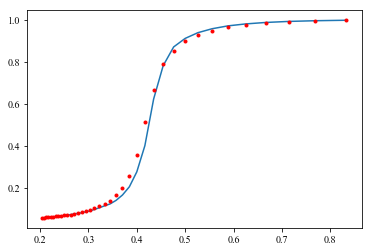

In [5]:
#NEWEST
EDNNISING24=[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [0.9999994937849853, 0.9999943487475929, 0.9999577113793914, 0.9998474467779369, 0.9995544510646216, 0.9989410194385648, 0.9977955977278146, 0.9959199943900466, 0.9928951830521477, 0.9884439256197178, 0.9827863564509683, 0.9735606028788318, 0.962950225252932, 0.9482051007180946, 0.9273782012434711, 0.8982111275853581, 0.8518577337819754, 0.7899936944628027, 0.6632776960925479, 0.5118898656888562, 0.35817662019632723, 0.25546738408224123, 0.20161460140802753, 0.16514549326022646, 0.13978480898889234, 0.12459471678432461, 0.11339709583297714, 0.10247341421435797, 0.09333971883411715, 0.09040649745052819, 0.08485730546529827, 0.0816464740496322, 0.0782603110925791, 0.07343655626842688, 0.07234887351157474, 0.07020296145314114, 0.06811135576170813, 0.06601814567460787, 0.06403915285565018, 0.06286323753004852, 0.06179800922944598, 0.06003124980574243, 0.0592488882463349, 0.057767387840439374, 0.05734549085595381], [4.192176963766774e-05, 0.0001399659513510047, 0.0003895192363257206, 0.0007334689699366676, 0.001274146301574573, 0.001989428090293109, 0.0029479709941970626, 0.0040677503815690725, 0.005679938706534564, 0.007609418432858184, 0.009443239788872118, 0.012611649211456289, 0.01576384005553975, 0.020156575934848278, 0.027348461106245624, 0.03769884694104299, 0.06008935695300224, 0.08099506913744192, 0.15140258121847847, 0.18549494870043362, 0.18151141123098744, 0.15799789227978595, 0.1334590748561307, 0.1157830375417892, 0.10155887419782021, 0.09125132735365664, 0.08289867289065758, 0.07651842884300396, 0.07020017284148096, 0.06712314762048668, 0.0639561342471567, 0.06107187588100166, 0.05830609613169129, 0.05538879205488476, 0.054446520392100684, 0.05288852606166687, 0.05118911944202472, 0.04972876133200018, 0.04797229465851158, 0.04742369636481767, 0.04659645338651331, 0.04525406117847056, 0.044619654162613584, 0.04368444403668393, 0.043349472052562864]]

REF24=[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [0.9999995753158757, 0.9999965981565876, 0.9999747246636284, 0.9999049635898919, 0.9997164800950039, 0.9992637204017168, 0.9984459713782794, 0.9970597279489777, 0.9947963357807676, 0.9914852944456501, 0.9865186556592399, 0.9795911104178724, 0.970238239203559, 0.9565951364776234, 0.9379425969630112, 0.9107339991440008, 0.8701876030815971, 0.7813284396701389, 0.6224956642433449, 0.4006757068021798, 0.2763136575581115, 0.20527255753882137, 0.1661735078788098, 0.1407049317913291, 0.12389496166087961, 0.11466861240716628, 0.10568153844762732, 0.09764093062789353, 0.09056479688102817, 0.08658742072964892, 0.08161130129967206, 0.07883175365306713, 0.07611430754484955, 0.07306320755570023, 0.07033284068166473, 0.06914145628375772, 0.06690692018108603, 0.06527423291618442, 0.06406459478684413, 0.062376619164737655, 0.061554111659674, 0.05996420868296683, 0.05877784936222029, 0.05788682906539352, 0.057264540231963736], [0.00019443935183516379, 0.00023079425046662098, 0.000349390228950343, 0.0006174763321685191, 0.001037457201748017, 0.0016637892124057507, 0.002468679608569377, 0.0034938261127893536, 0.004814917752850321, 0.006360917538529562, 0.008477029806452976, 0.011025527643757485, 0.014186651767498072, 0.0194064028855335, 0.02617313995827732, 0.037502623729847674, 0.05697032796316221, 0.1262065376451174, 0.19771712322693508, 0.2190130377340654, 0.18116540280674806, 0.1415067828419, 0.1204291681732062, 0.10330168225841482, 0.09190337612254879, 0.08530580521569302, 0.07930287317247536, 0.07315092317246603, 0.06836457147920708, 0.0653258175662132, 0.061189391510774564, 0.05908050682455095, 0.05721055059167045, 0.05503978366492666, 0.052539138806008766, 0.05199886418704181, 0.050545118179654354, 0.049182894431590865, 0.04826182349184646, 0.04754134644778364, 0.04651780777797834, 0.04527799363183876, 0.04434135500997579, 0.043624819215194816, 0.04314196437717049]]

EDNNISING16=[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [0.999999781799295, 0.9999960105892101, 0.9999658714261105, 0.9998345558004937, 0.9995695197638691, 0.9989789404825625, 0.9977665593827206, 0.995861169029411, 0.9929948410822599, 0.9886657688516376, 0.9827246527013821, 0.9733725338681674, 0.9616193329523275, 0.9433639402393985, 0.9271804807122052, 0.8985213127218079, 0.8583093726071165, 0.7802418608634629, 0.6806414429642522, 0.550078632667591, 0.4224209198531172, 0.3200802917253703, 0.2601555963897067, 0.2190774170241618, 0.19590650869448328, 0.17752210138155286, 0.1582349733383763, 0.14921393440199554, 0.1373205227485862, 0.12976549118803624, 0.1218698559565289, 0.1173751533691556, 0.11446491672631023, 0.11009387290345439, 0.10606261411744279, 0.1052872196020234, 0.1008954627339319, 0.09734652745083276, 0.09557903841714242, 0.09502298291240067, 0.09067142151332241, 0.08927407640615981, 0.08842197976533006, 0.08673648155385562, 0.08481304539189896], [4.128735151959348e-05, 0.00017649746853221274, 0.0005155333821772929, 0.0011522889179709503, 0.0018684952417810463, 0.002957558056037229, 0.004407104645994403, 0.006227483690587419, 0.008425938258869512, 0.011156650087635072, 0.01408147385642102, 0.01944041749904202, 0.02519833116711758, 0.035573548688531145, 0.04037103368439109, 0.054690762857281604, 0.07509028983248817, 0.1401048280016819, 0.18369396313796296, 0.2157766400551301, 0.22103728531883582, 0.19904990012267224, 0.17516241128670057, 0.1550655218900963, 0.13923027330867507, 0.1284837589371637, 0.11648467306467775, 0.10930802306171256, 0.10111796600157302, 0.09684463892773792, 0.0913573592591113, 0.08819574926841668, 0.08582173559162315, 0.08289223156455099, 0.07936411662751638, 0.07881251627199855, 0.07597083083313397, 0.0731911242677468, 0.07169728697172366, 0.07111834729521185, 0.06800094319401097, 0.06700894803100342, 0.066334445777956, 0.06511479737819183, 0.06370722488941966]]

REF16=[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9], [0.9999997787475586, 0.9999955299377441, 0.9999740966796875, 0.9999049003601074, 0.9997152557373047, 0.9993026252746582, 0.9984810401916504, 0.9970487998962403, 0.9948161079406739, 0.9916038459777832, 0.9865802772521972, 0.9794380073547363, 0.9698749336242676, 0.9566819244384765, 0.9389957397460937, 0.9132682083129883, 0.8636078666687012, 0.803801545715332, 0.6808370872497559, 0.5262507888793946, 0.39498577423095704, 0.30292006072998046, 0.25479219512939455, 0.21543860321044922, 0.1876815963745117, 0.17220625457763672, 0.1583041831970215, 0.14861174011230469, 0.13626107635498047, 0.13138452377319335, 0.12443099746704102, 0.11937180480957031, 0.11362426376342774, 0.11048035202026367, 0.10637485885620117, 0.10378960189819336, 0.10039455032348633, 0.0975928695678711, 0.09598488693237305, 0.09402483749389648, 0.09343616256713867, 0.0901277229309082, 0.08788545455932617, 0.08689948196411133, 0.08580753326416016], [0.00029469292235325453, 0.0003464358709149327, 0.000534134985467304, 0.0009159786595882228, 0.001553757339491349, 0.0024701700502507903, 0.003650633505340235, 0.005192370969557621, 0.007178205155721078, 0.009445995787331301, 0.012553218900185369, 0.016778306102008676, 0.021446804059417363, 0.028480023778436628, 0.03734373897496264, 0.04948087342634246, 0.10218715872769743, 0.12398059820267275, 0.19970345479002466, 0.23576230727530617, 0.22429193278756954, 0.20125757242184167, 0.17307294730695663, 0.1514915413022392, 0.13323670342345914, 0.12641672565893014, 0.11654972231589575, 0.1091948455633948, 0.10065766650096364, 0.0974853799351059, 0.09226200004369371, 0.08953534047258305, 0.08476973254501485, 0.0823327572362195, 0.07964384609145135, 0.0775662547347405, 0.07541425905386553, 0.0735465580806363, 0.07199507957871489, 0.07084440787073305, 0.07017640886033659, 0.06747773875158684, 0.0662408306422805, 0.06526356506946147, 0.06451262124822583]]

print(EDNNISING16[0][24],REF16[0][24])

print(EDNNISING16[1][24])

print(REF16[1][24])

plt.plot(1/np.asarray(REF24[0][7:]),REF24[1][7:])
plt.plot(1/np.asarray(EDNNISING24[0][7:]),EDNNISING24[1][7:],"r.")

In [6]:
save_dir = "C:\\Users\\sprag\\Dropbox\\2019-RNN\\figures"
ednnstyle={"style":"scatter","label":"EDNN","c":"b","edgecolors":'k',"errc":(0,0,1,0.3)}
rnnstyle={"style":"scatter","label":"RNN","c":"r","edgecolors":'k',"errc":(1,0,0,0.3)}

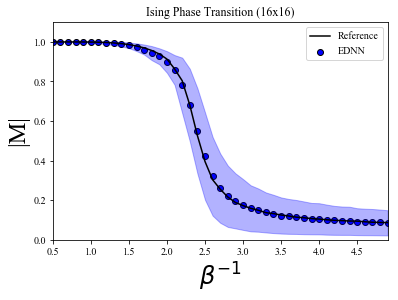

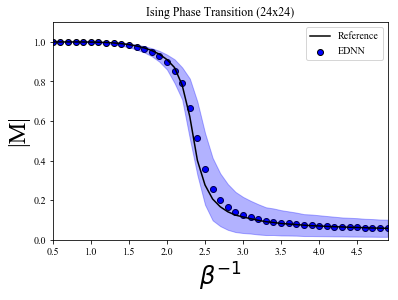

In [9]:
errplt(*EDNNISING16,5,**ednnstyle)
errplt(*REF16,5,"Ising Phase Transition (16x16)","","|M|",label="Reference",ls="-",c="k")
plt.legend()
plt.show()
plt.savefig("16x16.pdf")
errplt(*EDNNISING24,5,**ednnstyle)
errplt(*REF24,5,"Ising Phase Transition (24x24)","","|M|",label="Reference",ls="-",c="k")
plt.legend()
plt.savefig("24x24.pdf")

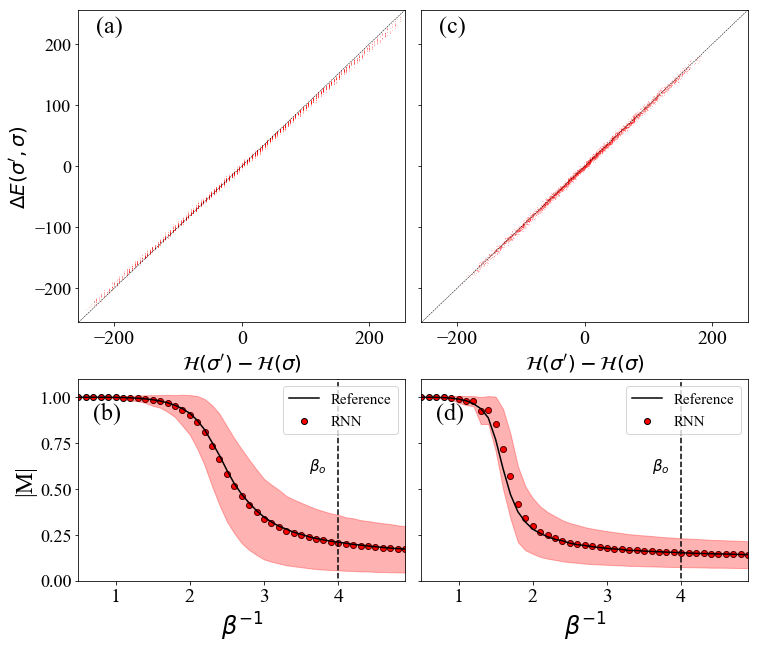

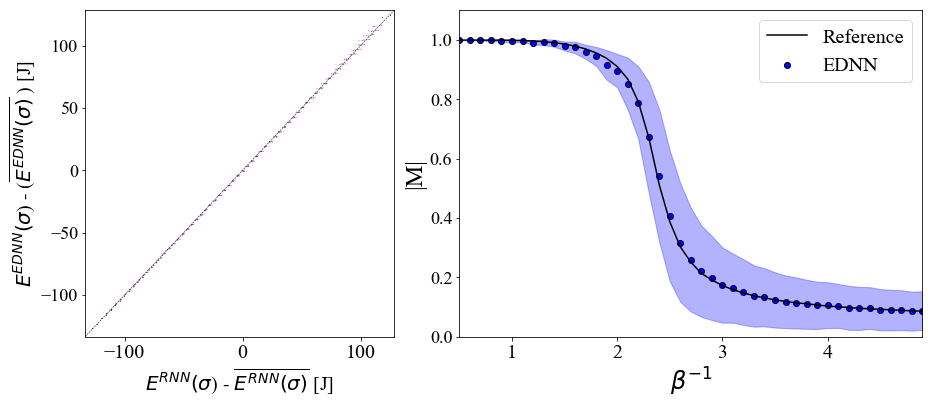

In [193]:
def axserrplt(plt,in_,out,errs,seed,title="Ising Model Phase Transition",style = "error",ylabel="|M|",errc=None,**kwargs):
    """Plots phase transitions"""
    if style=="error":
        plt.errorbar(in_, out, errs, linestyle='None', marker='.',**kwargs)
    elif style == "dot":
        plt.plot(in_,out,"o",**kwargs)
    elif style=="scatter":
        plt.scatter(in_,out,**kwargs)
    else:
        plt.plot(in_,out,**kwargs)
    if errc != None:
        tonp = np.asarray
        plt.fill_between(in_,tonp(out)-tonp(errs),tonp(out)+tonp(errs),color=errc)
    plt.set_ylabel(ylabel,fontname='Times New Roman',fontsize=24)#
    plt.set_xlabel(r'$\beta^{-1}$',fontname='Times New Roman',fontsize=24)
    plt.set_title(title,fontname='Times New Roman')
    if ylabel=="|M|":
        plt.set_ylim(0,1.1)
    elif ylabel!="default":
        plt.set_ylim(-1.5,-10/64)
    plt.set_xlim(min(in_),max(in_))
    if not kwargs["label"]  in ["EDNN","Reference"]:
        plt.text(3.6, 0.6 if ylabel=="|M|" else out[15], '$\\beta_o$', fontsize=15)
        plt.plot([4,4],[-10,1.2],"k--")

def axdeltaplt(plt,x,y,e,s,c,delta=False,points=False,lims=None,**kwargs):
 """plots the energy reference vs network graphs"""
 tonp=np.asarray

 if not delta:
     ref=x
     plt.set_ylabel(r"$E^{%s}(\sigma$) - $\overline{E^{%s}(\sigma)}$ [J]"%(s,s),fontsize=20)
     kwargs["linewidth"] = 0.5
     #plt.axis('equal')
     #plt.gca().set_aspect('equal', adjustable='box')
 if type(c)==str:
     c=list(matplotlib.colors.to_rgba(c, alpha=None)[:3])
 if points:
   plt.plot(x,y,"b.",color=c+[1.0] if len(c)==2 else c,fillstyle="full",ms=1.5,mew=0.1,alpha=0.3,**kwargs)
   if not delta:
       if lims==None:
            max_,min_ = x[-1]+10,x[0]-10
       else:
            min_,max_ = lims
       plt.plot([min_,max_],[min_,max_],"k--",**kwargs)
       plt.set_xlim(min_,max_)
       plt.set_ylim(min_,max_)
 plt.set_xlabel(r"E($\sigma$) - $\overline{E(\sigma)}$ [J]",fontsize=20)        
        
def pull_graphs(axs,fn,s="Potts",versus=False,alt=False):
    #"""Graphs the test outputs from an h5py file""""
    with h5py.File(fn,"r") as f:
        bins=f["REF_BINS"]
        x_=f["REF"]
        rnnfinal=f["RNN_BINS"]
        ednnfinal=f["EDNN_BINS"]
        rnn=f["RNN"]
        ednn=f["EDNN"]
        bins = np.asarray(bins)
        x_ = np.asarray(x_)
        rnnfinal = np.asarray(rnnfinal)
        ednnfinal = np.asarray(ednnfinal)
        rnn = np.asarray(rnn)
        ednn = np.asarray(ednn)
    f.close()
    #ns=400 if s=="Potts" else 401
    ns=397
    if alt:
        tx=[]
        trnn=[]
        for k in range(4000):
            i=np.random.randint(len(rnn))
            j=np.random.randint(len(rnn))
            tx+=[x_[i]-x_[j]]
            trnn+=[rnn[i]-rnn[j]]
        axdeltaplt(axs,tx,trnn,0,"RNN","r",points=True,delta=False,lims=(-128*2,128*2))
        axs.set_xlabel("$\mathcal{H}(\sigma')-\mathcal{H}(\sigma)$",fontsize=20)
        axs.set_ylabel("$\Delta E(\sigma', \sigma)$",fontsize=20)
    elif versus:
        axdeltaplt(axs,rnn[::ns],ednn[::ns],0,"RNN v EDNN","purple",points=True,delta=False)
        #plt.legend()
        axs.set_ylabel(r"$E^{EDNN}(\sigma$) - ($\overline{E^{EDNN}(\sigma)}$ ) [J]",fontsize=20)
        axs.set_xlabel(r"$E^{RNN}(\sigma$) - $\overline{E^{RNN}(\sigma)}$ [J]",fontsize=20)
    else:
        axdeltaplt(axs,x_[::ns],rnn[::ns],0,"RNN","r",points=True,delta=False,lims=(-135,128))# (-135,75)
    

plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=18
plt.rcParams['figure.figsize'] = [12, 10.5]        
        
fig, axs = plt.subplots(2, 2, sharex='row',
                        gridspec_kw={'hspace': 0.22, 'wspace': 0.05,'height_ratios': [1.55, 1]})




axserrplt(axs[1,0],*ISINGRNN8,**rnnstyle)
axserrplt(axs[1,0],*ISING8,42,"","","|M|",label="Reference",ls="-",c="k")
axs[1, 0].legend(fontsize=15,loc='upper right')
axserrplt(axs[1,1],*POTTSRNN8,**rnnstyle)
axserrplt(axs[1,1],*POTTS8,42,"","","|M|",label="Reference",ls="-",c="k")
axs[1,1].set_ylabel("")
axs[1, 1].legend(fontsize=15,loc='upper right')
#axs[1,1].get_yaxis().set_ticks([])
axs[1,1].get_yaxis().set_ticklabels([])

pull_graphs(axs[0,0],"raw_curves/isingerrors.h5py","Ising",alt=True)
#axs[0, 0].legend()
pull_graphs(axs[0,1],"raw_curves/pottserrors.h5py","Potts",alt=True)
axs[0,1].set_ylabel("")
#axs[0, 1].legend()
#axs[0,1].get_yaxis().set_ticks([])
axs[0,1].get_yaxis().set_ticklabels([])

#for ax in axs.flat:
    #ax.set(xlabel='x-label', ylabel='y-label')
axs[1,0].text(0.7, 0.88,"(b)", fontsize=24)
axs[1,1].text(0.7, 0.88,"(d)", fontsize=24)
axs[0,0].text(-228, 220,"(a)", fontsize=24)
axs[0,1].text(-228, 220,"(c)", fontsize=24)
# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
    #ax.label_outer()
plt.savefig("D:\\2020\\New_Figures\\fig2_rnn_transition-alt.pdf",bbox_inches='tight')
plt.show()

plt.rcParams['figure.figsize'] = [15, 6]    

fig, axs = plt.subplots(1,2, 
                        gridspec_kw={'hspace': 0.18, 'wspace': 0.17,'width_ratios': [1, 1.5]})

pull_graphs(axs[0],"raw_curves/isingerrors.h5py","Ising",True)
axserrplt(axs[1],*ISINGEDNN16,**ednnstyle)
axserrplt(axs[1],*ISING16,42,"","","|M|",label="Reference",ls="-",c="k")

axs[1].legend(fontsize=20)
im=plt.imread('checkerboard.png')
#sc=50
#axs[0].imshow(im,origin='lower', extent=[-110, -110+sc*2, 120,120-sc ])
#axs[0].arrow(-110,120,10,10)
plt.savefig("D:\\2020\\New_Figures\\TEST.svg",bbox_inches='tight')
plt.show()

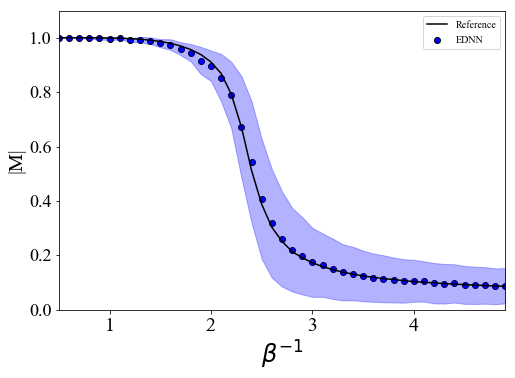

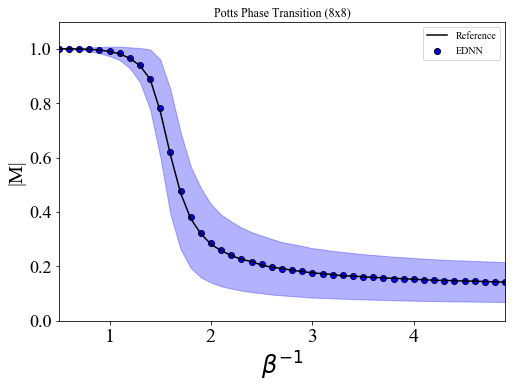

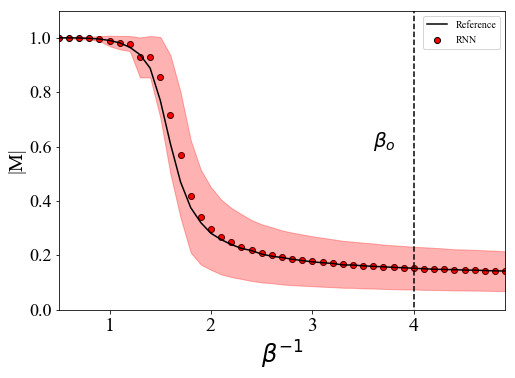

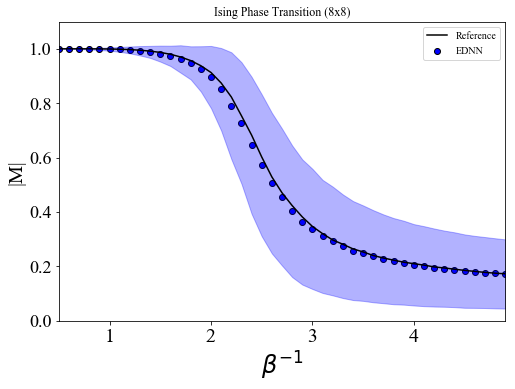

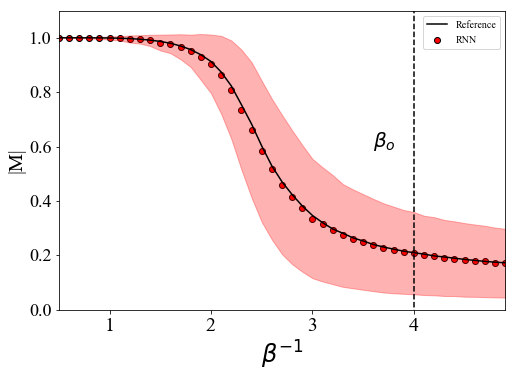

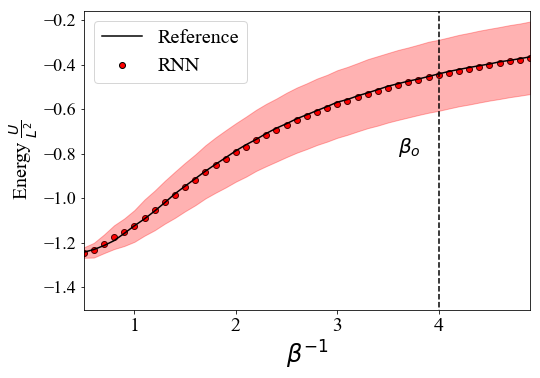

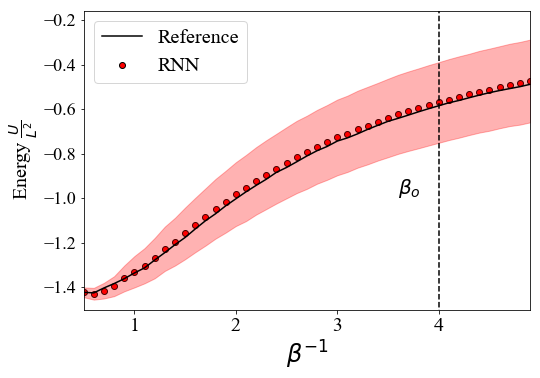

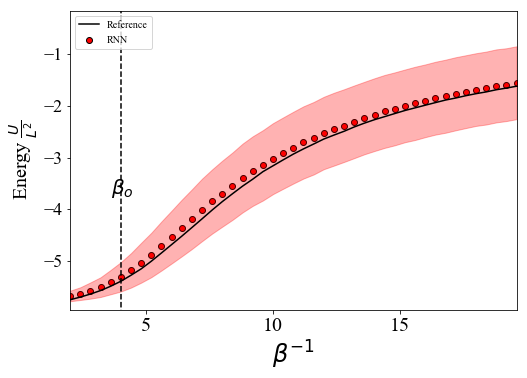

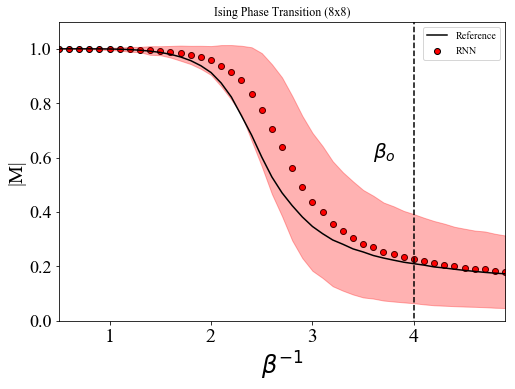

In [181]:
#PLOTTING AND SSAVING ALL THE PHASE TRANSITIONS
#smooth_show(ISING8,window_len=4)
#errplt(*SPINSRNN420_8,style="dot",label="RNN",c="r")
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=18
plt.rcParams['figure.figsize'] = [8, 5.5]
errplt(*ISINGEDNN16,**ednnstyle)
errplt(*ISING16,42,"Ising Phase Transition (16x16)","","|M|",label="Reference",ls="-",c="k")
plt.legend()
plt.savefig(save_dir+"\Ising_phase_EDNN_16.pdf")
####
plt.title("")
plt.savefig("D:\\2020\\New_Figures\\Ising_phase_EDNN_16.svg",bbox_inches='tight')
####
plt.show()
errplt(*POTTSEDNN8,**ednnstyle)
errplt(*POTTS8,42,"Potts Phase Transition (8x8)","","|M|",label="Reference",ls="-",c="k")
plt.legend()
plt.savefig(save_dir+"\Potts_phase_EDNN_8.pdf")
plt.show()
errplt(*POTTSRNN8,**rnnstyle)
errplt(*POTTS8,42,"Potts Phase Transition (8x8)","","|M|",label="Reference",ls="-",c="k")
plt.legend()
plt.savefig(save_dir+"\Potts_phase_RNN_8.pdf")
####
plt.title("")
plt.savefig("D:\\2020\\New_Figures\\Potts_phase_RNN_8.svg",bbox_inches='tight')
####
plt.show()
errplt(*ISINGEDNN8,**ednnstyle)
errplt(*ISING8,42,"Ising Phase Transition (8x8)","","|M|",label="Reference",ls="-",c="k")
plt.legend()
plt.savefig(save_dir+"\Ising_phase_EDNN_8.pdf")
plt.show()
errplt(*ISINGRNN8,**rnnstyle)
errplt(*ISING8,42,"Ising Phase Transition (8x8)","","|M|",label="Reference",ls="-",c="k")
plt.legend()
plt.savefig(save_dir+"\Ising_phase_RNN_8.pdf")
####
plt.title("")
plt.savefig("D:\\2020\\New_Figures\\Ising_phase_RNN_8.svg",bbox_inches='tight')
####
plt.show()
errplt(SPINSRNN420_8[0],*(np.asarray(SPINSRNN420_8[1:3])/64),0,ylabel="Energy $\\frac{U}{L^2}$",**rnnstyle)
errplt(SPINS420_8[0],np.asarray(SPINS420_8[1])/64,np.asarray(SPINS420_8[2])/64,420,"","","Energy $\\frac{U}{L^2}$",label="Reference",ls="-",c="k")
plt.legend(fontsize=20)
plt.savefig(save_dir+"\Spinglass_phase_NN_0.pdf")
####
plt.title("")
plt.savefig("D:\\2020\\New_Figures\\fig5_spin_glass.pdf",bbox_inches='tight')
####
plt.show()
errplt(SPINSRNN69_8[0],*(np.asarray(SPINSRNN69_8[1:3])/64),0,ylabel="Energy $\\frac{U}{L^2}$",**rnnstyle)
errplt(SPINS69_8[0],*(np.asarray(SPINS69_8[1:3])/64),0,"","","Energy $\\frac{U}{L^2}$",label="Reference",ls="-",c="k")
plt.legend(loc='upper left',fontsize=20)
plt.savefig(save_dir+"\Spinglass_phase_NN_1.pdf")
####
plt.title("")
plt.savefig("D:\\2020\\New_Figures\\figS1_spin_glass.pdf",bbox_inches='tight')
####
plt.show()
errplt(SPINALLRNN[0],*(np.asarray(SPINALLRNN[1:3])/64),0,ylabel="Energy $\\frac{U}{L^2}$",**rnnstyle)
errplt(REFSPINALL[0],*(np.asarray(REFSPINALL[1:3])/64),0,"","","Energy $\\frac{U}{L^2}$",label="Reference",ls="-",c="k")
plt.legend(loc='upper left')

plt.ylim(-380/64,-10/64)
plt.savefig(save_dir+"\Spinglass_phase_NN_0.pdf")
plt.show()
errplt(*SMALLISINGRNN8,**rnnstyle)
errplt(*ISING8,42,"Ising Phase Transition (8x8)","","|M|",label="Reference",ls="-",c="k")
plt.legend()
plt.savefig(save_dir+"\S_Ising_phase_RNN_8.pdf")
plt.show()

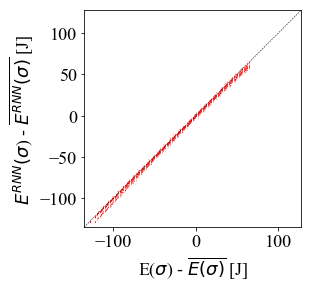

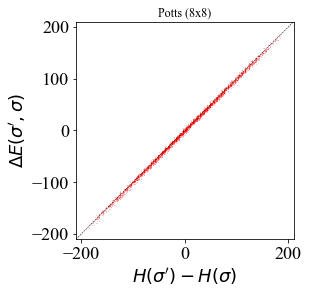

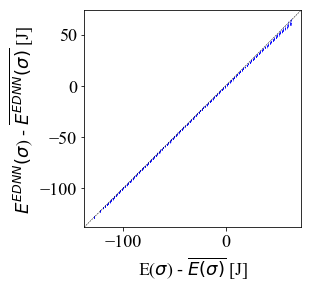

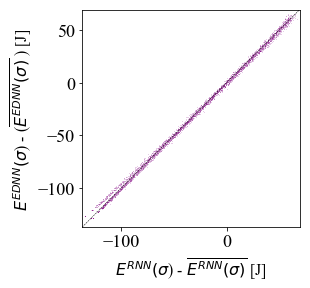

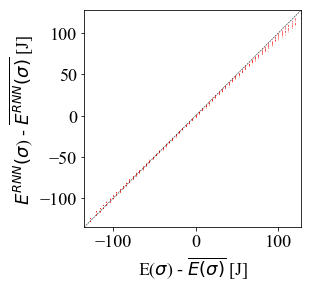

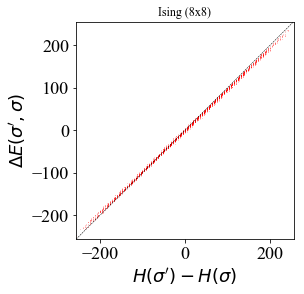

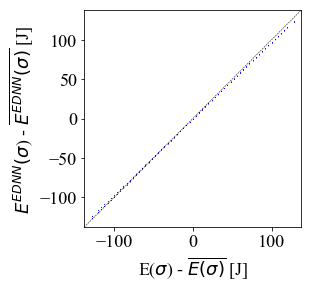

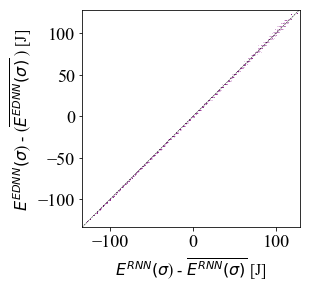

In [25]:
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
def pull_graphs(fn,s="Potts"):
    #"""Graphs the test outputs from an h5py file""""
    with h5py.File(fn,"r") as f:
        bins=f["REF_BINS"]
        x_=f["REF"]
        rnnfinal=f["RNN_BINS"]
        ednnfinal=f["EDNN_BINS"]
        rnn=f["RNN"]
        ednn=f["EDNN"]
        bins = np.asarray(bins)
        x_ = np.asarray(x_)
        rnnfinal = np.asarray(rnnfinal)
        ednnfinal = np.asarray(ednnfinal)
        rnn = np.asarray(rnn)
        ednn = np.asarray(ednn)
    f.close()
    #ns=400 if s=="Potts" else 401
    ns=397
    deltaplt(x_[::ns],rnn[::ns],0,"RNN","r",points=True,delta=False,lims=(-135,128))# (-135,75)
    
    
    #plt.legend()
    plt.savefig("C:/Users/sprag/Dropbox/2019-RNN/figures/%s_linear_RNN_True.pdf"%s)
    ###
    plt.savefig("D:\\2020\\New_Figures\\%s_linear_RNN_True.svg"%s,bbox_inches='tight')
    ###
    plt.show()
    #test thing
    
    tx=[]
    trnn=[]
    for k in range(4000):
        i=np.random.randint(len(rnn))
        j=np.random.randint(len(rnn))
        tx+=[x_[i]-x_[j]]
        trnn+=[rnn[i]-rnn[j]]
    deltaplt(tx,trnn,0,"RNN","r",points=True,delta=False,lims=(-128*2,128*2) if s!="Potts" else (-135-75,75+135))
    plt.xlabel("$H(\sigma')-H(\sigma)$")
    plt.ylabel("$\Delta E(\sigma', \sigma)$")
    plt.title("%s (8x8)"%s)
    plt.savefig("test%s.png"%s,dpi=300)
    plt.show()
    
    
    #return
    deltaplt(x_[::ns],ednn[::ns],0,"EDNN","b",points=True,delta=False)
    #plt.legend()
    plt.savefig("C:/Users/sprag/Dropbox/2019-RNN/figures/%s_linear_EDNN_True.pdf"%s)
    plt.show()
    
    deltaplt(rnn[::ns],ednn[::ns],0,"RNN v EDNN","purple",points=True,delta=False)
    #plt.legend()
    plt.ylabel(r"$E^{EDNN}(\sigma$) - ($\overline{E^{EDNN}(\sigma)}$ ) [J]",fontsize=16)
    plt.xlabel(r"$E^{RNN}(\sigma$) - $\overline{E^{RNN}(\sigma)}$ [J]",fontsize=16)
    plt.savefig("C:/Users/sprag/Dropbox/2019-RNN/figures/%s_linear_EDNN_RNN.pdf"%s)
    
    ###
    plt.savefig("D:\\2020\\New_Figures\\%s_linear_EDNN_RNN.svg"%s,bbox_inches='tight')
    ###
    plt.show()
    return
    deltaplt(*bin_compare(bins,rnnfinal),"RNN","r",points=False,delta=True)
    #plt.show()
    deltaplt(*bin_compare(bins,ednnfinal),"EDNN","b",points=False,delta=True)
    plt.legend()
    plt.ylabel(r"$E^{model}(\sigma_i$)-E($\sigma_i$) - ($\overline{E^{model}(\sigma)}-\overline{E(\sigma)}$ ) [J]")
    #potts
    if s=="Potts":
        plt.ylim(-5.5,5.5)
    else:
        plt.ylim(-10,10)
    plt.savefig("C:/Users/sprag/Dropbox/2019-RNN/figures/%s_horizontal_EDNNRNN_True.pdf"%s,dpi=500)
    plt.show()
    
    deltaplt(rnn,ednn,1,"RNN vs EDNN","purple",points=True,delta=True)
    plt.ylabel(r"E^{EDNN}($\sigma_i$)-E^{RNN}($\sigma_i$) - ($\overline{E^{EDNN}(\sigma)}-\overline{E^{RNN}(\sigma)}$ ) [J]")
    plt.xlabel(r"E^{RNN}($\sigma_i$) - $\overline{E^{RNN}(\sigma)}$")
    #plt.ylim(-6.5,6.5)
    plt.savefig("%s_ednn_oer_rnn.png"%s,dpi=1000)
    plt.show()
    
    k = rebin_compare(bins,rnnfinal,ednnfinal,1 if s=="Potts" else 2.5)
    deltaplt(*k,"RNN vs EDNN","purple",points=False,delta=True)
    plt.ylabel(r"$E^{EDNN}(\sigma$)-$E^{RNN}(\sigma$) - ($\overline{E^{EDNN}(\sigma)}-\overline{E^{RNN}(\sigma)}$ ) [J]")
    plt.xlabel(r"$E^{RNN}(\sigma$) - $\overline{E^{RNN}(\sigma)}$")
    plt.ylim(-6.5,6.5)
    plt.savefig("C:/Users/sprag/Dropbox/2019-RNN/figures/%s_horizontal_EDNN_RNN.pdf"%s,dpi=500)

    plt.show()
    


pull_graphs("raw_curves/pottserrors.h5py","Potts")

pull_graphs("raw_curves/isingerrors.h5py","Ising")

In [52]:
from Unrolled_RNN import URNN

In [4]:
model.close()
#model=URNN("D:\\2020\\Export\\32crit",code="",flat="SPIRAL",model="ISING1",hidden_size=378,T=2.2691)
model=URNN("D:\\2020\\Export\\32crit",code="",flat="SPIRAL",model="ISING1",hidden_size=378,T=2.2691)
arrs,E,vals = model.generate_data(width=8000,seed=None)
m=sum([abs(np.sum(a)) for a in arrs])/64/8000

print(m)
print(-sum(np.log(vals))/8000/64)

model.gen_data("DISTISING1")

None
T=2.2691, N=8
INFO:tensorflow:Restoring parameters from D:\2020\Export\32critISING1/model.ckpt-384000


In [20]:
model.close()
model=RNN("D:\\2020\\Export\\32cold",code="",flat="SPIRAL",model="ISING1",hidden_size=378,T=2)

None
T=2, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32coldISING1/model.ckpt-192000


D:\Ananconda\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32coldISING1/model.ckpt-192000


None
T=8, N=8
2000


D:\Ananconda\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from D:\2020\Export\2HAISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2HAISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2HAISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 2.697978766509737
[1.0773784653562615, 1.2433567259375433, 1.374182115532129, 1.3787188157649233, 1.489282179772038, 1.4860578023883446, 1.5727681583051971, 1.5791501773488903, 1.664868560847284, 1.6941260283520125, 1.6540228909980312, 1.7298085505894334, 1.7763582443393222, 1.8472750578250852, 1.8116780846604963, 1.8270560883998663, 1.8562110891040364, 1.7457166098707042, 1.7651766253508125, 1.8225576673631276, 1.7659665278653633, 1.7447642309447335, 1.7719519899598917, 1.8104308641390436, 1.8

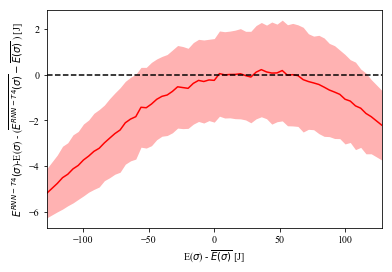

None
T=8, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2HBISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2HBISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2HBISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 5.580952630951163
[0.11687119854029505, 0.5100950384377928, 0.7106932825704485, 0.698008867021211, 0.8495843557995737, 0.8248153572891679, 0.9570635702085096, 0.9871054170926346, 1.070874286017168, 1.1066809699997022, 1.2256569346572006, 1.2163295007026198, 1.3699408158203514, 1.4130179308153694, 1.441362372205213, 1.470143134808817, 1.4851749657144202, 1.6578581521014009, 1.5731332561733757, 1.5921571406815131, 1.5990440687316718, 1.6684162437153702, 1.5877762856082538, 1.66

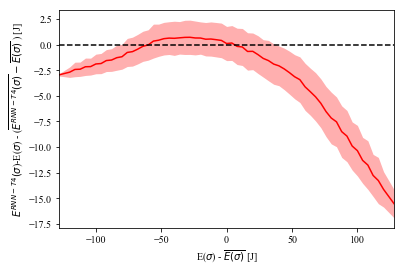

None
T=8, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2HCISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2HCISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2HCISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 4.947813314973808
[2.247317994617617, 2.3084292733030853, 2.301888032712534, 2.2799931540507683, 2.2826579549259534, 2.281128338397445, 2.2564408235519466, 2.2690842864847522, 2.2497959773748004, 2.271455533751274, 2.218856637807121, 2.192874168146718, 2.0948077870312134, 2.0687441653924994, 2.0157772924409594, 2.010029956578931, 1.8666950008659295, 1.8069159073318544, 1.808697384844876, 1.6939014891878552, 1.6566796309283884, 1.6981304532099533, 1.6340376415839257, 1.7397158

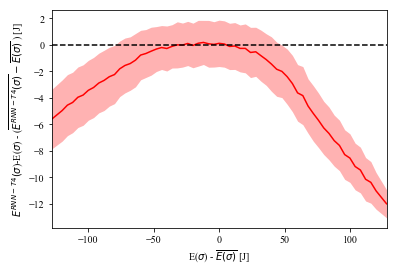

None
T=8, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2HDISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2HDISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2HDISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 4.5833240773559
[0.9990335411431205, 1.0478244392535325, 1.1037458936320006, 1.0905821326269733, 1.1285196660533705, 1.1182702858888107, 1.1907454513839675, 1.2348552228066283, 1.271017263135614, 1.274114056891377, 1.3759634118133954, 1.4156364526961578, 1.4832378389510295, 1.580955182866951, 1.6424216431713965, 1.7424736550261186, 1.8320740375407587, 1.8686497092936742, 1.841382697898441, 1.8974142238732248, 1.90410696601477, 1.891828151580476, 1.9179699517396658, 1.89101736

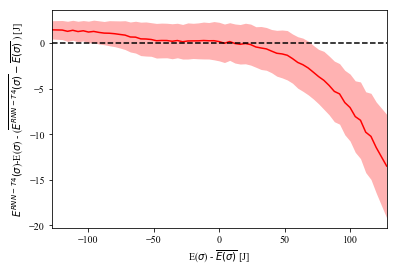

None
T=8, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2HEISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2HEISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2HEISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 19.059031452814352
[1.4485002112312912, 1.61560205407087, 2.252144286181777, 1.904753201067289, 2.592510340533578, 2.4471313136219397, 3.0333100046357013, 3.2304044175763718, 3.7651162373794747, 3.8564323267957694, 4.491993421957601, 5.078704855239745, 5.564399959601136, 6.519789958632046, 6.204406474491373, 6.439431091584011, 6.5097089248742, 6.385455620234436, 6.339120337414925, 5.842826014967145, 5.908288151430115, 5.806189341722673, 5.646314191735599, 5.609424624617523, 5

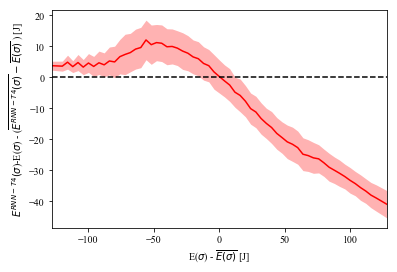

None
T=8, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2HFISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2HFISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2HFISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 4.34645349681263
[4.862256279508728, 4.370636714380718, 4.250809409307448, 3.9558689690846864, 3.827836872709083, 3.5393869185135065, 3.435851387634096, 3.2684427183740197, 3.1008715928721076, 2.954543707149435, 2.853261494282425, 2.6964454671703497, 2.6057686881214748, 2.5404750832502327, 2.4936192032315736, 2.377804895898818, 2.333472975028016, 2.1178121897840043, 2.13355563527426, 2.0271559129316477, 1.9203662963075372, 1.8677839152679088, 1.983140654799249, 1.878153313443

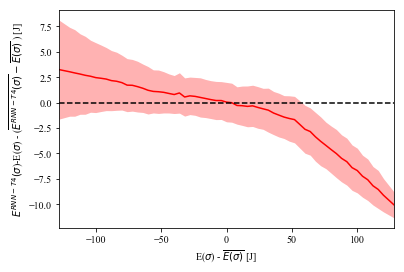

None
T=4, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2RAISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2RAISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2RAISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 2.147167424801408
[0.49869213164755877, 0.6313027024593366, 0.8095065222782242, 0.715790270361791, 0.8566598384242057, 0.7723832751407657, 0.8700942054936576, 0.864769710666481, 0.9360514778252939, 0.9102786442580384, 0.9499373677520777, 0.9279798526477857, 0.9733235223519119, 0.9524959875698982, 0.9719014666997817, 0.982663128072979, 0.952690234842478, 0.9358869081874291, 0.930949293917488, 0.9043400884465349, 0.9214858057821355, 0.9417369278845089, 0.9281485845222764, 0.917

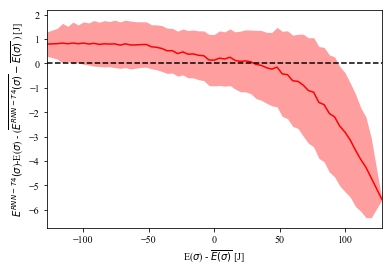

None
T=4, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2RBISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2RBISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2RBISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 1.695161845955418
[0.5132666388006158, 0.5183412082222433, 0.5062132439202658, 0.524157316765918, 0.5213022908644346, 0.5399094155162867, 0.5350033110604286, 0.5442210678044005, 0.5723015839264051, 0.5770169818219226, 0.593916922218074, 0.5951976087951067, 0.64266568763439, 0.65187455600132, 0.6678290671760994, 0.6782632386688869, 0.7153073716338985, 0.7000576408829614, 0.716657956909126, 0.6954350480163561, 0.7253797849718429, 0.7421506464180497, 0.738434959033768, 0.7342987

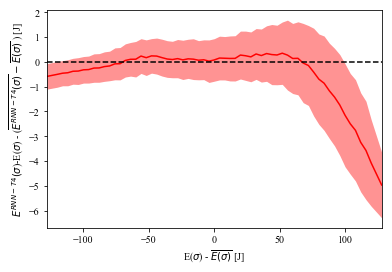

None
T=4, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2RCISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2RCISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2RCISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 2.3799667044149797
[3.062815612546437, 2.91174774423007, 2.8352967138922214, 2.771581573026586, 2.661959875199777, 2.608939972902487, 2.4955826244651664, 2.4460349218362554, 2.3541950596289394, 2.278280550897907, 2.1362636995472095, 2.046841899206134, 1.9170286354179853, 1.7600213772840707, 1.6234494145272664, 1.5766411460073853, 1.3635323087874647, 1.242975398508992, 1.2446273582631395, 1.170218999790599, 1.133166197463616, 1.082389096732006, 1.068787221687476, 1.07258900716

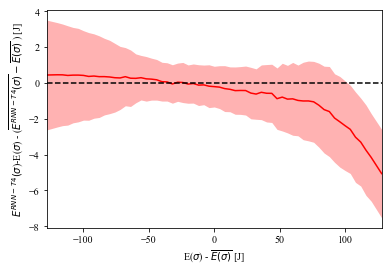

None
T=4, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2RDISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2RDISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2RDISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 4.718133417594579
[0.07730774422312692, 0.22933245270395158, 0.3179835408564833, 0.3204254763986989, 0.3841295941397005, 0.38874797534763955, 0.43438879435522015, 0.43841451470037446, 0.47337964336330457, 0.5000980289719267, 0.5386212753855858, 0.5531018308251816, 0.6112318089716549, 0.6453230580704057, 0.6575720201963946, 0.6687874216538819, 0.7278120068963617, 0.7821573085799262, 0.7622864414583156, 0.8133156948307552, 0.7819049030526626, 0.7944261907514569, 0.8360748692144

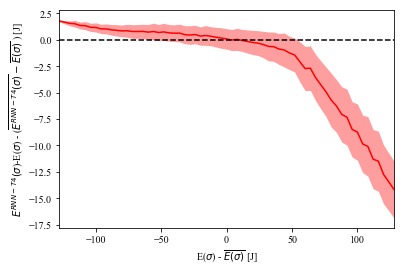

None
T=4, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2REISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2REISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2REISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 1.5260816923178442
[1.9753767094817785, 1.8283588918751268, 1.754967177106276, 1.7042040853602263, 1.62717208507153, 1.5869135329540267, 1.5063573387577907, 1.4770057219777133, 1.419308536461981, 1.3779473292829072, 1.333889912187619, 1.2423899992072884, 1.2043394946153858, 1.125956954956368, 1.0426124321649377, 1.0213300751977457, 1.0017488563958292, 0.9378966505212393, 0.9669170912634067, 0.9057548738412183, 0.8758731889197223, 0.8429165129185405, 0.8891555887586932, 0.8872

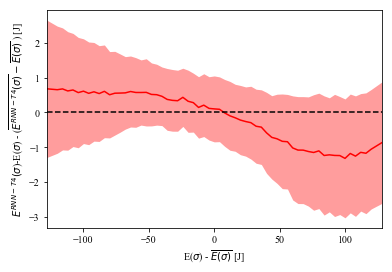

None
T=4, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2RFISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2RFISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\2RFISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 12.521078137327802
[1.0694327965852108, 1.3023340051839403, 1.7011796559865622, 1.5094623298070866, 1.8796283901195645, 1.7645043243332479, 2.088128680559888, 1.9873674971949802, 2.2704575180930955, 2.287038586523073, 2.432010271327796, 2.5445586264638926, 2.58754839952939, 2.7952880728187943, 2.913749505300724, 2.950742766206829, 3.060191191924523, 3.1430898598112647, 3.148997887918563, 3.1194469965774436, 3.2095341762600222, 3.1351568109866244, 3.2847684660282757, 3.4315343

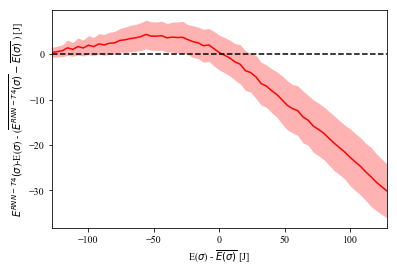

None
T=2.2691, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32AcritISING1/model.ckpt-384000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32AcritISING1/model.ckpt-384000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32AcritISING1/model.ckpt-384000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 3.2685600211559627
[0.09221140132041938, 0.11302494536852903, 0.15567163258242064, 0.15636274654241883, 0.19213415122544172, 0.2145683756318229, 0.2502176934883435, 0.29020587427008315, 0.3120327914002527, 0.3602094968721319, 0.3893994652388534, 0.42389832524585364, 0.45045514870329906, 0.4973308896209614, 0.523147925839718, 0.5377412789475686, 0.5778079102539989, 0.604551258417004, 0.6308224409277187, 0.643004740553929, 0.6462575300804895, 0.7011803459703395

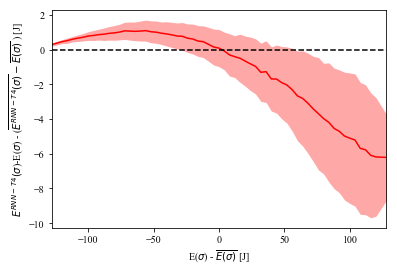

None
T=2.2691, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32BcritISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32BcritISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32BcritISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 4.763611450056259
[0.006940988235704993, 0.10579474258418389, 0.13976252827082022, 0.17137648882604706, 0.2038350582474418, 0.23300735077032464, 0.2639749506114792, 0.3072740104811771, 0.32875648750384007, 0.38586444903185874, 0.4088137713604001, 0.4529769890380587, 0.4993904654088164, 0.5522810200421034, 0.5738912483531374, 0.5852010686744288, 0.6416015053023215, 0.6801749796104333, 0.6829793438686508, 0.6991186963904984, 0.7344208822275681, 0.75810791668711

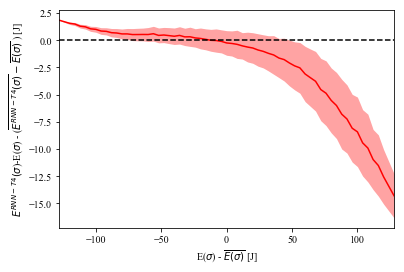

None
T=2.2691, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32CcritISING1/model.ckpt-189611
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32CcritISING1/model.ckpt-189611
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32CcritISING1/model.ckpt-189611
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 5.942647113421027
[0.18746286862915437, 0.17640878896434886, 0.1776712173197621, 0.199886197820168, 0.21991030121850683, 0.2643370041257482, 0.2730693842146248, 0.3267500236960504, 0.33975029198159246, 0.3914927242784649, 0.41778136367013435, 0.4475930605894798, 0.46527332427542867, 0.5220383248302276, 0.5368952171874863, 0.5633624687926411, 0.598908418709858, 0.6785973242645519, 0.7049508135069569, 0.709586366391099, 0.6680245798537655, 0.7462905931178717, 0

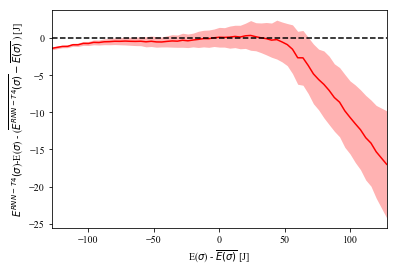

None
T=2.2691, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32DcritISING1/model.ckpt-189622
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32DcritISING1/model.ckpt-189622
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32DcritISING1/model.ckpt-189622
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 4.487348767611293
[1.2735757971151214, 0.8191909793423182, 0.7110027745982065, 0.4419822282717991, 0.3916581015989757, 0.32039570304514287, 0.3636652036620025, 0.5012158562080832, 0.5824472074762836, 0.7166743868594406, 0.7820935916168495, 0.9311451560610966, 0.9467637147354672, 1.0649451697927577, 1.0989158003863282, 1.051606295309659, 1.0607554584177452, 0.9573683165650511, 1.0788705685355715, 0.9397556523294671, 0.9748387493083828, 1.0204746550071973, 1.00

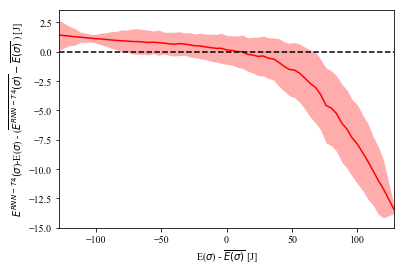

None
T=2.2691, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32EcritISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32EcritISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32EcritISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 4.997448106348182
[0.010456059243239224, 0.11263346324535095, 0.12812591450557023, 0.1670045068838502, 0.1901282981779845, 0.21368798309541231, 0.237545608082301, 0.2555523349635373, 0.2739362774812387, 0.3080895259996403, 0.33693420479615815, 0.3750363708621602, 0.44603986154563685, 0.464867046266126, 0.5416160891120388, 0.5859557579440642, 0.6675395117488486, 0.7607700799497097, 0.7510914024751669, 0.8119189994409867, 0.841479922060017, 0.8811465236546173, 

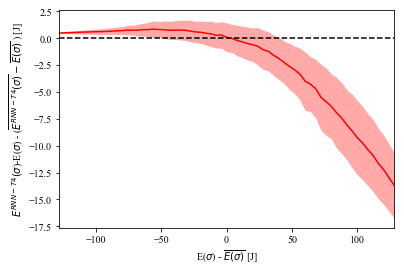

None
T=2.2691, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32FcritISING1/model.ckpt-189600
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32FcritISING1/model.ckpt-189600
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32FcritISING1/model.ckpt-189600
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 2.486099384444369
[0.6318841164734793, 0.4726720646061951, 0.41892203758200736, 0.35707396366922517, 0.3230315327786245, 0.30192762002906687, 0.31165418361512504, 0.32318233945507013, 0.36278477939256837, 0.41316455501624094, 0.44453255930872015, 0.5311674359283722, 0.6034841667500119, 0.6357170259940096, 0.7588494067709238, 0.7797179007224221, 0.9184994953984787, 0.9601336707883202, 0.9322260389499782, 0.9984123303972161, 1.0336822075649366, 1.05108837829041

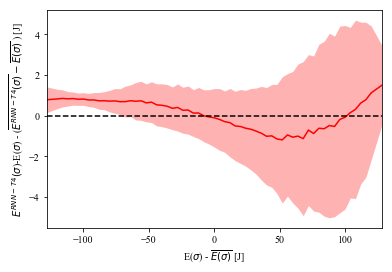

In [11]:
hot=[]
for txt in "ABCDEF":
    model=RNN("D:\\2020\\Export\\2H"+txt,code="",flat="SPIRAL",model="ISING1",hidden_size=378,T=8)

    bins=[a for a in range(-128,129,4) if abs(a)!=124]
    hot+=[pred_bins(model.Hs,"Uniform2.h5py",bins)]
    deltaplt(*bin_compare(bins,hot[-1]),"RNN-T4","r",points=False,delta=True)
    plt.show()
    model.close()
mild=[]
for txt in "ABCDEF":
    model=RNN("D:\\2020\\Export\\2R"+txt,code="",flat="SPIRAL",model="ISING1",hidden_size=378,T=4)

    bins=[a for a in range(-128,129,4) if abs(a)!=124]
    mild+=[pred_bins(model.Hs,"Uniform2.h5py",bins)]
    deltaplt(*bin_compare(bins,mild[-1]),"RNN-T4","r",points=False,delta=True)
    plt.show()
    model.close()
crit=[]
for txt in "ABCDEF":
    model=RNN("D:\\2020\\Export\\32"+txt+"crit",code="",flat="SPIRAL",model="ISING1",hidden_size=378,T=2.2691)
    
    bins=[a for a in range(-128,129,4) if abs(a)!=124]
    crit+=[pred_bins(model.Hs,"Uniform2.h5py",bins)]
    deltaplt(*bin_compare(bins,crit[-1]),"RNN-T4","r",points=False,delta=True)
    plt.show()
    model.close()

None
T=8, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHAISING1/model.ckpt-189655


D:\Ananconda\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHAISING1/model.ckpt-189655
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHAISING1/model.ckpt-189655
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 2.4531503230400062


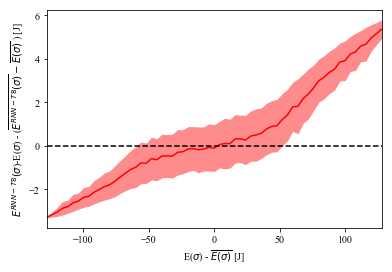

None
T=8, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHBISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHBISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHBISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 2.0123931257581957


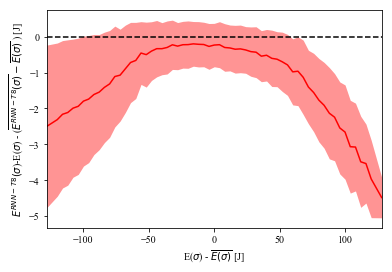

None
T=8, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHCISING1/model.ckpt-188222
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHCISING1/model.ckpt-188222
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHCISING1/model.ckpt-188222
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 1.275718866420413


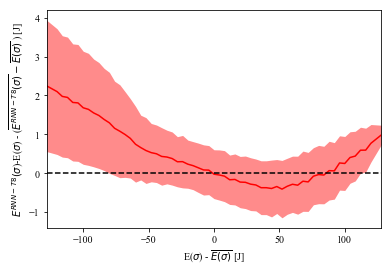

None
T=8, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHDISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHDISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHDISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 1.5718432971543421


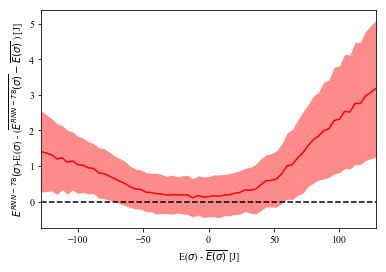

None
T=8, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHEISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHEISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHEISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 0.7777706081210353


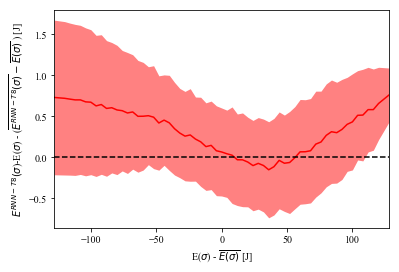

None
T=8, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHFISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHFISING1/model.ckpt-192000
-128 8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHFISING1/model.ckpt-192000
-120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 1.420314650840905


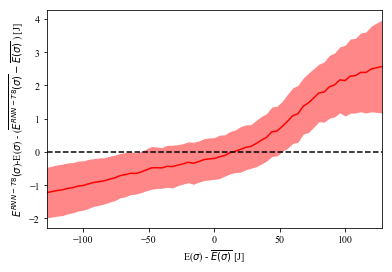

In [6]:
hot_decor=[]
model.close()
for txt in "ABCDEF":
    model=RNN("D:\\2020\\Export\\32SH"+txt,code="",flat="SPIRAL",model="ISING1",hidden_size=378,T=8)

    bins=[a for a in range(-128,129,4) if abs(a)!=124]
    hot_decor+=[pred_bins(model.Hs,"Uniform2.h5py",bins)]
    deltaplt(*bin_compare(bins,hot_decor[-1]),"RNN-T8","r",points=False,delta=True)
    #model.gen_data("TD3.1/"+txt+"crit",div=240)
    plt.show()
    model.close()

In [8]:
with h5py.File("Results.h5py","a") as f:
    f.create_dataset("hot-decorr",data=hot_decor)
    f.create_dataset("mild-decorr-2",data=mild_decor)

None
T=4, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SAISING1/model.ckpt-192000


D:\Ananconda\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SAISING1/model.ckpt-192000
8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SAISING1/model.ckpt-192000
[[-1. -1. -1. -1.  1. -1.  1. -1.]
 [-1. -1. -1.  1.  1. -1. -1. -1.]
 [-1. -1. -1. -1.  1.  1. -1. -1.]
 [-1. -1.  1. -1.  1. -1.  1.  1.]
 [-1.  1.  1. -1.  1.  1. -1.  1.]
 [ 1.  1. -1.  1.  1.  1. -1. -1.]
 [-1. -1.  1. -1.  1. -1. -1. -1.]
 [-1. -1. -1. -1.  1.  1. -1. -1.]]
---------------------------------- 0.4166666666666667 ----------------------------------
[[-1. -1. -1. -1.  1. -1.  1.  1.]
 [ 1.  1. -1.  1. -1.  1.  1. -1.]
 [ 1. -1. -1. -1. -1. -1. -1.  1.]
 [ 1. -1.  1.  1. -1.  1.  1.  1.]
 [ 1. -1. -1. -1.  1. -1. -1. -1.]
 [-1. -1.  1. -1. -1.  1. -1. -1.]
 [-1. -1.  1.  1.  1. -1.  1.  1.]
 [-1.  1.  1.  1. -1. -1.  1.  1.]]
---------------------------------- 0.8333333333333334 ----------------------------------
[[ 1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1. -1.  1.  1.  1. -1. -1.  1.]
 [ 1.  

[[ 1.  1.  1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1. -1. -1.  1.  1.  1.]
 [-1. -1. -1.  1.  1.  1.  1. -1.]
 [ 1.  1.  1. -1. -1. -1. -1. -1.]
 [-1.  1. -1. -1.  1.  1.  1. -1.]
 [-1.  1.  1. -1. -1.  1.  1. -1.]
 [-1.  1. -1.  1. -1. -1. -1.  1.]
 [ 1. -1.  1.  1.  1.  1.  1.  1.]]
---------------------------------- 9.583333333333334 ----------------------------------
[[ 1.  1. -1.  1.  1.  1.  1.  1.]
 [-1.  1. -1. -1. -1.  1.  1. -1.]
 [-1. -1.  1.  1.  1. -1.  1.  1.]
 [-1. -1.  1.  1. -1. -1. -1.  1.]
 [-1.  1.  1.  1. -1. -1. -1.  1.]
 [-1.  1. -1. -1.  1. -1.  1.  1.]
 [ 1. -1. -1.  1.  1. -1.  1. -1.]
 [ 1.  1.  1. -1.  1.  1.  1.  1.]]
---------------------------------- 10.0 ----------------------------------
[[ 1.  1.  1.  1.  1.  1.  1.  1.]
 [-1. -1. -1.  1.  1. -1.  1.  1.]
 [-1.  1.  1.  1.  1. -1.  1. -1.]
 [ 1. -1.  1. -1. -1.  1. -1.  1.]
 [-1.  1. -1. -1. -1. -1.  1. -1.]
 [ 1.  1.  1. -1. -1. -1.  1.  1.]
 [-1. -1. -1. -1.  1.  1.  1. -1.]
 [-1. -1.  1.  1.  1. -1.  1. 

[[-1.  1. -1. -1. -1.  1. -1. -1.]
 [ 1.  1.  1.  1. -1. -1.  1.  1.]
 [-1.  1.  1. -1.  1.  1. -1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1. -1.]
 [-1. -1.  1.  1.  1.  1.  1.  1.]
 [-1. -1. -1. -1.  1.  1.  1.  1.]
 [ 1.  1. -1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1. -1. -1. -1. -1.  1.]]
---------------------------------- 19.166666666666668 ----------------------------------
[[ 1. -1.  1. -1.  1.  1. -1. -1.]
 [ 1.  1. -1.  1.  1.  1. -1. -1.]
 [-1. -1. -1. -1.  1. -1.  1. -1.]
 [-1.  1. -1. -1. -1. -1. -1.  1.]
 [ 1. -1. -1.  1. -1.  1. -1. -1.]
 [ 1.  1.  1. -1. -1. -1.  1. -1.]
 [ 1.  1.  1. -1. -1. -1.  1. -1.]
 [-1.  1. -1.  1.  1. -1. -1.  1.]]
---------------------------------- 19.583333333333332 ----------------------------------
[[ 1.  1. -1. -1.  1.  1.  1. -1.]
 [ 1.  1. -1.  1. -1. -1. -1.  1.]
 [ 1. -1. -1. -1. -1.  1. -1. -1.]
 [ 1.  1.  1. -1.  1. -1.  1. -1.]
 [-1.  1. -1. -1. -1.  1. -1.  1.]
 [ 1. -1.  1.  1. -1. -1.  1. -1.]
 [ 1. -1. -1. -1.  1. -1.  1. -1.]
 [-1.  1.  1.  

[[-1. -1. -1. -1. -1. -1.  1.  1.]
 [ 1. -1.  1. -1. -1. -1.  1. -1.]
 [ 1. -1.  1.  1. -1. -1. -1.  1.]
 [-1.  1. -1. -1. -1.  1. -1.  1.]
 [-1. -1. -1.  1. -1. -1.  1.  1.]
 [ 1. -1.  1.  1. -1.  1.  1. -1.]
 [-1.  1.  1.  1.  1. -1. -1.  1.]
 [-1.  1.  1.  1. -1.  1. -1.  1.]]
---------------------------------- 28.749999999999996 ----------------------------------
[[-1. -1.  1. -1. -1.  1.  1.  1.]
 [-1. -1.  1.  1. -1.  1. -1.  1.]
 [ 1. -1. -1. -1. -1.  1.  1.  1.]
 [ 1. -1. -1. -1.  1. -1. -1. -1.]
 [-1.  1.  1.  1.  1. -1. -1. -1.]
 [ 1. -1.  1.  1. -1. -1.  1. -1.]
 [ 1. -1. -1.  1. -1. -1. -1. -1.]
 [-1.  1. -1. -1. -1.  1.  1.  1.]]
---------------------------------- 29.166666666666668 ----------------------------------
[[ 1.  1. -1. -1. -1.  1. -1.  1.]
 [-1.  1. -1.  1. -1.  1. -1. -1.]
 [ 1. -1. -1. -1.  1.  1.  1. -1.]
 [-1. -1.  1.  1.  1.  1.  1. -1.]
 [ 1. -1.  1. -1. -1. -1. -1.  1.]
 [-1. -1.  1.  1.  1.  1.  1.  1.]
 [-1. -1.  1. -1.  1.  1.  1.  1.]
 [-1.  1.  1. -

[[ 1.  1. -1. -1. -1.  1. -1.  1.]
 [ 1.  1. -1. -1. -1.  1. -1.  1.]
 [ 1.  1.  1. -1. -1. -1.  1.  1.]
 [-1. -1.  1.  1.  1.  1. -1. -1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [ 1.  1.  1.  1.  1.  1. -1. -1.]
 [ 1. -1. -1. -1.  1.  1. -1.  1.]
 [-1. -1.  1.  1. -1. -1. -1.  1.]]
---------------------------------- 38.333333333333336 ----------------------------------
[[-1. -1.  1. -1. -1. -1.  1. -1.]
 [ 1. -1.  1.  1.  1.  1. -1. -1.]
 [ 1.  1.  1. -1. -1. -1. -1.  1.]
 [-1.  1. -1. -1.  1.  1.  1. -1.]
 [ 1.  1. -1. -1.  1.  1.  1. -1.]
 [-1.  1.  1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1.  1.  1.  1.  1.]
 [ 1. -1. -1.  1. -1.  1. -1. -1.]]
---------------------------------- 38.75 ----------------------------------
[[ 1. -1.  1.  1.  1.  1.  1. -1.]
 [ 1. -1.  1. -1. -1.  1.  1. -1.]
 [ 1. -1. -1. -1. -1. -1.  1.  1.]
 [ 1. -1.  1.  1. -1. -1.  1. -1.]
 [ 1.  1. -1.  1. -1.  1. -1. -1.]
 [-1.  1.  1. -1. -1.  1. -1.  1.]
 [-1.  1. -1. -1.  1.  1.  1.  1.]
 [-1. -1. -1. -1. -1.  1.  1

[[-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1.  1.  1. -1.  1. -1. -1. -1.]
 [-1.  1. -1. -1.  1. -1.  1. -1.]
 [ 1.  1. -1. -1. -1.  1. -1. -1.]
 [-1. -1.  1.  1.  1.  1. -1. -1.]
 [-1.  1.  1.  1. -1.  1.  1. -1.]
 [ 1. -1. -1.  1. -1. -1.  1.  1.]
 [-1. -1.  1. -1. -1. -1. -1.  1.]]
---------------------------------- 47.91666666666667 ----------------------------------
[[-1.  1.  1. -1. -1. -1.  1. -1.]
 [ 1.  1. -1. -1.  1. -1. -1. -1.]
 [-1.  1.  1. -1. -1.  1.  1. -1.]
 [-1.  1.  1. -1.  1.  1.  1. -1.]
 [-1. -1. -1.  1. -1.  1.  1.  1.]
 [-1.  1. -1. -1. -1.  1. -1. -1.]
 [-1.  1.  1.  1. -1.  1. -1.  1.]
 [ 1.  1.  1.  1. -1.  1.  1.  1.]]
---------------------------------- 48.333333333333336 ----------------------------------
[[-1. -1. -1.  1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1. -1.  1. -1.]
 [-1. -1.  1.  1.  1.  1.  1. -1.]
 [-1. -1. -1.  1.  1.  1.  1. -1.]
 [-1.  1.  1.  1.  1.  1. -1.  1.]
 [ 1.  1. -1.  1. -1.  1.  1. -1.]
 [-1.  1.  1.  1.  1. -1.  1.  1.]
 [-1. -1. -1. -1

[[ 1. -1. -1. -1. -1.  1.  1. -1.]
 [ 1.  1. -1. -1.  1. -1.  1.  1.]
 [ 1.  1. -1. -1. -1. -1.  1. -1.]
 [-1.  1.  1. -1.  1.  1.  1.  1.]
 [ 1. -1.  1. -1.  1. -1.  1.  1.]
 [-1.  1.  1. -1. -1.  1. -1. -1.]
 [-1. -1.  1.  1. -1. -1.  1. -1.]
 [-1.  1. -1. -1. -1.  1. -1. -1.]]
---------------------------------- 57.49999999999999 ----------------------------------
[[-1.  1.  1.  1.  1. -1.  1.  1.]
 [-1. -1. -1.  1. -1. -1.  1. -1.]
 [ 1. -1. -1.  1. -1. -1. -1. -1.]
 [-1.  1. -1. -1.  1. -1. -1.  1.]
 [ 1.  1.  1.  1. -1. -1. -1.  1.]
 [ 1.  1.  1.  1. -1. -1. -1. -1.]
 [-1. -1. -1. -1.  1.  1. -1. -1.]
 [-1.  1.  1.  1. -1. -1.  1. -1.]]
---------------------------------- 57.91666666666667 ----------------------------------
[[-1. -1. -1.  1. -1.  1. -1. -1.]
 [ 1.  1. -1. -1.  1.  1. -1.  1.]
 [-1. -1. -1.  1. -1. -1.  1. -1.]
 [ 1. -1.  1. -1.  1.  1. -1.  1.]
 [ 1.  1. -1. -1.  1.  1. -1.  1.]
 [-1. -1.  1.  1.  1. -1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1. -1. -1.

[[-1. -1. -1. -1.  1.  1. -1.  1.]
 [ 1.  1.  1.  1. -1. -1.  1.  1.]
 [-1.  1. -1.  1.  1. -1.  1.  1.]
 [-1. -1. -1.  1. -1.  1. -1. -1.]
 [-1.  1. -1.  1.  1. -1. -1.  1.]
 [ 1. -1.  1.  1.  1.  1.  1. -1.]
 [-1. -1.  1.  1.  1. -1. -1.  1.]
 [-1.  1.  1. -1. -1.  1.  1. -1.]]
---------------------------------- 67.08333333333333 ----------------------------------
[[-1. -1.  1. -1. -1.  1.  1. -1.]
 [ 1.  1. -1. -1. -1.  1. -1. -1.]
 [ 1.  1.  1.  1. -1. -1.  1.  1.]
 [ 1.  1.  1. -1.  1. -1. -1.  1.]
 [ 1.  1.  1. -1. -1. -1. -1.  1.]
 [-1. -1. -1. -1.  1.  1. -1. -1.]
 [-1.  1. -1. -1. -1. -1.  1. -1.]
 [-1. -1. -1. -1.  1.  1. -1.  1.]]
---------------------------------- 67.5 ----------------------------------
[[-1.  1.  1.  1. -1. -1.  1. -1.]
 [-1.  1.  1.  1. -1.  1. -1. -1.]
 [ 1.  1. -1.  1.  1.  1. -1.  1.]
 [-1.  1.  1.  1.  1.  1. -1. -1.]
 [ 1.  1. -1. -1.  1.  1. -1.  1.]
 [ 1. -1.  1.  1.  1.  1.  1. -1.]
 [-1.  1.  1. -1.  1. -1. -1.  1.]
 [-1.  1. -1. -1.  1.  1.  1. 

[[ 1.  1.  1.  1.  1. -1.  1.  1.]
 [ 1. -1.  1. -1.  1. -1. -1. -1.]
 [-1.  1.  1. -1.  1.  1.  1.  1.]
 [ 1. -1.  1. -1. -1. -1.  1. -1.]
 [ 1.  1. -1.  1. -1. -1. -1.  1.]
 [-1.  1.  1. -1.  1.  1. -1.  1.]
 [-1.  1.  1. -1.  1. -1.  1.  1.]
 [ 1. -1.  1. -1.  1.  1.  1. -1.]]
---------------------------------- 76.66666666666667 ----------------------------------
[[-1.  1. -1.  1. -1.  1. -1.  1.]
 [ 1.  1.  1.  1.  1. -1. -1.  1.]
 [ 1.  1.  1.  1. -1.  1.  1. -1.]
 [ 1.  1.  1.  1. -1.  1. -1. -1.]
 [-1.  1.  1.  1.  1.  1.  1. -1.]
 [ 1.  1.  1. -1. -1. -1. -1.  1.]
 [-1. -1.  1.  1.  1.  1. -1. -1.]
 [-1. -1. -1.  1. -1. -1.  1.  1.]]
---------------------------------- 77.08333333333334 ----------------------------------
[[-1. -1. -1. -1.  1. -1.  1. -1.]
 [ 1.  1.  1. -1. -1. -1. -1. -1.]
 [-1. -1. -1.  1.  1. -1. -1.  1.]
 [-1.  1. -1.  1. -1.  1. -1.  1.]
 [-1. -1.  1.  1. -1.  1. -1.  1.]
 [ 1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1. -1.  1.  1.

[[ 1.  1.  1. -1.  1. -1. -1.  1.]
 [-1.  1.  1. -1. -1.  1. -1. -1.]
 [ 1. -1.  1. -1. -1. -1. -1.  1.]
 [-1. -1. -1.  1. -1.  1.  1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1. -1. -1.  1.  1.  1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1. -1.]
 [ 1. -1.  1.  1.  1. -1. -1. -1.]]
---------------------------------- 86.25 ----------------------------------
[[ 1. -1.  1.  1.  1.  1. -1.  1.]
 [-1.  1.  1. -1. -1.  1.  1.  1.]
 [-1.  1.  1. -1. -1.  1.  1.  1.]
 [-1. -1. -1.  1.  1. -1. -1. -1.]
 [ 1. -1.  1. -1. -1. -1. -1.  1.]
 [-1. -1. -1. -1. -1.  1. -1.  1.]
 [ 1.  1. -1.  1.  1. -1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1. -1.  1.]]
---------------------------------- 86.66666666666667 ----------------------------------
[[-1. -1.  1.  1.  1.  1.  1.  1.]
 [-1.  1. -1. -1.  1. -1. -1.  1.]
 [ 1.  1. -1. -1.  1.  1. -1.  1.]
 [ 1.  1. -1.  1.  1.  1. -1.  1.]
 [ 1.  1. -1. -1.  1. -1.  1.  1.]
 [ 1.  1. -1. -1.  1. -1. -1.  1.]
 [ 1.  1. -1.  1.  1.  1. -1.  1.]
 [ 1.  1. -1. -1. -1.  1. -1.

[[ 1. -1.  1. -1. -1. -1. -1. -1.]
 [-1. -1. -1.  1.  1.  1. -1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1. -1.]
 [ 1.  1. -1. -1. -1.  1.  1. -1.]
 [ 1. -1. -1. -1.  1. -1.  1.  1.]
 [-1.  1.  1. -1. -1. -1. -1.  1.]
 [-1.  1. -1.  1.  1.  1. -1. -1.]
 [ 1.  1. -1. -1.  1. -1. -1. -1.]]
---------------------------------- 95.83333333333334 ----------------------------------
[[-1.  1.  1. -1.  1.  1. -1.  1.]
 [ 1. -1. -1. -1.  1.  1.  1.  1.]
 [-1.  1.  1. -1.  1.  1. -1. -1.]
 [ 1. -1. -1.  1. -1.  1.  1. -1.]
 [-1.  1.  1.  1. -1. -1.  1. -1.]
 [ 1.  1.  1.  1.  1.  1. -1. -1.]
 [-1. -1. -1.  1.  1.  1.  1. -1.]
 [-1. -1.  1. -1. -1. -1. -1.  1.]]
---------------------------------- 96.25 ----------------------------------
[[-1. -1.  1. -1.  1. -1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1. -1.]
 [ 1. -1.  1. -1. -1.  1.  1.  1.]
 [-1.  1. -1. -1.  1. -1.  1.  1.]
 [-1.  1.  1.  1. -1. -1.  1.  1.]
 [ 1.  1. -1.  1.  1.  1. -1. -1.]
 [-1. -1.  1. -1. -1.  1.  1. -1.]
 [ 1. -1. -1.  1. -1. -1. -1.

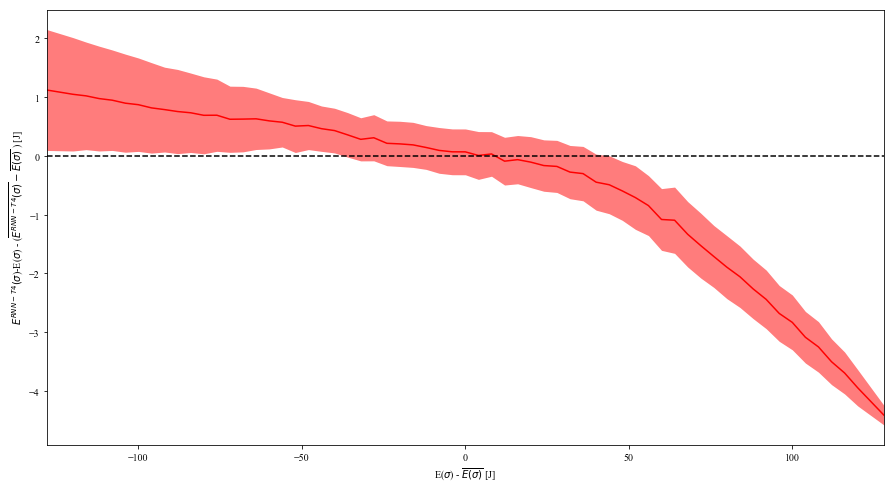

None
T=4, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SBISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SBISING1/model.ckpt-192000
8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SBISING1/model.ckpt-192000
[[-1.  1.  1.  1. -1.  1.  1.  1.]
 [-1. -1. -1.  1. -1. -1. -1. -1.]
 [-1.  1.  1.  1.  1. -1. -1.  1.]
 [ 1. -1. -1.  1.  1. -1. -1.  1.]
 [-1. -1. -1.  1.  1. -1. -1. -1.]
 [ 1. -1. -1.  1. -1.  1.  1.  1.]
 [-1. -1.  1.  1. -1. -1.  1.  1.]
 [-1. -1.  1. -1. -1.  1. -1.  1.]]
---------------------------------- 0.4166666666666667 ----------------------------------
[[-1.  1.  1. -1. -1. -1.  1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [ 1. -1.  1. -1. -1. -1. -1. -1.]
 [-1. -1.  1.  1.  1. -1. -1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1. -1.]
 [ 1. -1.  1. -1.  1. -1.  1. -1.]
 [-1.  1.  1.  1. -1.  1. -1. -1.]
 [ 1.  1. -1.  1.  1. -1.  1. -1.]]
---------------------------------- 0.8333333333333334 -------

[[ 1. -1. -1.  1.  1. -1.  1.  1.]
 [-1. -1.  1.  1.  1. -1.  1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1.  1.]
 [-1.  1. -1.  1. -1. -1. -1. -1.]
 [ 1. -1.  1. -1.  1.  1. -1. -1.]
 [ 1. -1. -1. -1.  1.  1. -1.  1.]
 [-1.  1. -1. -1. -1.  1.  1.  1.]
 [ 1. -1.  1.  1. -1. -1.  1. -1.]]
---------------------------------- 9.583333333333334 ----------------------------------
[[ 1.  1. -1. -1.  1.  1.  1. -1.]
 [ 1. -1. -1.  1.  1.  1.  1.  1.]
 [-1.  1. -1.  1. -1. -1.  1.  1.]
 [ 1.  1. -1. -1.  1. -1. -1. -1.]
 [-1. -1. -1.  1. -1. -1. -1.  1.]
 [-1.  1. -1. -1.  1.  1.  1.  1.]
 [-1.  1.  1.  1. -1. -1.  1.  1.]
 [-1. -1. -1.  1. -1. -1. -1.  1.]]
---------------------------------- 10.0 ----------------------------------
[[-1. -1. -1.  1. -1.  1. -1. -1.]
 [ 1. -1. -1. -1.  1. -1. -1.  1.]
 [ 1. -1. -1. -1.  1. -1. -1.  1.]
 [ 1. -1. -1.  1. -1. -1. -1. -1.]
 [ 1. -1.  1. -1.  1. -1. -1. -1.]
 [-1.  1. -1. -1. -1.  1. -1.  1.]
 [ 1. -1.  1.  1. -1.  1.  1. -1.]
 [-1. -1. -1. -1. -1.  1. -1. 

[[ 1.  1.  1.  1. -1.  1.  1.  1.]
 [-1. -1. -1.  1. -1. -1.  1.  1.]
 [ 1.  1.  1. -1. -1. -1.  1. -1.]
 [ 1.  1.  1. -1. -1. -1. -1.  1.]
 [ 1.  1. -1.  1. -1.  1. -1. -1.]
 [-1.  1.  1. -1.  1.  1.  1.  1.]
 [-1. -1. -1. -1.  1.  1.  1.  1.]
 [ 1. -1.  1. -1. -1. -1. -1.  1.]]
---------------------------------- 19.166666666666668 ----------------------------------
[[-1.  1.  1. -1. -1. -1. -1. -1.]
 [-1.  1. -1. -1.  1.  1.  1.  1.]
 [-1.  1. -1. -1.  1.  1. -1. -1.]
 [ 1. -1. -1. -1.  1.  1.  1.  1.]
 [ 1. -1.  1.  1.  1.  1. -1.  1.]
 [ 1.  1.  1.  1.  1. -1.  1.  1.]
 [-1.  1.  1.  1. -1. -1.  1. -1.]
 [ 1. -1. -1. -1.  1. -1. -1. -1.]]
---------------------------------- 19.583333333333332 ----------------------------------
[[ 1.  1.  1. -1. -1.  1. -1. -1.]
 [-1.  1. -1.  1.  1. -1. -1.  1.]
 [ 1.  1.  1. -1. -1. -1. -1.  1.]
 [-1. -1.  1. -1. -1. -1.  1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1. -1. -1.  1. -1. -1.  1. -1.]
 [-1.  1.  1.  1. -1.  1. -1. -1.]
 [ 1.  1. -1. -

[[-1. -1.  1.  1. -1. -1. -1.  1.]
 [ 1.  1.  1. -1.  1.  1.  1. -1.]
 [-1. -1. -1. -1.  1. -1.  1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [ 1. -1.  1.  1. -1.  1. -1. -1.]
 [-1.  1. -1.  1. -1.  1.  1. -1.]
 [-1.  1. -1.  1. -1. -1. -1.  1.]
 [ 1. -1. -1. -1.  1. -1.  1.  1.]]
---------------------------------- 28.749999999999996 ----------------------------------
[[-1. -1.  1.  1.  1.  1. -1.  1.]
 [ 1. -1.  1.  1. -1.  1. -1.  1.]
 [ 1.  1. -1. -1. -1. -1.  1. -1.]
 [ 1. -1. -1. -1. -1.  1.  1. -1.]
 [-1.  1.  1. -1.  1. -1.  1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [ 1. -1.  1. -1.  1. -1.  1.  1.]
 [ 1.  1.  1. -1. -1.  1. -1. -1.]]
---------------------------------- 29.166666666666668 ----------------------------------
[[-1. -1.  1.  1.  1. -1.  1.  1.]
 [ 1.  1. -1. -1. -1.  1.  1.  1.]
 [-1. -1. -1.  1.  1.  1. -1. -1.]
 [ 1. -1. -1.  1. -1.  1.  1. -1.]
 [-1.  1. -1. -1. -1.  1.  1.  1.]
 [ 1.  1. -1. -1. -1. -1.  1. -1.]
 [ 1.  1. -1. -1. -1.  1.  1.  1.]
 [ 1. -1.  1. -

[[ 1. -1. -1. -1.  1.  1.  1.  1.]
 [-1.  1.  1. -1.  1. -1.  1.  1.]
 [ 1.  1.  1.  1. -1. -1.  1.  1.]
 [ 1. -1. -1.  1. -1. -1. -1.  1.]
 [ 1. -1.  1.  1. -1.  1.  1. -1.]
 [ 1.  1. -1. -1. -1.  1.  1.  1.]
 [-1.  1.  1.  1. -1. -1.  1. -1.]
 [-1.  1. -1. -1. -1.  1. -1. -1.]]
---------------------------------- 38.333333333333336 ----------------------------------
[[-1. -1. -1. -1.  1.  1. -1. -1.]
 [ 1. -1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1. -1. -1.  1. -1. -1. -1.]
 [ 1.  1.  1. -1. -1. -1.  1.  1.]
 [-1. -1.  1. -1.  1. -1.  1.  1.]
 [ 1. -1.  1. -1.  1. -1.  1. -1.]
 [ 1.  1.  1.  1.  1. -1. -1. -1.]
 [-1. -1.  1. -1.  1. -1. -1.  1.]]
---------------------------------- 38.75 ----------------------------------
[[ 1.  1.  1. -1. -1.  1. -1. -1.]
 [ 1. -1. -1.  1.  1. -1.  1.  1.]
 [ 1.  1.  1. -1. -1.  1.  1. -1.]
 [ 1. -1.  1. -1.  1.  1. -1. -1.]
 [ 1.  1. -1.  1.  1. -1. -1. -1.]
 [ 1. -1. -1. -1.  1. -1. -1. -1.]
 [-1.  1. -1.  1.  1.  1. -1. -1.]
 [ 1. -1. -1. -1. -1. -1.  1

[[-1. -1. -1.  1. -1. -1. -1. -1.]
 [-1. -1.  1. -1. -1.  1. -1.  1.]
 [-1.  1. -1. -1. -1. -1.  1. -1.]
 [-1. -1.  1. -1. -1.  1. -1.  1.]
 [-1. -1.  1. -1. -1. -1. -1.  1.]
 [-1.  1. -1. -1. -1. -1. -1.  1.]
 [ 1. -1.  1. -1. -1. -1. -1. -1.]
 [ 1. -1.  1.  1.  1.  1. -1. -1.]]
---------------------------------- 47.91666666666667 ----------------------------------
[[ 1. -1.  1.  1.  1.  1. -1. -1.]
 [ 1. -1.  1.  1.  1. -1.  1. -1.]
 [-1. -1.  1. -1.  1.  1.  1.  1.]
 [ 1. -1. -1. -1.  1. -1. -1.  1.]
 [ 1. -1. -1. -1.  1. -1.  1.  1.]
 [-1. -1.  1. -1.  1.  1. -1.  1.]
 [-1.  1.  1.  1.  1.  1.  1. -1.]
 [ 1.  1. -1. -1. -1.  1.  1.  1.]]
---------------------------------- 48.333333333333336 ----------------------------------
[[-1. -1. -1.  1.  1.  1. -1. -1.]
 [-1. -1. -1.  1. -1. -1.  1.  1.]
 [ 1. -1. -1. -1.  1. -1.  1.  1.]
 [-1. -1. -1.  1. -1. -1. -1.  1.]
 [ 1. -1. -1. -1. -1.  1.  1.  1.]
 [ 1. -1. -1.  1.  1. -1. -1.  1.]
 [-1. -1. -1. -1.  1.  1.  1. -1.]
 [-1. -1. -1. -1

[[ 1. -1.  1.  1.  1. -1.  1. -1.]
 [-1.  1. -1.  1. -1. -1.  1. -1.]
 [-1.  1.  1.  1. -1.  1. -1. -1.]
 [-1.  1.  1.  1. -1.  1.  1.  1.]
 [-1.  1. -1.  1.  1. -1.  1.  1.]
 [-1. -1. -1.  1. -1.  1. -1.  1.]
 [ 1. -1. -1. -1.  1. -1.  1.  1.]
 [-1. -1.  1.  1.  1.  1. -1. -1.]]
---------------------------------- 57.49999999999999 ----------------------------------
[[-1.  1.  1.  1. -1. -1.  1. -1.]
 [ 1. -1.  1.  1.  1.  1. -1.  1.]
 [-1. -1.  1.  1.  1. -1. -1.  1.]
 [ 1.  1.  1. -1. -1.  1. -1. -1.]
 [-1.  1. -1. -1.  1.  1. -1.  1.]
 [ 1.  1.  1. -1.  1. -1.  1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1. -1.]
 [-1.  1.  1.  1.  1.  1.  1.  1.]]
---------------------------------- 57.91666666666667 ----------------------------------
[[ 1. -1. -1.  1.  1. -1.  1. -1.]
 [ 1. -1.  1.  1. -1. -1. -1. -1.]
 [-1. -1. -1. -1.  1.  1. -1.  1.]
 [-1.  1.  1. -1.  1. -1.  1. -1.]
 [-1. -1.  1.  1.  1.  1.  1. -1.]
 [ 1.  1.  1. -1.  1. -1.  1. -1.]
 [-1. -1. -1.  1. -1. -1. -1. -1.]
 [ 1. -1.  1. -1.

[[-1. -1.  1. -1.  1.  1.  1.  1.]
 [ 1.  1. -1. -1. -1.  1.  1. -1.]
 [-1.  1.  1.  1.  1.  1.  1.  1.]
 [-1. -1.  1.  1.  1. -1.  1.  1.]
 [ 1. -1. -1.  1.  1.  1.  1. -1.]
 [ 1.  1.  1. -1. -1.  1.  1. -1.]
 [-1.  1.  1. -1. -1. -1. -1.  1.]
 [ 1. -1. -1. -1.  1.  1.  1.  1.]]
---------------------------------- 67.08333333333333 ----------------------------------
[[-1. -1. -1. -1.  1.  1.  1.  1.]
 [ 1. -1.  1.  1. -1.  1.  1.  1.]
 [-1.  1. -1.  1.  1.  1.  1. -1.]
 [-1.  1. -1.  1. -1.  1.  1.  1.]
 [-1.  1. -1.  1. -1. -1.  1.  1.]
 [ 1. -1.  1. -1.  1.  1. -1.  1.]
 [-1.  1. -1.  1. -1.  1.  1.  1.]
 [-1. -1. -1.  1.  1. -1. -1. -1.]]
---------------------------------- 67.5 ----------------------------------
[[-1.  1.  1. -1.  1.  1.  1. -1.]
 [ 1. -1.  1.  1.  1. -1.  1.  1.]
 [-1. -1.  1.  1.  1. -1.  1.  1.]
 [-1. -1.  1. -1. -1. -1.  1. -1.]
 [ 1.  1.  1.  1. -1.  1. -1.  1.]
 [ 1. -1.  1. -1.  1.  1.  1. -1.]
 [-1.  1.  1.  1. -1.  1.  1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1. 

[[-1.  1.  1.  1. -1.  1. -1. -1.]
 [-1.  1. -1. -1. -1. -1. -1.  1.]
 [ 1.  1.  1. -1.  1. -1. -1. -1.]
 [ 1. -1. -1.  1. -1. -1. -1.  1.]
 [ 1.  1. -1. -1. -1.  1.  1.  1.]
 [ 1. -1. -1. -1. -1. -1. -1.  1.]
 [ 1.  1.  1. -1. -1.  1.  1.  1.]
 [ 1. -1.  1.  1.  1.  1. -1. -1.]]
---------------------------------- 76.66666666666667 ----------------------------------
[[ 1. -1. -1. -1.  1. -1. -1. -1.]
 [ 1.  1. -1.  1.  1.  1. -1.  1.]
 [ 1. -1.  1. -1.  1. -1. -1.  1.]
 [-1. -1.  1.  1. -1. -1. -1.  1.]
 [ 1. -1. -1.  1.  1.  1.  1.  1.]
 [-1.  1. -1.  1.  1.  1. -1. -1.]
 [-1.  1.  1.  1. -1. -1. -1. -1.]
 [ 1.  1.  1. -1. -1. -1. -1.  1.]]
---------------------------------- 77.08333333333334 ----------------------------------
[[-1.  1. -1. -1.  1.  1.  1.  1.]
 [-1.  1.  1.  1.  1. -1. -1. -1.]
 [ 1. -1. -1. -1.  1.  1. -1.  1.]
 [ 1.  1. -1.  1.  1. -1. -1.  1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [ 1.  1.  1. -1. -1.  1.  1.  1.]
 [ 1. -1.  1. -1. -1.  1. -1.  1.]
 [ 1. -1.  1.  1.

[[-1.  1.  1. -1.  1.  1. -1. -1.]
 [-1.  1. -1.  1.  1.  1. -1.  1.]
 [ 1.  1.  1. -1.  1. -1. -1.  1.]
 [-1.  1.  1. -1.  1.  1.  1.  1.]
 [-1.  1. -1.  1.  1. -1.  1.  1.]
 [-1.  1.  1. -1. -1.  1.  1. -1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1. -1.  1.  1. -1.  1.  1.]]
---------------------------------- 86.25 ----------------------------------
[[ 1. -1. -1.  1.  1. -1. -1. -1.]
 [ 1. -1.  1.  1.  1. -1.  1. -1.]
 [ 1. -1. -1.  1.  1.  1.  1.  1.]
 [-1.  1. -1. -1. -1. -1.  1.  1.]
 [-1.  1.  1. -1.  1.  1. -1. -1.]
 [-1.  1. -1. -1. -1.  1.  1.  1.]
 [ 1. -1.  1.  1. -1. -1. -1.  1.]
 [-1.  1. -1.  1. -1.  1.  1. -1.]]
---------------------------------- 86.66666666666667 ----------------------------------
[[-1.  1. -1. -1.  1.  1. -1. -1.]
 [ 1.  1. -1.  1.  1.  1. -1.  1.]
 [ 1. -1.  1.  1.  1. -1. -1.  1.]
 [ 1.  1.  1. -1. -1.  1.  1. -1.]
 [-1.  1.  1. -1. -1. -1. -1.  1.]
 [ 1. -1.  1.  1.  1.  1.  1.  1.]
 [-1. -1. -1. -1. -1.  1. -1. -1.]
 [ 1.  1. -1. -1.  1.  1.  1.

[[ 1.  1.  1. -1. -1.  1.  1. -1.]
 [-1.  1. -1.  1.  1.  1.  1. -1.]
 [ 1. -1. -1.  1. -1. -1. -1. -1.]
 [ 1. -1. -1.  1. -1.  1. -1.  1.]
 [-1.  1. -1.  1. -1.  1. -1.  1.]
 [-1.  1.  1. -1.  1. -1.  1. -1.]
 [-1.  1.  1.  1.  1. -1. -1.  1.]
 [-1. -1. -1. -1. -1.  1. -1. -1.]]
---------------------------------- 95.83333333333334 ----------------------------------
[[-1. -1.  1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1. -1. -1.  1. -1.  1.]
 [ 1.  1. -1.  1.  1. -1. -1. -1.]
 [-1.  1.  1.  1. -1. -1.  1. -1.]
 [-1.  1. -1. -1.  1. -1.  1.  1.]
 [ 1. -1.  1.  1.  1. -1.  1. -1.]
 [ 1. -1. -1.  1.  1. -1.  1. -1.]
 [ 1. -1. -1. -1.  1.  1. -1.  1.]]
---------------------------------- 96.25 ----------------------------------
[[ 1. -1.  1. -1.  1.  1.  1.  1.]
 [ 1. -1.  1. -1.  1. -1.  1. -1.]
 [-1.  1.  1.  1.  1.  1. -1.  1.]
 [ 1.  1.  1.  1.  1. -1. -1.  1.]
 [-1. -1. -1.  1.  1.  1.  1.  1.]
 [-1. -1.  1. -1. -1.  1.  1. -1.]
 [-1.  1. -1.  1.  1.  1.  1. -1.]
 [ 1.  1. -1. -1.  1.  1.  1.

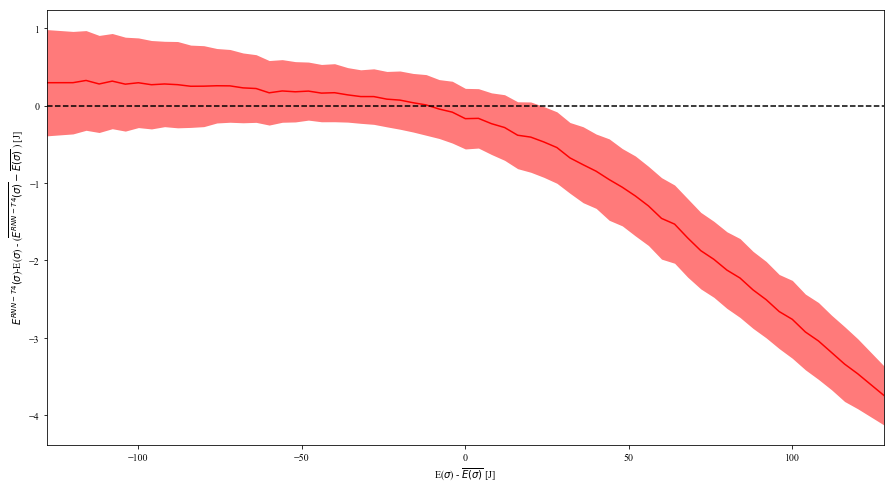

None
T=4, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SCISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SCISING1/model.ckpt-192000
8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SCISING1/model.ckpt-192000
[[-1. -1. -1. -1. -1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1.  1. -1. -1.]
 [-1.  1.  1.  1. -1. -1. -1.  1.]
 [ 1.  1.  1.  1. -1. -1. -1. -1.]
 [ 1. -1. -1.  1. -1.  1.  1. -1.]
 [ 1. -1. -1. -1. -1.  1.  1.  1.]
 [-1. -1. -1. -1.  1.  1. -1. -1.]
 [ 1. -1.  1.  1.  1.  1. -1.  1.]]
---------------------------------- 0.4166666666666667 ----------------------------------
[[ 1. -1.  1.  1. -1. -1.  1. -1.]
 [ 1. -1. -1.  1. -1. -1. -1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1. -1.]
 [ 1. -1.  1.  1. -1.  1.  1. -1.]
 [ 1. -1. -1.  1. -1.  1.  1. -1.]
 [ 1.  1.  1. -1. -1. -1. -1. -1.]
 [-1.  1. -1.  1.  1. -1. -1.  1.]
 [-1.  1.  1. -1.  1.  1.  1. -1.]]
---------------------------------- 0.8333333333333334 -------

[[-1.  1. -1. -1.  1.  1. -1. -1.]
 [ 1. -1. -1. -1.  1. -1. -1.  1.]
 [ 1. -1.  1. -1.  1. -1. -1.  1.]
 [-1. -1.  1.  1. -1. -1.  1.  1.]
 [ 1.  1. -1.  1.  1.  1. -1. -1.]
 [ 1. -1. -1. -1. -1.  1.  1. -1.]
 [-1.  1. -1.  1. -1. -1. -1.  1.]
 [ 1. -1.  1. -1.  1.  1. -1.  1.]]
---------------------------------- 9.583333333333334 ----------------------------------
[[ 1.  1.  1.  1.  1. -1.  1.  1.]
 [-1. -1. -1.  1.  1.  1.  1. -1.]
 [-1. -1. -1. -1.  1. -1.  1.  1.]
 [ 1. -1. -1. -1. -1. -1. -1.  1.]
 [-1. -1. -1. -1.  1. -1.  1. -1.]
 [ 1.  1. -1. -1.  1.  1. -1.  1.]
 [ 1. -1.  1. -1.  1.  1. -1.  1.]
 [ 1. -1.  1.  1.  1. -1. -1. -1.]]
---------------------------------- 10.0 ----------------------------------
[[-1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1. -1. -1.  1. -1.  1.  1.  1.]
 [ 1. -1.  1.  1.  1. -1. -1.  1.]
 [ 1.  1.  1. -1. -1. -1.  1.  1.]
 [-1. -1. -1.  1.  1.  1.  1.  1.]
 [-1. -1. -1.  1. -1.  1. -1. -1.]
 [ 1.  1.  1. -1. -1.  1. -1.  1.]
 [ 1. -1. -1.  1. -1.  1. -1. 

[[ 1.  1.  1. -1. -1.  1.  1. -1.]
 [ 1. -1.  1.  1.  1. -1. -1.  1.]
 [-1.  1. -1. -1. -1. -1.  1.  1.]
 [-1. -1.  1. -1.  1. -1. -1. -1.]
 [-1. -1.  1.  1. -1. -1. -1. -1.]
 [ 1.  1.  1.  1. -1.  1. -1. -1.]
 [ 1. -1. -1. -1.  1. -1.  1.  1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]]
---------------------------------- 19.166666666666668 ----------------------------------
[[ 1. -1. -1. -1.  1. -1. -1.  1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]
 [ 1. -1.  1.  1.  1. -1.  1. -1.]
 [ 1.  1.  1. -1. -1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1.  1.  1. -1.]
 [-1. -1.  1. -1.  1.  1. -1. -1.]
 [-1. -1.  1.  1. -1. -1. -1. -1.]
 [ 1. -1. -1.  1. -1. -1. -1. -1.]]
---------------------------------- 19.583333333333332 ----------------------------------
[[ 1.  1.  1. -1. -1.  1. -1.  1.]
 [-1. -1. -1. -1. -1.  1. -1.  1.]
 [ 1. -1. -1.  1.  1.  1. -1. -1.]
 [-1. -1. -1. -1. -1. -1.  1.  1.]
 [-1.  1.  1. -1. -1.  1. -1.  1.]
 [-1. -1. -1. -1.  1. -1.  1. -1.]
 [ 1. -1. -1. -1.  1.  1. -1. -1.]
 [ 1. -1. -1.  

[[-1. -1. -1. -1.  1.  1. -1. -1.]
 [ 1.  1.  1.  1. -1.  1. -1. -1.]
 [-1.  1. -1.  1. -1.  1. -1. -1.]
 [ 1. -1. -1.  1.  1. -1.  1. -1.]
 [-1.  1.  1. -1.  1.  1.  1. -1.]
 [-1. -1. -1. -1.  1. -1.  1. -1.]
 [-1. -1.  1.  1. -1. -1.  1. -1.]
 [ 1. -1. -1.  1. -1.  1.  1. -1.]]
---------------------------------- 28.749999999999996 ----------------------------------
[[ 1.  1.  1. -1.  1.  1. -1. -1.]
 [-1.  1.  1.  1.  1. -1.  1.  1.]
 [-1.  1. -1.  1. -1. -1. -1.  1.]
 [-1. -1. -1.  1. -1. -1.  1. -1.]
 [ 1. -1.  1. -1. -1. -1.  1. -1.]
 [-1. -1.  1.  1. -1. -1. -1. -1.]
 [-1. -1.  1.  1. -1. -1.  1.  1.]
 [ 1.  1.  1.  1. -1.  1. -1.  1.]]
---------------------------------- 29.166666666666668 ----------------------------------
[[-1.  1. -1. -1.  1.  1.  1. -1.]
 [ 1. -1. -1. -1. -1. -1.  1.  1.]
 [-1.  1. -1. -1.  1.  1.  1. -1.]
 [-1. -1. -1. -1.  1.  1.  1.  1.]
 [ 1. -1.  1. -1. -1. -1. -1.  1.]
 [-1. -1.  1. -1.  1.  1.  1.  1.]
 [ 1. -1. -1.  1.  1.  1. -1. -1.]
 [ 1. -1.  1. -

[[-1. -1.  1. -1. -1. -1. -1. -1.]
 [ 1. -1.  1. -1. -1.  1.  1. -1.]
 [ 1. -1.  1. -1. -1. -1.  1.  1.]
 [ 1. -1. -1.  1. -1. -1. -1. -1.]
 [ 1. -1. -1.  1. -1. -1.  1.  1.]
 [-1.  1. -1. -1.  1.  1.  1.  1.]
 [-1.  1. -1.  1. -1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1. -1.  1.  1.]]
---------------------------------- 38.333333333333336 ----------------------------------
[[ 1.  1. -1.  1.  1. -1. -1. -1.]
 [-1.  1.  1. -1.  1. -1.  1.  1.]
 [-1. -1.  1.  1. -1. -1.  1.  1.]
 [-1. -1.  1.  1.  1. -1. -1. -1.]
 [-1. -1.  1. -1.  1. -1.  1. -1.]
 [ 1.  1. -1. -1.  1. -1.  1.  1.]
 [ 1.  1. -1. -1.  1.  1. -1.  1.]
 [ 1.  1. -1.  1.  1.  1.  1. -1.]]
---------------------------------- 38.75 ----------------------------------
[[-1.  1.  1. -1. -1. -1.  1. -1.]
 [-1.  1.  1. -1. -1.  1. -1. -1.]
 [-1. -1. -1. -1.  1. -1.  1.  1.]
 [-1. -1.  1. -1. -1. -1.  1.  1.]
 [ 1. -1.  1.  1.  1.  1.  1. -1.]
 [-1. -1. -1. -1.  1.  1. -1. -1.]
 [ 1. -1.  1. -1. -1. -1. -1.  1.]
 [-1. -1. -1. -1. -1.  1.  1

[[ 1. -1.  1. -1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1.  1.  1. -1.  1.]
 [ 1.  1. -1.  1.  1.  1. -1.  1.]
 [-1.  1. -1. -1. -1.  1. -1.  1.]
 [ 1.  1.  1.  1.  1. -1. -1. -1.]
 [ 1. -1.  1. -1.  1. -1.  1. -1.]
 [ 1. -1.  1.  1.  1.  1.  1. -1.]
 [ 1.  1. -1. -1.  1.  1.  1. -1.]]
---------------------------------- 47.91666666666667 ----------------------------------
[[-1. -1. -1.  1. -1.  1.  1.  1.]
 [ 1. -1.  1. -1. -1. -1.  1.  1.]
 [-1. -1.  1. -1. -1. -1. -1. -1.]
 [ 1.  1.  1.  1. -1. -1.  1. -1.]
 [ 1. -1. -1.  1.  1. -1. -1. -1.]
 [ 1.  1.  1. -1.  1.  1.  1. -1.]
 [ 1.  1. -1. -1.  1. -1. -1.  1.]
 [ 1.  1.  1. -1. -1. -1. -1.  1.]]
---------------------------------- 48.333333333333336 ----------------------------------
[[-1.  1.  1.  1. -1.  1.  1. -1.]
 [-1. -1. -1.  1.  1.  1. -1. -1.]
 [-1.  1.  1. -1. -1.  1. -1. -1.]
 [ 1. -1.  1. -1. -1. -1.  1. -1.]
 [-1.  1.  1.  1. -1. -1. -1. -1.]
 [ 1. -1.  1.  1. -1.  1.  1.  1.]
 [-1.  1. -1.  1.  1.  1.  1. -1.]
 [-1. -1. -1. -1

[[ 1. -1.  1. -1.  1. -1.  1. -1.]
 [ 1. -1. -1. -1.  1. -1. -1. -1.]
 [ 1. -1.  1. -1. -1. -1.  1.  1.]
 [ 1. -1. -1.  1.  1.  1. -1.  1.]
 [ 1. -1.  1. -1. -1.  1.  1. -1.]
 [ 1.  1. -1.  1.  1.  1.  1. -1.]
 [-1. -1. -1.  1.  1. -1.  1. -1.]
 [-1. -1.  1. -1.  1. -1.  1. -1.]]
---------------------------------- 57.49999999999999 ----------------------------------
[[ 1.  1.  1.  1. -1. -1. -1. -1.]
 [ 1.  1. -1. -1. -1.  1.  1.  1.]
 [ 1. -1. -1.  1.  1. -1.  1.  1.]
 [-1.  1. -1.  1.  1.  1. -1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1.  1.]
 [-1.  1. -1.  1.  1. -1. -1.  1.]
 [-1. -1.  1.  1.  1. -1.  1.  1.]
 [ 1. -1.  1. -1. -1.  1.  1. -1.]]
---------------------------------- 57.91666666666667 ----------------------------------
[[ 1.  1.  1. -1.  1. -1. -1.  1.]
 [ 1.  1. -1.  1.  1. -1.  1.  1.]
 [-1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1. -1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1. -1. -1. -1.  1. -1.]
 [-1. -1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1. -1. -1. -1. -1.]
 [-1. -1. -1. -1.

[[-1. -1. -1. -1.  1. -1. -1. -1.]
 [ 1.  1. -1.  1. -1. -1.  1.  1.]
 [ 1.  1. -1. -1. -1. -1.  1.  1.]
 [ 1. -1.  1.  1. -1. -1. -1. -1.]
 [-1. -1.  1.  1.  1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1.  1.  1.  1.]
 [ 1. -1.  1. -1.  1.  1.  1.  1.]
 [ 1. -1.  1.  1.  1.  1. -1.  1.]]
---------------------------------- 67.08333333333333 ----------------------------------
[[ 1.  1.  1.  1.  1. -1.  1.  1.]
 [ 1. -1.  1. -1.  1.  1. -1. -1.]
 [ 1. -1.  1.  1.  1. -1. -1. -1.]
 [ 1. -1. -1.  1.  1.  1.  1.  1.]
 [-1. -1.  1. -1. -1.  1. -1.  1.]
 [ 1.  1. -1.  1. -1.  1.  1. -1.]
 [-1.  1.  1. -1.  1. -1. -1. -1.]
 [ 1.  1. -1.  1. -1. -1. -1. -1.]]
---------------------------------- 67.5 ----------------------------------
[[-1.  1.  1.  1.  1.  1.  1. -1.]
 [-1. -1. -1. -1. -1. -1.  1. -1.]
 [-1. -1.  1. -1.  1. -1. -1. -1.]
 [-1.  1. -1.  1.  1. -1. -1.  1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]
 [-1.  1.  1.  1. -1. -1.  1.  1.]
 [ 1. -1.  1.  1. -1.  1.  1. -1.]
 [ 1. -1. -1. -1.  1. -1. -1. 

[[-1.  1.  1. -1.  1. -1.  1.  1.]
 [ 1. -1.  1. -1.  1.  1.  1. -1.]
 [-1.  1.  1. -1.  1.  1. -1.  1.]
 [ 1.  1. -1.  1.  1. -1.  1. -1.]
 [ 1. -1.  1.  1.  1.  1. -1.  1.]
 [-1.  1.  1. -1.  1. -1. -1.  1.]
 [-1. -1. -1.  1. -1. -1.  1. -1.]
 [-1. -1.  1. -1. -1. -1.  1. -1.]]
---------------------------------- 76.66666666666667 ----------------------------------
[[ 1.  1. -1.  1. -1.  1.  1. -1.]
 [-1. -1. -1.  1. -1.  1.  1. -1.]
 [-1.  1.  1. -1.  1.  1. -1.  1.]
 [ 1.  1. -1. -1. -1. -1.  1. -1.]
 [ 1. -1.  1. -1. -1.  1.  1. -1.]
 [ 1. -1. -1.  1.  1.  1. -1. -1.]
 [ 1.  1. -1.  1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]]
---------------------------------- 77.08333333333334 ----------------------------------
[[ 1. -1. -1.  1.  1.  1.  1.  1.]
 [ 1. -1.  1. -1. -1.  1. -1. -1.]
 [ 1.  1. -1.  1. -1. -1. -1.  1.]
 [ 1. -1.  1. -1. -1.  1.  1. -1.]
 [-1. -1.  1. -1. -1. -1.  1.  1.]
 [-1. -1. -1. -1.  1.  1.  1. -1.]
 [ 1.  1.  1. -1.  1. -1. -1.  1.]
 [ 1. -1.  1. -1.

[[-1.  1.  1.  1.  1. -1.  1. -1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [ 1.  1. -1. -1.  1. -1.  1. -1.]
 [ 1. -1.  1. -1. -1.  1. -1. -1.]
 [-1. -1. -1. -1. -1.  1. -1. -1.]
 [ 1. -1. -1. -1.  1. -1.  1.  1.]
 [ 1. -1.  1.  1.  1. -1.  1.  1.]
 [-1. -1. -1.  1.  1.  1. -1.  1.]]
---------------------------------- 86.25 ----------------------------------
[[-1.  1. -1.  1.  1. -1. -1.  1.]
 [ 1.  1. -1.  1. -1. -1. -1. -1.]
 [ 1.  1.  1.  1. -1. -1. -1. -1.]
 [-1.  1. -1.  1. -1.  1. -1. -1.]
 [-1.  1. -1.  1. -1.  1. -1.  1.]
 [ 1. -1.  1.  1.  1. -1. -1.  1.]
 [ 1.  1.  1.  1.  1. -1. -1. -1.]
 [ 1. -1.  1.  1. -1.  1. -1. -1.]]
---------------------------------- 86.66666666666667 ----------------------------------
[[ 1. -1. -1. -1. -1.  1. -1.  1.]
 [-1. -1. -1. -1.  1.  1. -1.  1.]
 [-1. -1. -1.  1. -1.  1. -1. -1.]
 [-1. -1.  1.  1.  1. -1. -1. -1.]
 [ 1. -1. -1.  1.  1.  1. -1.  1.]
 [-1. -1.  1. -1. -1.  1. -1. -1.]
 [-1. -1.  1. -1. -1. -1. -1.  1.]
 [ 1. -1.  1. -1. -1.  1.  1.

[[ 1. -1.  1. -1.  1. -1.  1. -1.]
 [-1.  1.  1. -1.  1. -1. -1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [-1.  1. -1.  1.  1. -1.  1.  1.]
 [-1.  1.  1. -1. -1. -1.  1. -1.]
 [ 1.  1. -1.  1.  1.  1.  1. -1.]
 [ 1. -1.  1.  1. -1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1. -1.  1. -1.]]
---------------------------------- 95.83333333333334 ----------------------------------
[[-1. -1. -1. -1.  1. -1. -1. -1.]
 [ 1. -1.  1.  1. -1. -1. -1. -1.]
 [-1.  1. -1.  1.  1. -1. -1. -1.]
 [ 1.  1.  1. -1. -1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1. -1. -1.  1.]
 [-1. -1.  1.  1.  1.  1.  1. -1.]
 [-1.  1. -1. -1.  1. -1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1. -1. -1.]]
---------------------------------- 96.25 ----------------------------------
[[-1. -1.  1. -1. -1. -1. -1. -1.]
 [ 1. -1. -1. -1.  1. -1.  1.  1.]
 [ 1. -1. -1.  1.  1. -1. -1.  1.]
 [-1. -1. -1. -1.  1. -1. -1.  1.]
 [ 1.  1. -1. -1. -1. -1. -1. -1.]
 [-1. -1.  1. -1.  1.  1. -1.  1.]
 [-1.  1.  1. -1.  1.  1.  1.  1.]
 [-1.  1.  1. -1.  1.  1.  1.

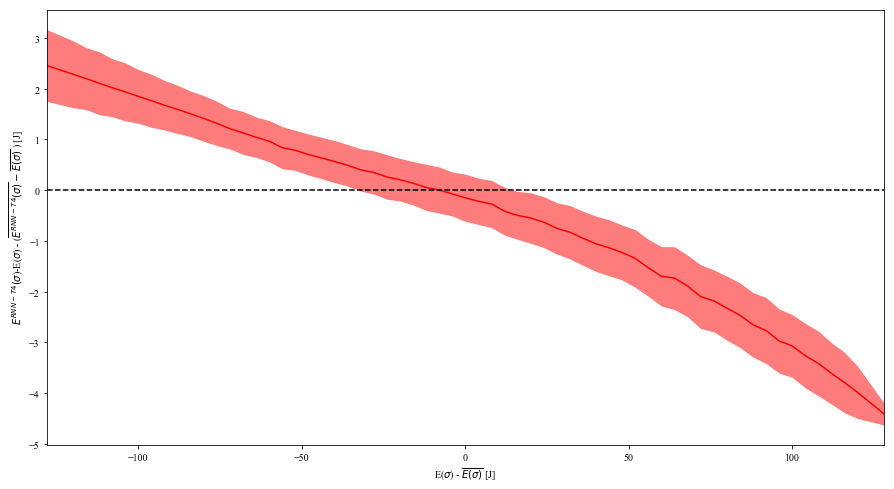

None
T=4, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SDISING1/model.ckpt-186899
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SDISING1/model.ckpt-186899
8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SDISING1/model.ckpt-186899
[[ 1.  1. -1. -1.  1. -1.  1.  1.]
 [-1. -1. -1. -1. -1.  1. -1. -1.]
 [ 1. -1.  1. -1. -1. -1. -1. -1.]
 [ 1.  1. -1. -1. -1. -1. -1. -1.]
 [ 1. -1.  1.  1. -1. -1. -1. -1.]
 [ 1.  1. -1. -1. -1.  1.  1. -1.]
 [-1.  1.  1. -1. -1.  1. -1.  1.]
 [-1.  1. -1. -1.  1. -1. -1.  1.]]
---------------------------------- 0.4166666666666667 ----------------------------------
[[ 1.  1. -1. -1. -1.  1. -1.  1.]
 [-1.  1. -1.  1.  1. -1. -1.  1.]
 [-1. -1. -1. -1.  1.  1. -1. -1.]
 [-1.  1. -1.  1.  1. -1. -1.  1.]
 [-1.  1. -1. -1. -1.  1. -1.  1.]
 [-1. -1.  1.  1. -1. -1. -1. -1.]
 [ 1. -1.  1. -1. -1.  1. -1. -1.]
 [ 1. -1. -1.  1.  1. -1. -1.  1.]]
---------------------------------- 0.8333333333333334 -------

[[-1.  1.  1. -1. -1. -1. -1. -1.]
 [-1.  1. -1. -1. -1.  1. -1.  1.]
 [ 1.  1.  1. -1. -1. -1.  1.  1.]
 [-1.  1.  1.  1. -1.  1. -1. -1.]
 [ 1.  1. -1. -1. -1.  1. -1.  1.]
 [-1.  1. -1. -1. -1. -1.  1.  1.]
 [-1. -1.  1. -1. -1.  1. -1. -1.]
 [-1.  1.  1. -1. -1. -1.  1.  1.]]
---------------------------------- 9.583333333333334 ----------------------------------
[[-1.  1. -1. -1.  1.  1.  1.  1.]
 [ 1. -1. -1.  1.  1. -1. -1.  1.]
 [ 1. -1.  1. -1. -1. -1.  1. -1.]
 [ 1. -1. -1. -1. -1. -1. -1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1. -1.  1.  1. -1. -1.]
 [-1.  1. -1. -1.  1.  1. -1.  1.]
 [-1.  1.  1.  1. -1. -1. -1. -1.]]
---------------------------------- 10.0 ----------------------------------
[[ 1. -1.  1.  1.  1. -1. -1. -1.]
 [-1. -1.  1. -1.  1.  1.  1. -1.]
 [-1.  1.  1. -1.  1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1. -1.  1. -1.]
 [-1.  1. -1.  1.  1.  1.  1. -1.]
 [-1.  1.  1. -1. -1. -1.  1. -1.]
 [-1.  1.  1. -1. -1.  1.  1. -1.]
 [ 1. -1.  1. -1. -1.  1.  1. 

[[-1. -1.  1. -1. -1. -1. -1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1. -1.  1.  1.  1. -1. -1.]
 [-1. -1.  1.  1.  1.  1. -1. -1.]
 [ 1.  1. -1.  1. -1. -1. -1. -1.]
 [ 1.  1. -1. -1. -1. -1.  1. -1.]
 [-1.  1. -1.  1. -1. -1.  1. -1.]
 [-1. -1.  1. -1. -1. -1. -1.  1.]]
---------------------------------- 19.166666666666668 ----------------------------------
[[-1.  1.  1. -1. -1.  1.  1. -1.]
 [-1.  1.  1.  1. -1.  1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1.  1. -1.  1.  1. -1.  1.]
 [-1. -1.  1.  1.  1.  1. -1.  1.]
 [ 1.  1.  1. -1. -1.  1. -1. -1.]
 [ 1.  1.  1.  1.  1.  1. -1.  1.]
 [-1.  1. -1.  1.  1.  1.  1.  1.]]
---------------------------------- 19.583333333333332 ----------------------------------
[[ 1. -1. -1. -1.  1.  1.  1. -1.]
 [-1.  1. -1. -1.  1. -1.  1.  1.]
 [ 1.  1. -1.  1.  1.  1.  1. -1.]
 [ 1. -1. -1. -1. -1.  1. -1. -1.]
 [-1. -1. -1. -1. -1.  1.  1.  1.]
 [-1. -1. -1.  1.  1. -1. -1.  1.]
 [ 1. -1.  1.  1. -1. -1. -1.  1.]
 [-1.  1.  1.  

[[ 1. -1.  1.  1. -1. -1.  1.  1.]
 [-1.  1.  1. -1.  1. -1. -1.  1.]
 [-1. -1.  1. -1.  1. -1.  1. -1.]
 [ 1. -1. -1. -1.  1. -1. -1. -1.]
 [ 1.  1.  1.  1. -1. -1. -1.  1.]
 [ 1.  1.  1. -1.  1. -1. -1.  1.]
 [ 1. -1.  1.  1. -1. -1.  1.  1.]
 [-1. -1. -1. -1.  1.  1.  1. -1.]]
---------------------------------- 28.749999999999996 ----------------------------------
[[ 1. -1. -1. -1. -1.  1. -1.  1.]
 [ 1.  1.  1.  1.  1. -1. -1. -1.]
 [-1. -1. -1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1. -1.  1. -1.  1.]
 [ 1.  1.  1. -1.  1.  1.  1.  1.]
 [-1.  1. -1.  1. -1.  1.  1.  1.]
 [-1.  1.  1. -1.  1.  1. -1. -1.]
 [-1. -1.  1. -1. -1.  1.  1.  1.]]
---------------------------------- 29.166666666666668 ----------------------------------
[[-1. -1.  1. -1.  1.  1. -1.  1.]
 [-1. -1.  1. -1. -1. -1. -1. -1.]
 [ 1.  1. -1. -1. -1. -1. -1. -1.]
 [ 1. -1.  1.  1.  1. -1.  1. -1.]
 [ 1.  1.  1. -1.  1. -1.  1. -1.]
 [-1. -1.  1. -1.  1.  1. -1. -1.]
 [ 1. -1.  1. -1. -1. -1. -1.  1.]
 [-1. -1. -1. -

[[ 1. -1.  1.  1. -1.  1.  1. -1.]
 [-1.  1.  1. -1. -1.  1.  1.  1.]
 [ 1. -1.  1. -1. -1.  1. -1. -1.]
 [-1.  1.  1. -1. -1. -1. -1.  1.]
 [-1. -1.  1. -1. -1. -1.  1. -1.]
 [ 1. -1.  1.  1. -1. -1. -1.  1.]
 [ 1.  1. -1.  1.  1. -1. -1. -1.]
 [-1.  1.  1.  1.  1. -1.  1.  1.]]
---------------------------------- 38.333333333333336 ----------------------------------
[[-1.  1.  1.  1. -1. -1.  1. -1.]
 [ 1.  1. -1.  1.  1.  1. -1. -1.]
 [-1.  1. -1.  1. -1.  1. -1.  1.]
 [-1. -1. -1. -1.  1.  1. -1. -1.]
 [-1.  1.  1. -1. -1. -1. -1. -1.]
 [ 1.  1. -1.  1. -1. -1. -1. -1.]
 [ 1. -1.  1. -1. -1. -1. -1. -1.]
 [-1.  1.  1.  1. -1.  1. -1. -1.]]
---------------------------------- 38.75 ----------------------------------
[[ 1. -1. -1.  1.  1. -1. -1.  1.]
 [ 1. -1.  1. -1. -1.  1.  1.  1.]
 [ 1.  1.  1. -1. -1. -1. -1.  1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [ 1. -1. -1.  1.  1.  1. -1.  1.]
 [ 1. -1.  1. -1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1. -1. -1. -1. -1.  1

[[-1.  1. -1.  1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]
 [ 1.  1.  1.  1.  1. -1. -1. -1.]
 [-1. -1. -1.  1. -1. -1.  1.  1.]
 [ 1. -1.  1.  1.  1.  1. -1.  1.]
 [-1. -1. -1. -1. -1.  1.  1.  1.]
 [-1.  1. -1.  1. -1.  1. -1. -1.]
 [ 1. -1. -1. -1.  1. -1.  1.  1.]]
---------------------------------- 47.91666666666667 ----------------------------------
[[ 1.  1. -1.  1.  1. -1.  1.  1.]
 [-1.  1. -1.  1.  1. -1. -1.  1.]
 [-1.  1.  1. -1. -1. -1. -1. -1.]
 [-1.  1.  1. -1. -1. -1. -1. -1.]
 [ 1.  1.  1. -1. -1.  1. -1. -1.]
 [ 1.  1.  1.  1. -1.  1. -1.  1.]
 [-1. -1.  1.  1. -1.  1.  1. -1.]
 [-1.  1. -1.  1. -1. -1.  1. -1.]]
---------------------------------- 48.333333333333336 ----------------------------------
[[-1.  1. -1.  1. -1.  1.  1. -1.]
 [-1.  1. -1.  1. -1.  1. -1. -1.]
 [ 1. -1.  1. -1. -1. -1.  1.  1.]
 [ 1. -1.  1. -1. -1. -1. -1.  1.]
 [ 1. -1. -1.  1.  1.  1.  1.  1.]
 [-1.  1. -1. -1.  1.  1. -1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1. -1.]
 [-1.  1. -1. -1

[[ 1. -1.  1. -1.  1.  1.  1. -1.]
 [ 1.  1. -1. -1.  1. -1.  1.  1.]
 [ 1. -1.  1. -1.  1.  1.  1.  1.]
 [ 1. -1. -1.  1. -1.  1. -1.  1.]
 [-1.  1. -1.  1.  1. -1. -1.  1.]
 [-1.  1. -1. -1.  1.  1.  1. -1.]
 [ 1.  1.  1. -1.  1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1.  1.  1.  1.]]
---------------------------------- 57.49999999999999 ----------------------------------
[[-1. -1. -1.  1. -1.  1. -1. -1.]
 [-1. -1.  1.  1. -1.  1.  1. -1.]
 [ 1.  1. -1.  1.  1.  1. -1.  1.]
 [-1. -1. -1. -1. -1.  1. -1. -1.]
 [-1. -1.  1. -1.  1. -1. -1. -1.]
 [-1.  1. -1.  1.  1.  1. -1. -1.]
 [-1. -1. -1.  1. -1.  1. -1. -1.]
 [-1.  1.  1. -1.  1. -1.  1. -1.]]
---------------------------------- 57.91666666666667 ----------------------------------
[[-1.  1.  1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1. -1.  1.  1. -1.  1.]
 [-1. -1.  1.  1. -1.  1. -1. -1.]
 [-1. -1.  1. -1.  1.  1. -1. -1.]
 [-1. -1.  1.  1.  1.  1. -1. -1.]
 [-1.  1. -1. -1.  1. -1.  1. -1.]
 [ 1.  1.  1.  1.  1. -1.  1.  1.]
 [-1.  1.  1.  1.

[[ 1. -1. -1.  1.  1.  1.  1. -1.]
 [-1. -1. -1. -1.  1. -1. -1.  1.]
 [ 1.  1. -1.  1. -1.  1.  1. -1.]
 [-1. -1. -1. -1.  1.  1. -1. -1.]
 [-1. -1. -1. -1.  1. -1.  1. -1.]
 [ 1.  1.  1. -1.  1.  1.  1.  1.]
 [ 1. -1.  1. -1. -1.  1. -1.  1.]
 [ 1. -1.  1. -1. -1.  1.  1.  1.]]
---------------------------------- 67.08333333333333 ----------------------------------
[[ 1. -1. -1.  1. -1.  1. -1. -1.]
 [-1.  1. -1.  1. -1. -1. -1.  1.]
 [-1. -1. -1. -1. -1.  1.  1. -1.]
 [ 1. -1.  1.  1.  1. -1. -1. -1.]
 [-1. -1.  1. -1. -1. -1. -1.  1.]
 [ 1. -1. -1. -1.  1.  1.  1. -1.]
 [ 1. -1. -1.  1. -1. -1.  1. -1.]
 [ 1. -1.  1. -1. -1.  1.  1.  1.]]
---------------------------------- 67.5 ----------------------------------
[[-1.  1.  1.  1.  1. -1.  1.  1.]
 [-1.  1.  1.  1. -1. -1. -1.  1.]
 [ 1.  1. -1.  1. -1.  1.  1.  1.]
 [-1.  1. -1.  1.  1. -1. -1.  1.]
 [-1.  1.  1. -1. -1. -1. -1. -1.]
 [ 1.  1. -1.  1. -1. -1.  1. -1.]
 [ 1.  1.  1. -1. -1. -1. -1.  1.]
 [-1. -1. -1. -1.  1. -1. -1. 

[[ 1.  1. -1. -1. -1. -1. -1.  1.]
 [ 1.  1.  1. -1. -1. -1.  1. -1.]
 [-1. -1. -1.  1. -1.  1. -1.  1.]
 [-1.  1. -1.  1.  1. -1. -1. -1.]
 [ 1. -1.  1.  1. -1. -1.  1.  1.]
 [-1.  1. -1. -1.  1.  1. -1. -1.]
 [-1. -1.  1. -1. -1. -1. -1. -1.]
 [ 1.  1. -1.  1. -1. -1. -1. -1.]]
---------------------------------- 76.66666666666667 ----------------------------------
[[-1. -1. -1. -1. -1.  1.  1.  1.]
 [-1.  1. -1.  1. -1.  1. -1. -1.]
 [ 1.  1.  1.  1.  1.  1. -1. -1.]
 [-1.  1.  1. -1. -1. -1.  1. -1.]
 [-1. -1. -1.  1. -1. -1. -1. -1.]
 [-1. -1. -1.  1. -1.  1.  1.  1.]
 [-1. -1.  1.  1.  1.  1. -1.  1.]
 [-1. -1. -1.  1. -1. -1.  1. -1.]]
---------------------------------- 77.08333333333334 ----------------------------------
[[-1.  1.  1.  1.  1. -1.  1.  1.]
 [-1.  1. -1.  1. -1. -1. -1.  1.]
 [ 1. -1. -1.  1.  1.  1.  1.  1.]
 [ 1. -1. -1.  1.  1.  1. -1.  1.]
 [ 1. -1.  1. -1. -1. -1.  1.  1.]
 [-1.  1.  1.  1. -1.  1.  1.  1.]
 [-1.  1. -1.  1.  1.  1. -1. -1.]
 [-1.  1.  1.  1.

[[ 1.  1. -1. -1. -1.  1. -1.  1.]
 [ 1. -1.  1.  1. -1. -1.  1.  1.]
 [-1. -1.  1. -1.  1.  1.  1. -1.]
 [ 1. -1.  1. -1. -1.  1. -1. -1.]
 [-1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1. -1.  1. -1.  1. -1.  1. -1.]
 [ 1. -1.  1.  1. -1.  1. -1.  1.]
 [ 1. -1. -1.  1.  1.  1.  1. -1.]]
---------------------------------- 86.25 ----------------------------------
[[ 1. -1. -1. -1. -1. -1.  1.  1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1.  1.  1. -1. -1.  1.  1.  1.]
 [ 1.  1. -1.  1.  1. -1. -1.  1.]
 [ 1. -1. -1.  1.  1.  1. -1.  1.]
 [ 1. -1. -1. -1. -1.  1.  1. -1.]
 [ 1. -1. -1. -1.  1.  1.  1.  1.]
 [ 1.  1. -1.  1.  1. -1.  1. -1.]]
---------------------------------- 86.66666666666667 ----------------------------------
[[-1. -1. -1. -1.  1.  1.  1.  1.]
 [-1. -1.  1.  1.  1.  1. -1.  1.]
 [-1.  1.  1.  1. -1.  1.  1. -1.]
 [-1. -1. -1.  1.  1. -1. -1.  1.]
 [-1.  1.  1.  1. -1. -1. -1. -1.]
 [-1. -1.  1. -1. -1. -1.  1.  1.]
 [ 1. -1.  1.  1.  1.  1. -1. -1.]
 [ 1. -1. -1.  1.  1. -1. -1.

[[-1.  1.  1.  1.  1.  1. -1.  1.]
 [-1. -1. -1. -1. -1.  1. -1.  1.]
 [-1.  1.  1. -1.  1. -1.  1. -1.]
 [-1.  1. -1. -1.  1.  1. -1. -1.]
 [-1.  1.  1. -1.  1.  1.  1. -1.]
 [-1. -1. -1.  1.  1.  1. -1.  1.]
 [ 1. -1.  1.  1. -1. -1. -1. -1.]
 [-1.  1.  1.  1.  1. -1. -1. -1.]]
---------------------------------- 95.83333333333334 ----------------------------------
[[-1.  1.  1. -1. -1. -1.  1. -1.]
 [ 1.  1.  1. -1.  1.  1. -1. -1.]
 [-1. -1. -1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1. -1. -1. -1.  1. -1.]
 [-1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1. -1. -1.  1. -1.  1.  1.]
 [ 1.  1. -1. -1. -1. -1. -1. -1.]
 [ 1. -1. -1. -1.  1.  1. -1. -1.]]
---------------------------------- 96.25 ----------------------------------
[[ 1. -1. -1. -1. -1. -1.  1. -1.]
 [-1.  1.  1. -1. -1.  1. -1.  1.]
 [-1.  1. -1.  1. -1.  1. -1. -1.]
 [-1. -1.  1.  1.  1.  1.  1. -1.]
 [-1. -1. -1.  1. -1. -1. -1. -1.]
 [-1. -1. -1.  1. -1.  1.  1.  1.]
 [-1.  1. -1. -1. -1.  1.  1.  1.]
 [ 1.  1.  1. -1.  1.  1. -1.

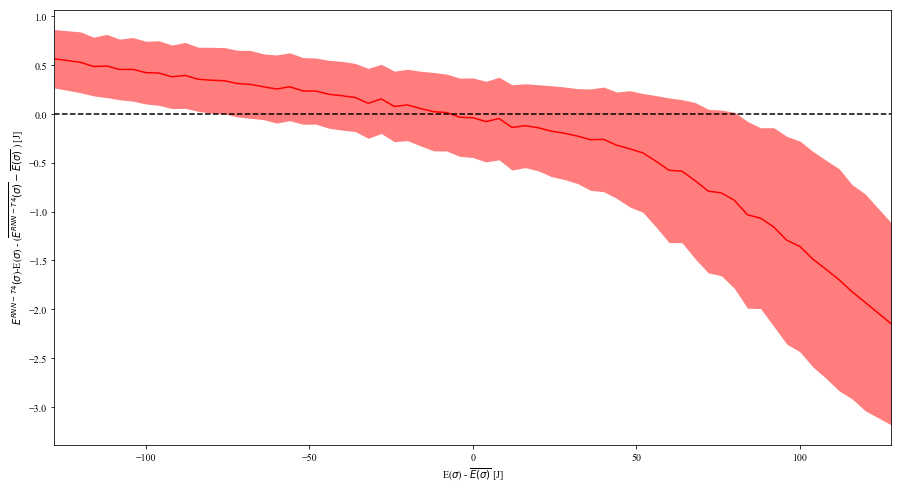

None
T=4, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SEISING1/model.ckpt-189497
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SEISING1/model.ckpt-189497
8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SEISING1/model.ckpt-189497
[[-1.  1. -1.  1.  1. -1. -1. -1.]
 [-1. -1. -1.  1.  1.  1. -1. -1.]
 [ 1. -1. -1. -1.  1.  1. -1. -1.]
 [-1. -1.  1. -1. -1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1. -1. -1.  1.]
 [-1. -1. -1. -1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1. -1.  1. -1.  1.  1.  1.  1.]]
---------------------------------- 0.4166666666666667 ----------------------------------
[[-1. -1.  1.  1.  1.  1.  1.  1.]
 [-1.  1. -1.  1.  1.  1. -1. -1.]
 [-1.  1. -1. -1.  1. -1. -1. -1.]
 [ 1. -1.  1. -1.  1.  1.  1. -1.]
 [-1.  1.  1. -1. -1.  1.  1. -1.]
 [-1.  1.  1.  1. -1. -1. -1.  1.]
 [ 1.  1. -1.  1.  1.  1. -1. -1.]
 [-1. -1. -1.  1. -1.  1. -1.  1.]]
---------------------------------- 0.8333333333333334 -------

[[ 1. -1.  1. -1.  1.  1.  1. -1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [-1. -1.  1. -1.  1.  1.  1.  1.]
 [-1.  1. -1.  1. -1. -1.  1.  1.]
 [-1. -1.  1.  1.  1. -1. -1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1. -1.]
 [-1.  1. -1. -1. -1.  1.  1. -1.]
 [ 1. -1.  1. -1. -1. -1. -1. -1.]]
---------------------------------- 9.583333333333334 ----------------------------------
[[-1.  1.  1.  1.  1.  1.  1.  1.]
 [-1.  1. -1. -1. -1. -1.  1.  1.]
 [-1.  1. -1.  1. -1.  1. -1. -1.]
 [-1.  1. -1.  1.  1. -1.  1.  1.]
 [ 1. -1. -1.  1.  1. -1. -1. -1.]
 [ 1. -1.  1.  1.  1. -1. -1.  1.]
 [-1.  1.  1. -1.  1. -1. -1.  1.]
 [-1. -1.  1. -1.  1. -1.  1.  1.]]
---------------------------------- 10.0 ----------------------------------
[[ 1. -1.  1.  1.  1. -1. -1.  1.]
 [ 1. -1.  1. -1. -1.  1.  1. -1.]
 [-1. -1.  1.  1.  1. -1.  1.  1.]
 [ 1. -1. -1. -1.  1. -1. -1.  1.]
 [-1.  1.  1.  1.  1. -1.  1. -1.]
 [ 1.  1.  1.  1. -1. -1. -1. -1.]
 [-1.  1. -1.  1. -1. -1. -1. -1.]
 [ 1. -1.  1. -1.  1.  1. -1. 

[[ 1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1.  1. -1.  1. -1.  1.  1.]
 [ 1. -1. -1.  1.  1.  1. -1. -1.]
 [-1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1. -1.  1.  1. -1.  1. -1.  1.]
 [ 1. -1.  1.  1. -1. -1. -1.  1.]
 [ 1. -1. -1.  1. -1.  1. -1. -1.]
 [ 1.  1. -1. -1. -1.  1.  1.  1.]]
---------------------------------- 19.166666666666668 ----------------------------------
[[ 1. -1. -1.  1.  1. -1.  1.  1.]
 [ 1. -1. -1. -1.  1. -1. -1. -1.]
 [-1.  1. -1. -1. -1. -1. -1.  1.]
 [ 1. -1. -1.  1. -1. -1.  1.  1.]
 [-1.  1. -1.  1. -1.  1.  1. -1.]
 [ 1.  1. -1. -1. -1. -1.  1. -1.]
 [-1.  1.  1. -1. -1. -1. -1.  1.]
 [-1.  1.  1.  1.  1. -1.  1. -1.]]
---------------------------------- 19.583333333333332 ----------------------------------
[[-1. -1. -1. -1. -1. -1.  1. -1.]
 [ 1. -1. -1.  1.  1. -1.  1.  1.]
 [ 1.  1.  1.  1.  1. -1.  1.  1.]
 [ 1. -1. -1. -1. -1.  1.  1. -1.]
 [ 1. -1. -1. -1.  1.  1.  1.  1.]
 [-1. -1. -1. -1.  1.  1. -1.  1.]
 [ 1.  1. -1. -1. -1.  1. -1.  1.]
 [ 1. -1.  1.  

[[-1.  1.  1. -1. -1.  1. -1.  1.]
 [ 1. -1. -1.  1.  1. -1.  1.  1.]
 [-1. -1.  1.  1.  1. -1.  1. -1.]
 [-1.  1. -1. -1.  1.  1. -1.  1.]
 [-1. -1.  1.  1. -1.  1. -1. -1.]
 [-1.  1. -1. -1. -1.  1.  1.  1.]
 [ 1.  1. -1. -1.  1.  1. -1. -1.]
 [-1. -1.  1. -1.  1.  1.  1.  1.]]
---------------------------------- 28.749999999999996 ----------------------------------
[[-1. -1.  1. -1. -1. -1. -1.  1.]
 [ 1.  1.  1.  1.  1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1.  1. -1.  1.]
 [ 1. -1. -1.  1. -1.  1. -1. -1.]
 [-1.  1.  1. -1. -1. -1.  1.  1.]
 [-1.  1. -1.  1.  1.  1.  1. -1.]
 [ 1.  1. -1.  1.  1.  1. -1. -1.]
 [ 1. -1.  1.  1. -1.  1.  1. -1.]]
---------------------------------- 29.166666666666668 ----------------------------------
[[ 1.  1.  1. -1.  1.  1.  1.  1.]
 [ 1. -1.  1. -1.  1.  1. -1.  1.]
 [ 1. -1. -1.  1. -1. -1.  1. -1.]
 [-1. -1. -1. -1.  1. -1. -1.  1.]
 [ 1. -1.  1.  1. -1. -1.  1.  1.]
 [ 1.  1. -1. -1. -1. -1. -1. -1.]
 [-1.  1.  1. -1. -1. -1.  1.  1.]
 [ 1. -1. -1.  

[[ 1. -1.  1. -1.  1. -1.  1.  1.]
 [ 1. -1.  1.  1.  1.  1.  1. -1.]
 [ 1. -1. -1.  1.  1.  1.  1.  1.]
 [-1. -1. -1.  1. -1.  1. -1.  1.]
 [-1.  1.  1.  1. -1. -1. -1. -1.]
 [ 1.  1.  1. -1.  1.  1.  1.  1.]
 [-1. -1.  1. -1. -1.  1.  1. -1.]
 [ 1.  1.  1.  1. -1. -1.  1. -1.]]
---------------------------------- 38.333333333333336 ----------------------------------
[[ 1. -1.  1. -1. -1.  1. -1.  1.]
 [ 1.  1. -1.  1.  1. -1. -1.  1.]
 [ 1. -1.  1.  1. -1. -1.  1. -1.]
 [-1.  1.  1. -1.  1. -1. -1.  1.]
 [-1.  1. -1.  1. -1. -1.  1. -1.]
 [-1.  1.  1.  1.  1.  1. -1.  1.]
 [ 1.  1. -1.  1.  1.  1.  1.  1.]
 [ 1.  1. -1. -1.  1. -1. -1.  1.]]
---------------------------------- 38.75 ----------------------------------
[[ 1. -1.  1.  1.  1.  1. -1. -1.]
 [ 1.  1. -1.  1. -1. -1. -1.  1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]
 [-1.  1. -1. -1.  1.  1. -1. -1.]
 [ 1.  1. -1. -1. -1.  1. -1.  1.]
 [ 1. -1. -1. -1. -1.  1.  1.  1.]
 [ 1. -1. -1.  1.  1.  1. -1. -1.]
 [ 1.  1.  1. -1.  1. -1.  1

[[-1. -1.  1.  1.  1. -1.  1.  1.]
 [ 1. -1. -1. -1. -1.  1. -1. -1.]
 [-1. -1.  1. -1. -1. -1. -1.  1.]
 [-1.  1.  1.  1. -1. -1.  1.  1.]
 [ 1.  1. -1. -1. -1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1.  1.  1. -1.]
 [-1. -1.  1.  1.  1.  1. -1. -1.]
 [-1. -1. -1. -1.  1.  1. -1.  1.]]
---------------------------------- 47.91666666666667 ----------------------------------
[[ 1. -1.  1.  1. -1.  1.  1. -1.]
 [ 1. -1. -1. -1.  1.  1.  1. -1.]
 [-1.  1.  1. -1.  1. -1. -1. -1.]
 [ 1.  1. -1. -1.  1.  1.  1.  1.]
 [ 1. -1. -1. -1. -1.  1.  1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]
 [-1.  1. -1. -1. -1. -1.  1. -1.]
 [-1. -1.  1. -1.  1.  1.  1.  1.]]
---------------------------------- 48.333333333333336 ----------------------------------
[[-1.  1. -1. -1.  1. -1. -1.  1.]
 [-1.  1. -1.  1.  1. -1.  1.  1.]
 [-1. -1. -1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1. -1.  1. -1.]
 [ 1.  1.  1.  1. -1. -1.  1. -1.]
 [ 1. -1.  1. -1.  1. -1. -1. -1.]
 [ 1.  1.  1.  1.  1. -1.  1. -1.]
 [-1. -1.  1. -1

[[ 1. -1. -1. -1.  1.  1.  1.  1.]
 [ 1.  1.  1. -1.  1.  1. -1. -1.]
 [ 1. -1.  1.  1. -1. -1.  1.  1.]
 [-1.  1.  1. -1. -1.  1.  1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1. -1.]
 [-1.  1.  1. -1. -1.  1. -1.  1.]
 [-1. -1.  1.  1. -1. -1.  1. -1.]
 [ 1. -1. -1.  1. -1.  1. -1. -1.]]
---------------------------------- 57.49999999999999 ----------------------------------
[[-1. -1.  1. -1. -1.  1. -1. -1.]
 [-1. -1. -1. -1. -1.  1. -1. -1.]
 [ 1.  1.  1. -1.  1.  1.  1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1.  1. -1.  1.]
 [ 1. -1.  1.  1. -1. -1.  1.  1.]
 [-1. -1. -1.  1. -1. -1. -1.  1.]
 [ 1.  1. -1.  1. -1. -1. -1. -1.]]
---------------------------------- 57.91666666666667 ----------------------------------
[[ 1. -1.  1.  1.  1.  1.  1.  1.]
 [ 1. -1.  1.  1. -1.  1. -1.  1.]
 [-1. -1. -1. -1.  1.  1.  1. -1.]
 [-1.  1. -1.  1. -1. -1.  1. -1.]
 [ 1. -1. -1.  1. -1. -1. -1. -1.]
 [-1.  1. -1. -1.  1.  1. -1. -1.]
 [ 1.  1.  1. -1. -1. -1. -1.  1.]
 [-1.  1. -1. -1.

[[ 1.  1. -1.  1. -1.  1.  1.  1.]
 [-1. -1. -1. -1. -1. -1.  1.  1.]
 [-1.  1. -1. -1.  1. -1.  1. -1.]
 [ 1.  1.  1.  1.  1. -1. -1.  1.]
 [-1.  1.  1. -1.  1. -1. -1. -1.]
 [-1. -1.  1.  1.  1. -1. -1. -1.]
 [ 1. -1.  1.  1. -1. -1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1. -1. -1.]]
---------------------------------- 67.08333333333333 ----------------------------------
[[ 1. -1. -1.  1. -1. -1.  1. -1.]
 [ 1. -1. -1. -1.  1. -1.  1.  1.]
 [-1. -1.  1.  1.  1. -1. -1.  1.]
 [ 1.  1.  1. -1. -1.  1. -1. -1.]
 [-1.  1. -1.  1. -1. -1. -1.  1.]
 [ 1. -1.  1.  1.  1.  1.  1. -1.]
 [-1.  1. -1.  1.  1. -1.  1. -1.]
 [-1. -1.  1.  1. -1.  1.  1. -1.]]
---------------------------------- 67.5 ----------------------------------
[[ 1. -1. -1. -1. -1. -1. -1. -1.]
 [ 1. -1.  1. -1. -1.  1.  1. -1.]
 [ 1. -1.  1. -1.  1.  1. -1.  1.]
 [-1. -1.  1. -1.  1. -1.  1. -1.]
 [-1. -1.  1. -1. -1.  1.  1. -1.]
 [ 1.  1. -1. -1.  1. -1.  1.  1.]
 [-1. -1. -1.  1.  1. -1.  1. -1.]
 [-1. -1.  1.  1. -1.  1.  1. 

[[ 1. -1.  1. -1.  1.  1. -1.  1.]
 [-1.  1.  1.  1. -1.  1.  1.  1.]
 [-1. -1.  1. -1. -1. -1. -1.  1.]
 [-1. -1.  1. -1.  1. -1.  1. -1.]
 [-1. -1.  1.  1.  1. -1.  1.  1.]
 [ 1. -1. -1. -1. -1.  1. -1.  1.]
 [ 1. -1. -1. -1.  1.  1. -1.  1.]
 [ 1. -1.  1. -1. -1.  1.  1. -1.]]
---------------------------------- 76.66666666666667 ----------------------------------
[[-1. -1. -1.  1.  1. -1.  1.  1.]
 [-1. -1.  1.  1. -1. -1. -1.  1.]
 [ 1.  1. -1. -1.  1. -1. -1.  1.]
 [ 1. -1. -1.  1. -1.  1. -1. -1.]
 [-1. -1. -1.  1. -1.  1.  1.  1.]
 [-1. -1. -1.  1.  1. -1. -1.  1.]
 [ 1. -1.  1.  1.  1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]]
---------------------------------- 77.08333333333334 ----------------------------------
[[-1.  1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1.  1. -1.  1. -1. -1.]
 [ 1. -1. -1. -1.  1. -1. -1.  1.]
 [ 1.  1. -1. -1.  1.  1.  1. -1.]
 [ 1. -1.  1. -1. -1. -1. -1. -1.]
 [ 1.  1. -1.  1.  1. -1.  1. -1.]
 [-1. -1. -1. -1. -1. -1.  1.  1.]
 [ 1.  1.  1.  1.

[[-1. -1. -1.  1. -1. -1. -1.  1.]
 [-1.  1.  1. -1.  1.  1. -1.  1.]
 [ 1. -1. -1. -1.  1. -1. -1.  1.]
 [ 1.  1. -1.  1. -1.  1. -1.  1.]
 [-1.  1.  1.  1.  1. -1.  1. -1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1. -1. -1.  1. -1. -1. -1.  1.]
 [-1. -1.  1. -1. -1. -1.  1. -1.]]
---------------------------------- 86.25 ----------------------------------
[[-1. -1. -1.  1. -1.  1.  1. -1.]
 [-1.  1.  1. -1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1.  1. -1.  1.]
 [-1. -1.  1. -1. -1.  1.  1. -1.]
 [ 1.  1. -1.  1.  1.  1. -1. -1.]
 [-1.  1. -1. -1.  1.  1.  1. -1.]
 [-1.  1.  1. -1.  1. -1.  1. -1.]
 [ 1. -1.  1.  1. -1.  1. -1. -1.]]
---------------------------------- 86.66666666666667 ----------------------------------
[[ 1.  1.  1.  1.  1. -1.  1.  1.]
 [-1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1. -1. -1.  1.  1. -1. -1.  1.]
 [ 1.  1. -1. -1.  1.  1. -1.  1.]
 [-1.  1.  1.  1.  1. -1.  1.  1.]
 [ 1. -1. -1. -1.  1.  1. -1. -1.]
 [-1.  1. -1. -1.  1.  1.  1. -1.]
 [ 1.  1.  1.  1. -1. -1.  1.

[[-1.  1. -1.  1. -1.  1. -1. -1.]
 [-1.  1. -1. -1.  1. -1.  1.  1.]
 [-1. -1. -1. -1. -1.  1.  1. -1.]
 [ 1.  1.  1.  1.  1.  1. -1.  1.]
 [ 1. -1.  1. -1. -1. -1.  1.  1.]
 [-1. -1.  1.  1. -1. -1. -1.  1.]
 [-1. -1.  1. -1.  1. -1.  1.  1.]
 [-1. -1.  1. -1. -1. -1. -1. -1.]]
---------------------------------- 95.83333333333334 ----------------------------------
[[ 1. -1. -1. -1.  1. -1.  1. -1.]
 [-1.  1.  1. -1. -1.  1. -1. -1.]
 [-1. -1. -1. -1. -1. -1.  1.  1.]
 [-1. -1.  1. -1.  1.  1. -1.  1.]
 [ 1. -1.  1.  1. -1.  1. -1.  1.]
 [ 1. -1.  1.  1. -1.  1.  1.  1.]
 [-1.  1. -1.  1.  1. -1. -1. -1.]
 [-1. -1.  1.  1.  1. -1.  1.  1.]]
---------------------------------- 96.25 ----------------------------------
[[-1. -1. -1.  1. -1.  1. -1. -1.]
 [-1. -1. -1.  1.  1.  1.  1. -1.]
 [-1. -1.  1.  1. -1.  1. -1. -1.]
 [-1.  1.  1.  1. -1.  1.  1.  1.]
 [-1.  1. -1. -1. -1. -1.  1. -1.]
 [ 1.  1.  1. -1.  1.  1. -1. -1.]
 [-1. -1.  1.  1.  1.  1.  1. -1.]
 [-1. -1.  1. -1. -1. -1. -1.

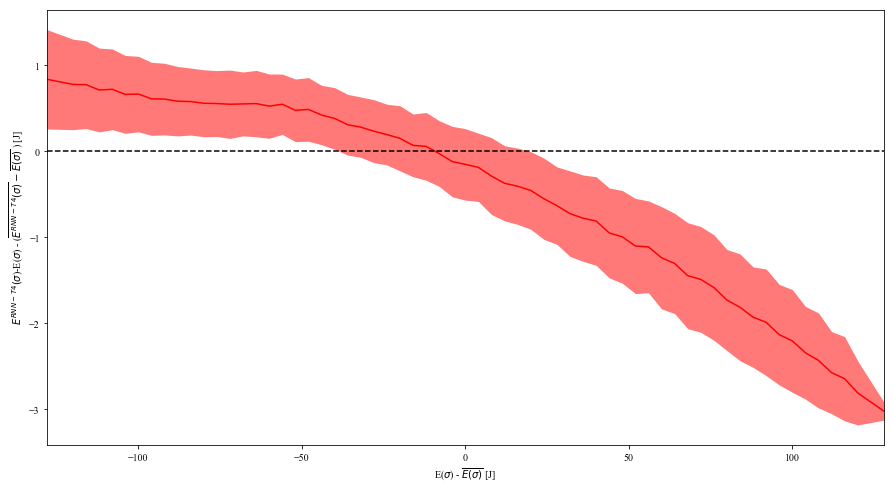

None
T=4, N=8
2000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SFISING1/model.ckpt-192000
10000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SFISING1/model.ckpt-192000
8000
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SFISING1/model.ckpt-192000
[[ 1.  1. -1. -1. -1. -1. -1.  1.]
 [-1. -1.  1. -1.  1. -1. -1. -1.]
 [-1.  1. -1.  1. -1.  1.  1. -1.]
 [ 1. -1.  1. -1.  1. -1. -1.  1.]
 [ 1. -1. -1. -1. -1.  1.  1.  1.]
 [ 1.  1. -1. -1. -1. -1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1. -1.]
 [ 1.  1. -1.  1.  1.  1. -1. -1.]]
---------------------------------- 0.4166666666666667 ----------------------------------
[[ 1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.  1. -1.  1.]
 [-1.  1. -1. -1.  1. -1. -1. -1.]
 [-1.  1.  1. -1.  1. -1. -1.  1.]
 [ 1.  1.  1. -1.  1. -1. -1.  1.]
 [ 1. -1. -1. -1. -1.  1. -1.  1.]
 [-1.  1.  1.  1. -1.  1.  1. -1.]
 [ 1.  1. -1. -1.  1. -1. -1.  1.]]
---------------------------------- 0.8333333333333334 -------

[[ 1. -1.  1. -1. -1.  1.  1.  1.]
 [-1.  1. -1.  1. -1.  1. -1. -1.]
 [-1.  1.  1. -1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1. -1.  1. -1.  1.]
 [ 1. -1. -1. -1. -1. -1. -1. -1.]
 [ 1. -1. -1. -1.  1.  1. -1.  1.]
 [-1.  1. -1. -1. -1. -1.  1. -1.]
 [-1. -1. -1.  1. -1.  1.  1. -1.]]
---------------------------------- 9.583333333333334 ----------------------------------
[[-1. -1. -1. -1.  1.  1. -1.  1.]
 [ 1. -1.  1. -1. -1. -1.  1. -1.]
 [-1. -1.  1.  1.  1.  1.  1.  1.]
 [-1.  1. -1. -1.  1.  1. -1. -1.]
 [-1. -1.  1.  1.  1. -1. -1. -1.]
 [ 1. -1. -1.  1. -1. -1. -1.  1.]
 [-1.  1.  1.  1.  1.  1. -1. -1.]
 [-1.  1.  1.  1.  1.  1.  1. -1.]]
---------------------------------- 10.0 ----------------------------------
[[ 1. -1. -1. -1.  1. -1.  1. -1.]
 [ 1.  1.  1.  1.  1. -1.  1.  1.]
 [-1.  1.  1.  1.  1.  1.  1.  1.]
 [-1.  1. -1. -1.  1.  1.  1. -1.]
 [-1.  1. -1. -1. -1.  1. -1.  1.]
 [-1.  1.  1. -1.  1. -1. -1.  1.]
 [ 1.  1. -1. -1. -1. -1. -1.  1.]
 [ 1. -1. -1.  1.  1.  1. -1. 

[[-1. -1. -1. -1.  1.  1.  1. -1.]
 [ 1.  1. -1. -1.  1. -1. -1. -1.]
 [-1.  1.  1. -1. -1.  1. -1. -1.]
 [-1. -1.  1.  1. -1.  1. -1.  1.]
 [ 1.  1. -1. -1. -1.  1. -1.  1.]
 [-1.  1. -1.  1.  1. -1.  1.  1.]
 [-1. -1.  1. -1. -1. -1. -1.  1.]
 [-1.  1. -1. -1.  1. -1.  1. -1.]]
---------------------------------- 19.166666666666668 ----------------------------------
[[-1. -1.  1.  1. -1. -1.  1.  1.]
 [ 1.  1.  1. -1. -1.  1.  1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1. -1.]
 [-1. -1. -1. -1.  1.  1.  1. -1.]
 [ 1.  1.  1. -1. -1.  1.  1. -1.]
 [-1.  1.  1.  1.  1.  1. -1. -1.]
 [ 1.  1.  1. -1. -1.  1.  1. -1.]
 [-1.  1.  1.  1.  1. -1.  1.  1.]]
---------------------------------- 19.583333333333332 ----------------------------------
[[ 1. -1.  1.  1.  1. -1.  1. -1.]
 [-1.  1.  1.  1.  1. -1. -1.  1.]
 [ 1. -1.  1.  1.  1.  1. -1. -1.]
 [ 1.  1. -1.  1.  1.  1. -1. -1.]
 [ 1.  1. -1. -1.  1.  1. -1. -1.]
 [ 1.  1.  1.  1.  1. -1. -1.  1.]
 [-1.  1.  1.  1. -1.  1. -1. -1.]
 [ 1.  1.  1.  

[[ 1.  1. -1.  1. -1. -1. -1. -1.]
 [ 1. -1.  1. -1.  1. -1. -1. -1.]
 [-1. -1.  1. -1. -1.  1. -1. -1.]
 [ 1. -1. -1. -1. -1. -1. -1. -1.]
 [ 1.  1.  1.  1.  1.  1. -1.  1.]
 [ 1.  1.  1. -1.  1. -1. -1. -1.]
 [-1.  1. -1. -1. -1.  1. -1.  1.]
 [-1.  1.  1. -1. -1.  1. -1. -1.]]
---------------------------------- 28.749999999999996 ----------------------------------
[[-1. -1.  1.  1.  1. -1.  1. -1.]
 [-1.  1. -1.  1.  1. -1. -1.  1.]
 [-1.  1.  1. -1. -1. -1.  1. -1.]
 [-1.  1.  1.  1. -1. -1.  1.  1.]
 [ 1. -1. -1. -1. -1.  1.  1. -1.]
 [ 1.  1. -1.  1. -1. -1.  1. -1.]
 [-1.  1. -1. -1.  1. -1. -1. -1.]
 [ 1. -1.  1. -1.  1.  1.  1.  1.]]
---------------------------------- 29.166666666666668 ----------------------------------
[[ 1.  1. -1. -1. -1. -1. -1. -1.]
 [ 1. -1. -1.  1.  1. -1.  1.  1.]
 [ 1.  1.  1. -1.  1. -1. -1.  1.]
 [ 1.  1. -1. -1. -1.  1.  1. -1.]
 [ 1.  1.  1. -1.  1.  1.  1. -1.]
 [-1. -1.  1. -1. -1. -1.  1. -1.]
 [ 1.  1.  1. -1. -1. -1.  1. -1.]
 [ 1.  1.  1.  

[[-1. -1. -1. -1.  1. -1. -1.  1.]
 [-1. -1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1. -1.  1.  1. -1.  1.]
 [ 1. -1. -1.  1.  1. -1. -1.  1.]
 [ 1. -1. -1. -1.  1.  1.  1.  1.]
 [ 1.  1. -1.  1.  1. -1.  1.  1.]
 [-1.  1. -1. -1.  1.  1. -1.  1.]
 [ 1. -1. -1.  1.  1.  1. -1. -1.]]
---------------------------------- 38.333333333333336 ----------------------------------
[[ 1.  1. -1.  1.  1.  1.  1. -1.]
 [-1. -1.  1.  1. -1.  1.  1. -1.]
 [ 1.  1.  1. -1.  1.  1.  1. -1.]
 [ 1. -1. -1. -1.  1. -1.  1. -1.]
 [-1. -1. -1.  1.  1. -1. -1.  1.]
 [-1.  1. -1. -1.  1.  1.  1. -1.]
 [ 1. -1.  1.  1. -1.  1.  1. -1.]
 [ 1. -1. -1. -1. -1.  1. -1.  1.]]
---------------------------------- 38.75 ----------------------------------
[[-1.  1. -1. -1.  1.  1.  1. -1.]
 [-1. -1.  1. -1.  1. -1. -1.  1.]
 [ 1.  1. -1. -1.  1.  1.  1. -1.]
 [-1. -1.  1. -1. -1. -1. -1.  1.]
 [ 1.  1.  1. -1.  1. -1.  1.  1.]
 [ 1. -1. -1. -1. -1.  1. -1.  1.]
 [-1. -1. -1. -1.  1. -1.  1. -1.]
 [ 1.  1.  1. -1.  1.  1. -1

[[ 1.  1. -1.  1.  1. -1. -1.  1.]
 [ 1.  1.  1.  1.  1. -1.  1. -1.]
 [ 1.  1.  1. -1. -1. -1.  1. -1.]
 [ 1.  1. -1. -1.  1.  1. -1.  1.]
 [ 1. -1. -1. -1. -1. -1. -1.  1.]
 [ 1.  1.  1. -1.  1. -1. -1.  1.]
 [-1. -1.  1. -1. -1. -1. -1.  1.]
 [-1.  1.  1. -1. -1. -1.  1. -1.]]
---------------------------------- 47.91666666666667 ----------------------------------
[[-1.  1. -1.  1.  1. -1. -1.  1.]
 [-1. -1. -1.  1.  1.  1. -1.  1.]
 [ 1. -1.  1. -1. -1. -1. -1. -1.]
 [-1.  1. -1.  1. -1. -1.  1.  1.]
 [ 1. -1. -1.  1. -1.  1.  1. -1.]
 [ 1.  1. -1. -1.  1. -1.  1.  1.]
 [ 1.  1.  1. -1. -1. -1.  1. -1.]
 [ 1.  1.  1.  1.  1.  1. -1. -1.]]
---------------------------------- 48.333333333333336 ----------------------------------
[[-1.  1. -1. -1. -1. -1.  1. -1.]
 [-1.  1. -1. -1. -1. -1. -1. -1.]
 [ 1. -1.  1. -1.  1. -1.  1. -1.]
 [-1. -1. -1. -1.  1. -1.  1.  1.]
 [-1.  1. -1.  1.  1. -1.  1. -1.]
 [ 1. -1. -1.  1. -1.  1. -1. -1.]
 [-1. -1. -1. -1. -1.  1.  1.  1.]
 [-1.  1.  1.  1

[[-1. -1.  1.  1. -1.  1.  1. -1.]
 [ 1. -1.  1. -1.  1. -1. -1.  1.]
 [-1.  1.  1. -1.  1. -1. -1.  1.]
 [ 1.  1. -1. -1.  1. -1.  1. -1.]
 [-1. -1. -1.  1. -1. -1.  1. -1.]
 [-1. -1. -1. -1.  1. -1.  1. -1.]
 [-1. -1. -1.  1.  1. -1. -1. -1.]
 [ 1.  1.  1. -1. -1.  1.  1. -1.]]
---------------------------------- 57.49999999999999 ----------------------------------
[[ 1.  1. -1. -1.  1.  1. -1.  1.]
 [-1.  1.  1.  1.  1.  1. -1.  1.]
 [ 1.  1.  1. -1. -1. -1. -1.  1.]
 [-1.  1.  1. -1. -1. -1.  1. -1.]
 [-1. -1. -1.  1. -1.  1. -1. -1.]
 [ 1. -1. -1.  1. -1.  1.  1.  1.]
 [-1.  1.  1. -1.  1. -1. -1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1.  1.]]
---------------------------------- 57.91666666666667 ----------------------------------
[[ 1.  1.  1.  1.  1. -1. -1.  1.]
 [ 1.  1. -1.  1.  1.  1.  1.  1.]
 [-1.  1. -1.  1. -1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1. -1.  1. -1.]
 [ 1.  1. -1. -1.  1. -1. -1. -1.]
 [ 1.  1.  1. -1. -1.  1. -1. -1.]
 [ 1. -1.  1.  1.  1.  1.  1. -1.]
 [-1.  1.  1.  1.

[[ 1.  1.  1. -1.  1. -1.  1.  1.]
 [ 1. -1. -1. -1. -1.  1.  1.  1.]
 [-1. -1.  1.  1. -1. -1. -1. -1.]
 [-1.  1.  1.  1.  1.  1. -1. -1.]
 [ 1.  1. -1.  1.  1.  1.  1.  1.]
 [ 1. -1. -1. -1.  1.  1. -1.  1.]
 [-1.  1. -1.  1.  1. -1. -1.  1.]
 [ 1.  1.  1.  1.  1. -1. -1. -1.]]
---------------------------------- 67.08333333333333 ----------------------------------
[[ 1. -1. -1.  1.  1.  1. -1.  1.]
 [-1. -1. -1. -1.  1.  1.  1. -1.]
 [-1. -1. -1. -1.  1.  1. -1. -1.]
 [-1.  1. -1. -1. -1.  1. -1. -1.]
 [-1. -1.  1.  1. -1.  1. -1. -1.]
 [-1.  1.  1.  1. -1.  1.  1.  1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]
 [ 1. -1. -1. -1.  1. -1.  1.  1.]]
---------------------------------- 67.5 ----------------------------------
[[ 1.  1.  1. -1.  1.  1. -1.  1.]
 [-1.  1. -1. -1. -1. -1.  1.  1.]
 [-1. -1. -1. -1.  1. -1.  1. -1.]
 [-1.  1.  1. -1.  1.  1.  1. -1.]
 [-1.  1. -1. -1. -1. -1.  1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1.  1.]
 [ 1. -1. -1.  1.  1. -1. -1.  1.]
 [ 1. -1.  1. -1. -1.  1.  1. 

[[-1. -1.  1.  1. -1.  1.  1. -1.]
 [ 1. -1. -1. -1. -1. -1. -1.  1.]
 [-1.  1. -1.  1.  1. -1.  1. -1.]
 [-1. -1. -1.  1. -1.  1.  1.  1.]
 [-1. -1. -1.  1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.  1.  1. -1.]
 [ 1.  1.  1.  1. -1. -1.  1.  1.]
 [-1. -1. -1. -1.  1.  1.  1. -1.]]
---------------------------------- 76.66666666666667 ----------------------------------
[[-1.  1.  1.  1. -1.  1. -1.  1.]
 [-1. -1. -1.  1. -1. -1.  1.  1.]
 [ 1.  1.  1. -1. -1. -1. -1. -1.]
 [-1.  1.  1.  1.  1. -1. -1. -1.]
 [ 1. -1. -1. -1.  1. -1. -1. -1.]
 [ 1. -1.  1. -1.  1. -1. -1. -1.]
 [-1. -1.  1. -1.  1.  1.  1. -1.]
 [ 1.  1.  1.  1.  1.  1. -1. -1.]]
---------------------------------- 77.08333333333334 ----------------------------------
[[ 1.  1.  1. -1. -1. -1. -1.  1.]
 [ 1.  1.  1. -1.  1.  1. -1. -1.]
 [ 1. -1. -1.  1.  1.  1. -1.  1.]
 [-1.  1.  1. -1.  1. -1.  1.  1.]
 [ 1.  1.  1. -1.  1.  1. -1.  1.]
 [-1.  1.  1. -1. -1.  1. -1.  1.]
 [ 1.  1. -1. -1.  1. -1. -1. -1.]
 [-1.  1. -1. -1.

[[-1. -1. -1.  1. -1. -1.  1. -1.]
 [-1.  1. -1.  1.  1. -1. -1. -1.]
 [-1. -1.  1. -1.  1. -1. -1.  1.]
 [ 1. -1. -1. -1.  1.  1. -1. -1.]
 [-1. -1.  1.  1.  1.  1. -1.  1.]
 [ 1.  1.  1.  1.  1. -1. -1. -1.]
 [-1.  1. -1.  1. -1. -1.  1.  1.]
 [-1.  1.  1. -1.  1. -1. -1. -1.]]
---------------------------------- 86.25 ----------------------------------
[[-1. -1. -1. -1.  1.  1.  1. -1.]
 [ 1. -1. -1. -1.  1.  1. -1.  1.]
 [-1. -1.  1. -1. -1.  1.  1. -1.]
 [ 1. -1.  1.  1.  1.  1. -1. -1.]
 [ 1.  1. -1.  1.  1. -1.  1. -1.]
 [ 1. -1.  1. -1. -1.  1. -1. -1.]
 [-1. -1.  1. -1. -1.  1.  1.  1.]
 [-1. -1.  1. -1.  1.  1.  1.  1.]]
---------------------------------- 86.66666666666667 ----------------------------------
[[ 1.  1.  1. -1.  1.  1. -1.  1.]
 [ 1. -1.  1.  1.  1.  1. -1. -1.]
 [-1. -1.  1. -1.  1.  1.  1.  1.]
 [ 1.  1. -1. -1.  1.  1.  1. -1.]
 [ 1.  1.  1. -1. -1. -1. -1. -1.]
 [-1.  1.  1.  1. -1.  1.  1.  1.]
 [-1.  1. -1.  1.  1. -1.  1.  1.]
 [-1.  1. -1. -1. -1.  1.  1.

[[ 1. -1.  1. -1. -1.  1. -1.  1.]
 [ 1.  1. -1. -1.  1. -1.  1.  1.]
 [-1.  1. -1. -1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1. -1. -1.  1.]
 [-1.  1. -1.  1. -1. -1. -1.  1.]
 [ 1. -1. -1. -1. -1. -1. -1.  1.]
 [-1. -1. -1.  1.  1.  1.  1. -1.]
 [-1.  1. -1. -1.  1.  1.  1. -1.]]
---------------------------------- 95.83333333333334 ----------------------------------
[[-1. -1. -1. -1.  1.  1. -1.  1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [-1. -1.  1. -1.  1. -1.  1. -1.]
 [-1. -1. -1.  1.  1. -1. -1.  1.]
 [-1.  1. -1.  1.  1. -1. -1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1.  1.]
 [-1.  1. -1.  1.  1.  1. -1.  1.]
 [ 1. -1.  1.  1.  1.  1.  1.  1.]]
---------------------------------- 96.25 ----------------------------------
[[ 1. -1.  1. -1. -1.  1. -1.  1.]
 [ 1.  1. -1. -1.  1.  1. -1.  1.]
 [ 1. -1. -1. -1.  1.  1. -1. -1.]
 [ 1.  1. -1. -1.  1. -1. -1. -1.]
 [ 1.  1.  1. -1. -1. -1. -1.  1.]
 [ 1. -1.  1. -1. -1.  1.  1.  1.]
 [ 1.  1. -1. -1. -1.  1. -1. -1.]
 [ 1.  1. -1.  1.  1.  1. -1.

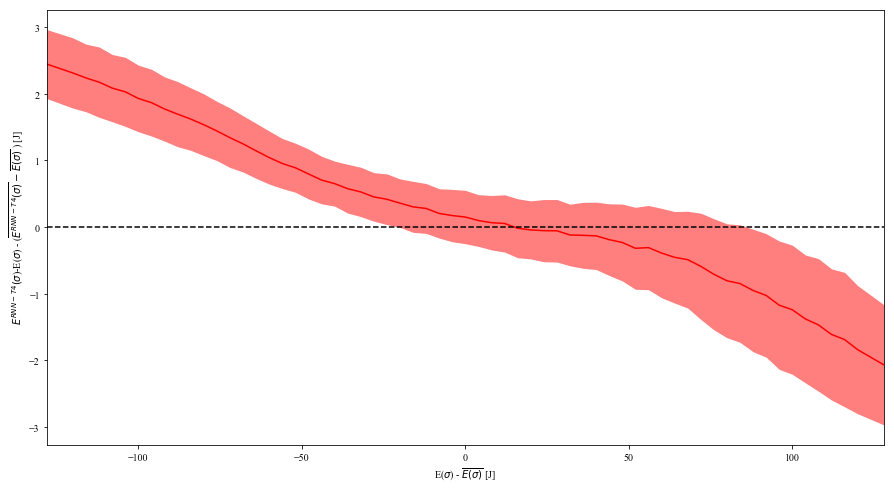

In [44]:
mild_decor=[]
model.close()
for txt in "ABCDEF":
    
    model=RNN("D:\\2020\\Export\\32S"+txt,code="",flat="SPIRAL",model="ISING1",hidden_size=378,N=8,T=4)
    model.gen_data("TD5.1/de-corrm"+txt,div=240)
    mild_decor+=[pred_bins(model.Hs,"Uniform2.h5py",bins(8))]
    deltaplt(*bin_compare(bins(8),mild_decor[-1]),"RNN-T4","r",points=False,delta=True)
    plt.show()
    model.close()

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\CORRCRITEDNNISING1/model.ckpt
-32 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 32 RMSE: 1.026450316678398


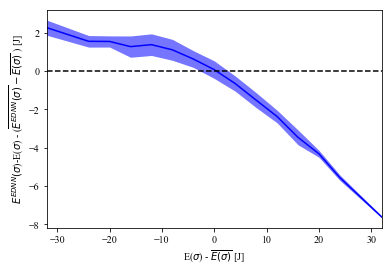

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\CRITEDNNISING1/model.ckpt


D:\Ananconda\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


-32 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 32 RMSE: 0.1687402712397192


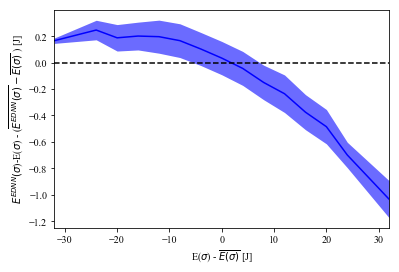

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\REDNNISING1/model.ckpt
-32 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 32 RMSE: 0.23041729495505794


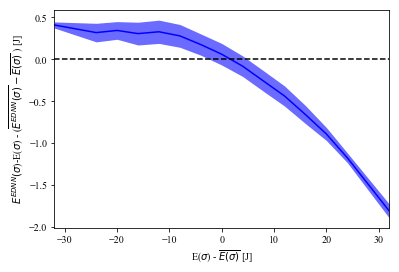

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\SEDNNISING1/model.ckpt
-32 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 32 RMSE: 0.1235824232625153


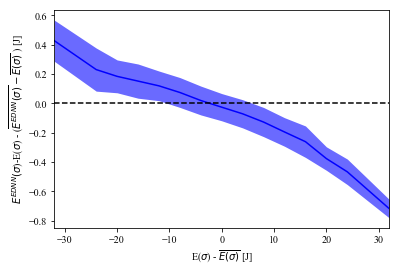

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\HEDNNISING1/model.ckpt
-32 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 32 RMSE: 0.49338411875566185


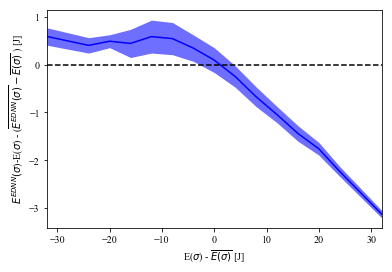

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\SHEDNNISING1/model.ckpt
-32 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 32 RMSE: 0.13941004240892152


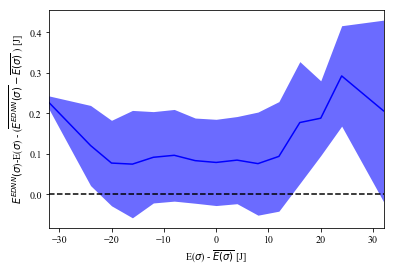

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\CORRCRITEDNNISING1/model.ckpt
-512 -504 -500 -496 -492 -488 -484 -480 -476 -472 -468 -464 -460 -456 -452 -448 -444 -440 -436 -432 -428 -424 -420 -416 -412 -408 -404 -400 -396 -392 -388 -384 -380 -376 -372 -368 -364 -360 -356 -352 -348 -344 -340 -336 -332 -328 -324 -320 -316 -312 -308 -304 -300 -296 -292 -288 -284 -280 -276 -272 -268 -264 -260 -256 -252 -248 -244 -240 -236 -232 -228 -224 -220 -216 -212 -208 -204 -200 -196 -192 -188 -184 -180 -176 -172 -168 -164 -160 -156 -152 -148 -144 -140 -136 -132 -128 -124 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 124 128 132 136 140 144 148 152 156 160 164 168 172 176 180 184 188 192 196 200 204 208 212 216 220 224 228 232 236 240 244 248 252 256 260 264 268 272 276 280 284 288 292 296 300 304 308 312 316 320 324 

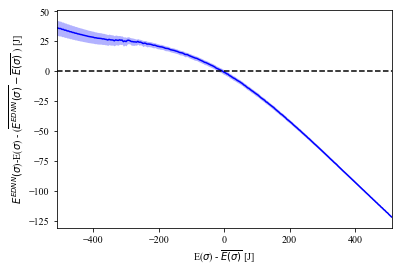

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\CRITEDNNISING1/model.ckpt
-512 -504 -500 -496 -492 -488 -484 -480 -476 -472 -468 -464 -460 -456 -452 -448 -444 -440 -436 -432 -428 -424 -420 -416 -412 -408 -404 -400 -396 -392 -388 -384 -380 -376 -372 -368 -364 -360 -356 -352 -348 -344 -340 -336 -332 -328 -324 -320 -316 -312 -308 -304 -300 -296 -292 -288 -284 -280 -276 -272 -268 -264 -260 -256 -252 -248 -244 -240 -236 -232 -228 -224 -220 -216 -212 -208 -204 -200 -196 -192 -188 -184 -180 -176 -172 -168 -164 -160 -156 -152 -148 -144 -140 -136 -132 -128 -124 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 124 128 132 136 140 144 148 152 156 160 164 168 172 176 180 184 188 192 196 200 204 208 212 216 220 224 228 232 236 240 244 248 252 256 260 264 268 272 276 280 284 288 292 296 300 304 308 312 316 320 324 328 

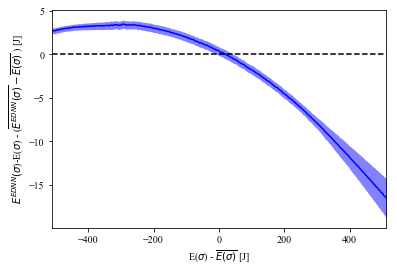

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\REDNNISING1/model.ckpt
-512 -504 -500 -496 -492 -488 -484 -480 -476 -472 -468 -464 -460 -456 -452 -448 -444 -440 -436 -432 -428 -424 -420 -416 -412 -408 -404 -400 -396 -392 -388 -384 -380 -376 -372 -368 -364 -360 -356 -352 -348 -344 -340 -336 -332 -328 -324 -320 -316 -312 -308 -304 -300 -296 -292 -288 -284 -280 -276 -272 -268 -264 -260 -256 -252 -248 -244 -240 -236 -232 -228 -224 -220 -216 -212 -208 -204 -200 -196 -192 -188 -184 -180 -176 -172 -168 -164 -160 -156 -152 -148 -144 -140 -136 -132 -128 -124 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 124 128 132 136 140 144 148 152 156 160 164 168 172 176 180 184 188 192 196 200 204 208 212 216 220 224 228 232 236 240 244 248 252 256 260 264 268 272 276 280 284 288 292 296 300 304 308 312 316 320 324 328 332

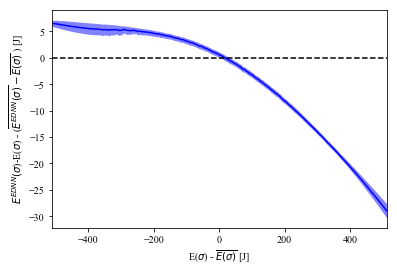

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\SEDNNISING1/model.ckpt
-512 -504 -500 -496 -492 -488 -484 -480 -476 -472 -468 -464 -460 -456 -452 -448 -444 -440 -436 -432 -428 -424 -420 -416 -412 -408 -404 -400 -396 -392 -388 -384 -380 -376 -372 -368 -364 -360 -356 -352 -348 -344 -340 -336 -332 -328 -324 -320 -316 -312 -308 -304 -300 -296 -292 -288 -284 -280 -276 -272 -268 -264 -260 -256 -252 -248 -244 -240 -236 -232 -228 -224 -220 -216 -212 -208 -204 -200 -196 -192 -188 -184 -180 -176 -172 -168 -164 -160 -156 -152 -148 -144 -140 -136 -132 -128 -124 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 124 128 132 136 140 144 148 152 156 160 164 168 172 176 180 184 188 192 196 200 204 208 212 216 220 224 228 232 236 240 244 248 252 256 260 264 268 272 276 280 284 288 292 296 300 304 308 312 316 320 324 328 332

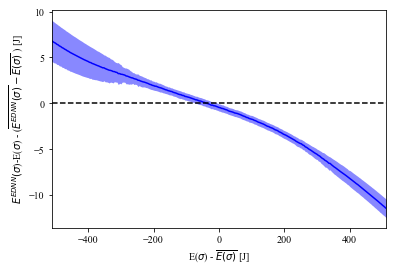

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\HEDNNISING1/model.ckpt
-512 -504 -500 -496 -492 -488 -484 -480 -476 -472 -468 -464 -460 -456 -452 -448 -444 -440 -436 -432 -428 -424 -420 -416 -412 -408 -404 -400 -396 -392 -388 -384 -380 -376 -372 -368 -364 -360 -356 -352 -348 -344 -340 -336 -332 -328 -324 -320 -316 -312 -308 -304 -300 -296 -292 -288 -284 -280 -276 -272 -268 -264 -260 -256 -252 -248 -244 -240 -236 -232 -228 -224 -220 -216 -212 -208 -204 -200 -196 -192 -188 -184 -180 -176 -172 -168 -164 -160 -156 -152 -148 -144 -140 -136 -132 -128 -124 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 124 128 132 136 140 144 148 152 156 160 164 168 172 176 180 184 188 192 196 200 204 208 212 216 220 224 228 232 236 240 244 248 252 256 260 264 268 272 276 280 284 288 292 296 300 304 308 312 316 320 324 328 332

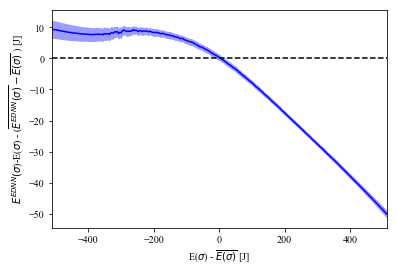

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\SHEDNNISING1/model.ckpt
-512 -504 -500 -496 -492 -488 -484 -480 -476 -472 -468 -464 -460 -456 -452 -448 -444 -440 -436 -432 -428 -424 -420 -416 -412 -408 -404 -400 -396 -392 -388 -384 -380 -376 -372 -368 -364 -360 -356 -352 -348 -344 -340 -336 -332 -328 -324 -320 -316 -312 -308 -304 -300 -296 -292 -288 -284 -280 -276 -272 -268 -264 -260 -256 -252 -248 -244 -240 -236 -232 -228 -224 -220 -216 -212 -208 -204 -200 -196 -192 -188 -184 -180 -176 -172 -168 -164 -160 -156 -152 -148 -144 -140 -136 -132 -128 -124 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 124 128 132 136 140 144 148 152 156 160 164 168 172 176 180 184 188 192 196 200 204 208 212 216 220 224 228 232 236 240 244 248 252 256 260 264 268 272 276 280 284 288 292 296 300 304 308 312 316 320 324 328 33

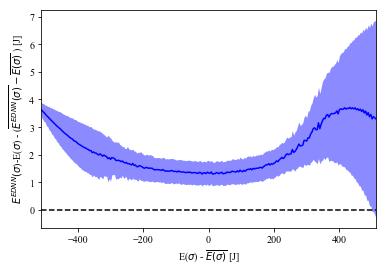

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\CORRCRITEDNNISING1/model.ckpt
-128 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 381.6354895901652


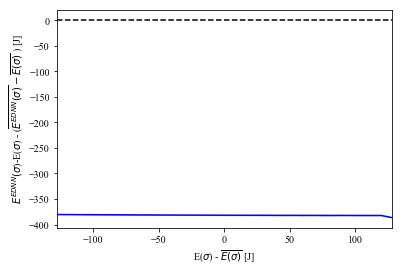

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\CRITEDNNISING1/model.ckpt
-128 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 381.6354895901652


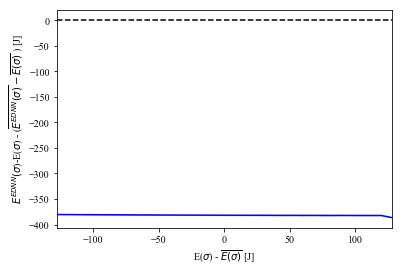

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\REDNNISING1/model.ckpt
-128 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 381.6354895901652


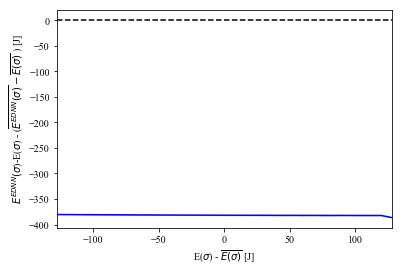

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\SEDNNISING1/model.ckpt
-128 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 381.6354895901652


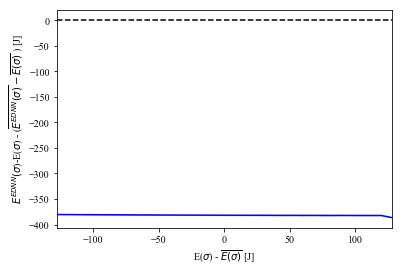

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\HEDNNISING1/model.ckpt
-128 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 381.6354895901652


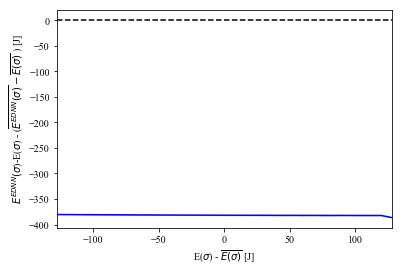

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\SHEDNNISING1/model.ckpt
-128 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 381.6354895901652


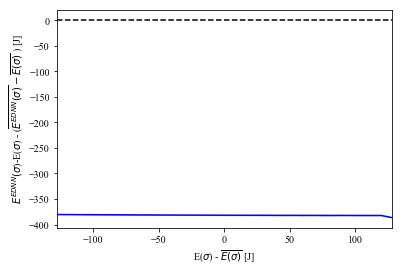

In [4]:
dirs=["D:\\2020\\LAPTOPRUNS\\CORRCRITEDNNISING1","D:\\2020\\LAPTOPRUNS\\CRITEDNNISING1",
     "D:\\2020\\LAPTOPRUNS\\REDNNISING1","D:\\2020\\LAPTOPRUNS\\SEDNNISING1",
     "D:\\2020\\LAPTOPRUNS\\HEDNNISING1","D:\\2020\\LAPTOPRUNS\\SHEDNNISING1"]

info4=[]
for d in dirs:
    #model.close()
    model=EDNN(d,N=4)
    info4+=[pred_bins(model.Hs,"All4.h5py",bins(4))]
    deltaplt(*bin_compare(bins(4),info4[-1]),"EDNN","b",points=False,delta=True)
    plt.show()
    model.close()
info16=[]
for d in dirs:
    model.close()
    model=EDNN(d,N=16)
    info16+=[pred_bins(model.Hs,"Uniform16.h5py",bins(16))]
    deltaplt(*bin_compare(bins(16),info16[-1]),"EDNN","b",points=False,delta=True)
    plt.show()
    model.close()
info8=[]
for d in dirs:
    model.close()
    model=EDNN(d,N=8)
    info8+=[pred_bins(model.Hs,"Uniform8.h5py",bins(8))]
    deltaplt(*bin_compare(bins(8),info8[-1]),"EDNN","b",points=False,delta=True)
    plt.show()
    model.close()

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\CORRCRITEDNNISING1/model.ckpt


D:\Ananconda\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


-128 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 12.48878925144471


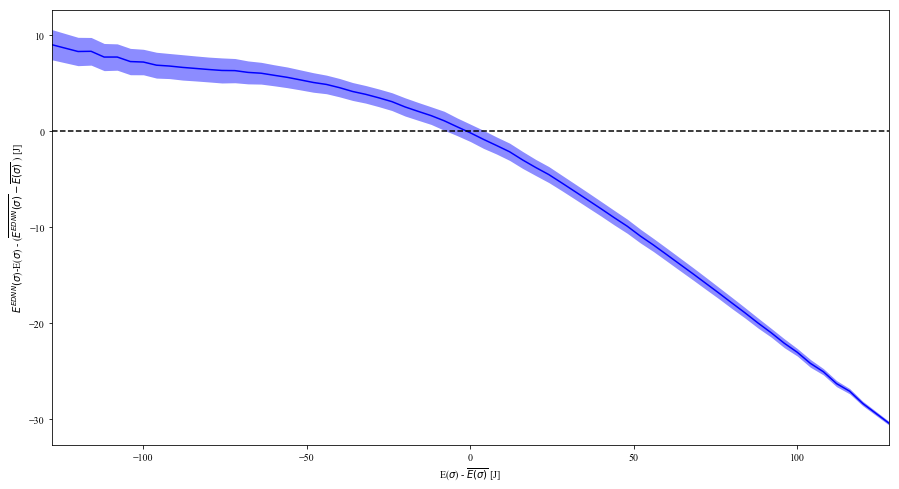

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\CRITEDNNISING1/model.ckpt
-128 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 1.5853018432648758


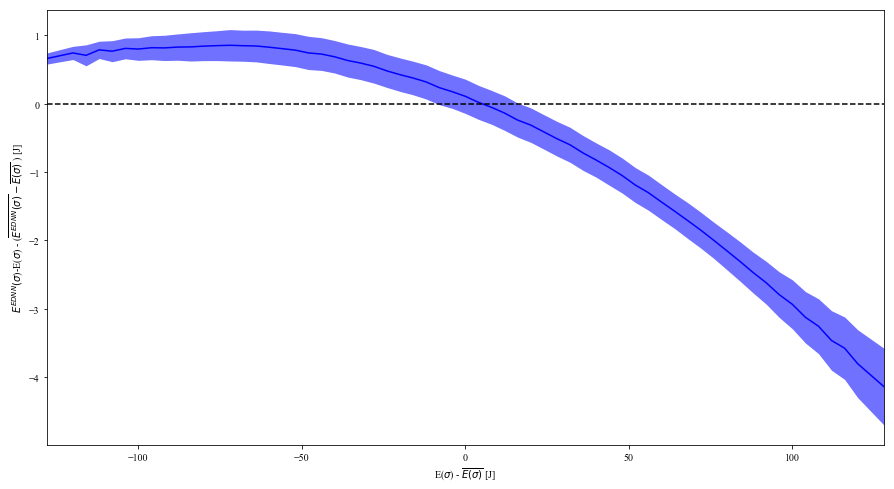

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\REDNNISING1/model.ckpt
-128 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 2.747396847025111


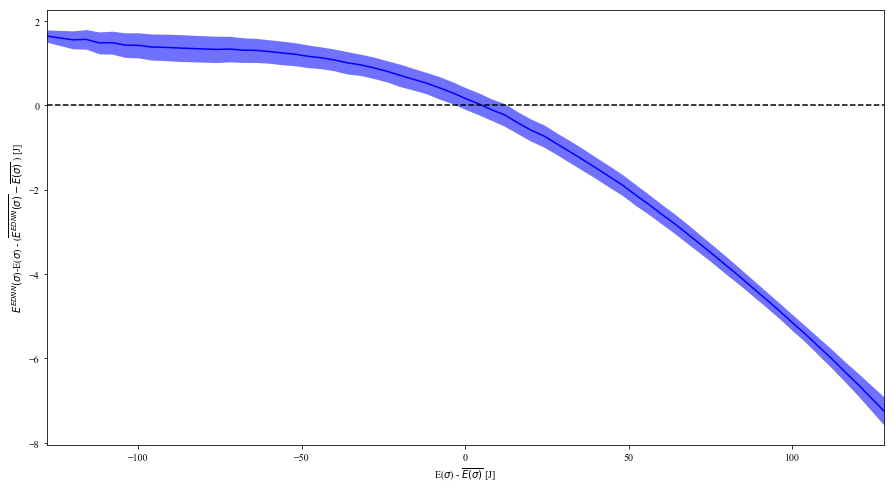

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\SEDNNISING1/model.ckpt
-128 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 1.2312271548166638


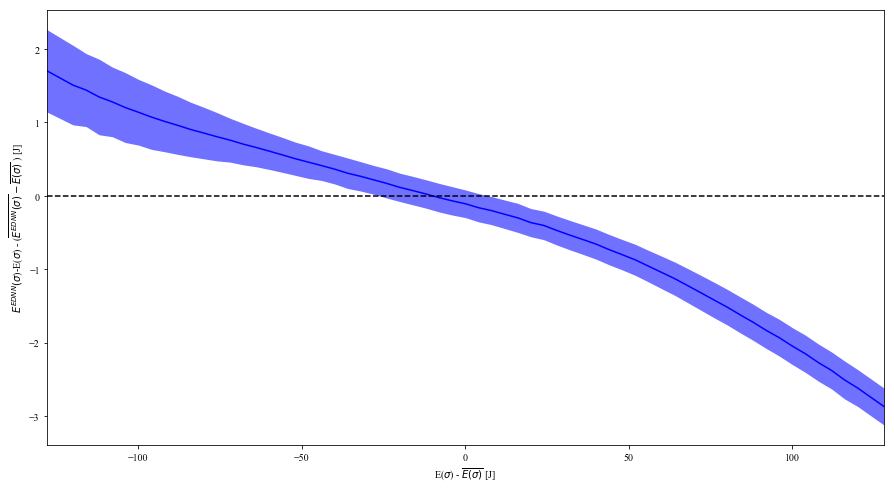

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\HEDNNISING1/model.ckpt
-128 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 5.045645366216096


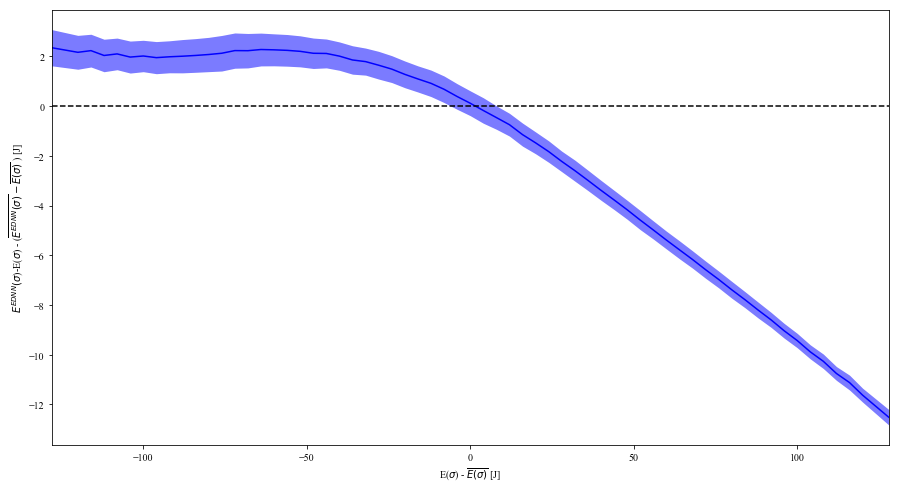

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\SHEDNNISING1/model.ckpt
-128 -120 -116 -112 -108 -104 -100 -96 -92 -88 -84 -80 -76 -72 -68 -64 -60 -56 -52 -48 -44 -40 -36 -32 -28 -24 -20 -16 -12 -8 -4 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 104 108 112 116 120 128 RMSE: 0.6512297396079054


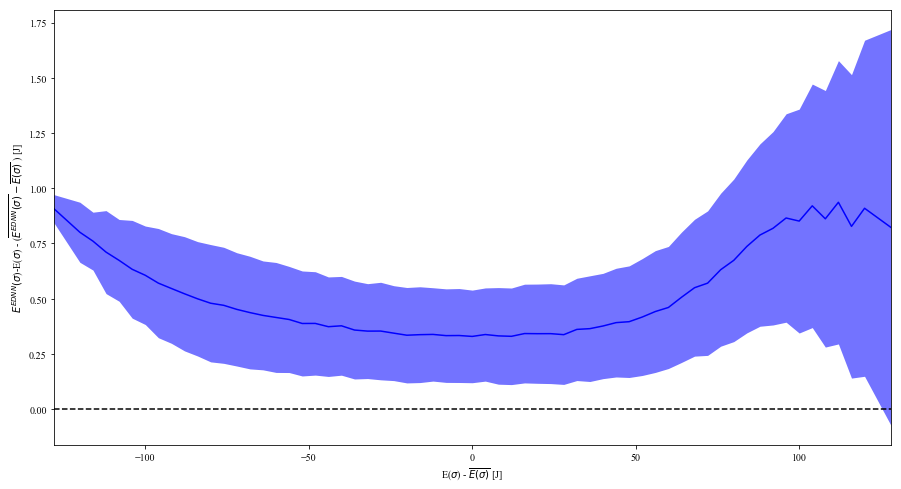

In [15]:
info8=[]
for d in dirs:
    model.close()
    model=EDNN(d,N=8)
    info8+=[pred_bins(model.Hs,"Uniform8.h5py",bins(8))]
    deltaplt(*bin_compare(bins(8),info8[-1]),"EDNN","b",points=False,delta=True)
    plt.show()
    model.close()

In [22]:
#with h5py.File("EDNNs.h5py","w") as f:
#    f.create_dataset("info8",data=info8)
#    f.create_dataset("info16",data=info16)
    ####f.create_dataset("info4",info4)


In [184]:
with h5py.File("Results.h5py","r") as f:
    hot=np.asarray(f["hot-corr"])
    mild=np.asarray(f["mild-corr"])
    crit=np.asarray(f["crit-decorr"])
    mild2=np.asarray(f["mild-decorr-2"])
    crit2=np.asarray(f["crit-corr"])
    hot2=np.asarray(f["hot-decorr"])
with h5py.File("EDNNs.h5py","r") as f:
    #ordering is CC, C, R, S, H, SH
    info8=np.asarray(f["info8"])
    info16=np.asarray(f["info16"])
names=["T=2.2691","T=2.2691 de-correlated","T=4","T=4 de-correlated","T=8","T=8 de-correlated"]

In [185]:
def squish(res):
    return [[a for b in res for a in b[i]] for i in range(len(res[0]))]
nhot=squish(hot)
nmild=squish(mild)
ncrit=squish(crit)
nmild2=squish(mild2)
ncrit2=squish(crit2)
nhot2=squish(hot2)
plt.rcParams['figure.figsize'] = [15, 8]

# RNN PERFORMANCE COMPARISON

RMSE: 4.471800719710457
RMSE: 17.619240692730372


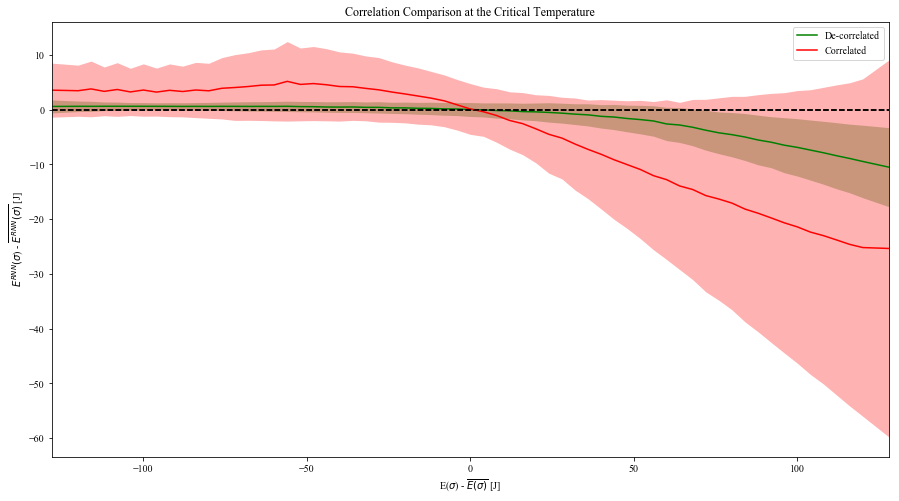

RMSE: 1.4306678097860723
RMSE: 5.693786805913293


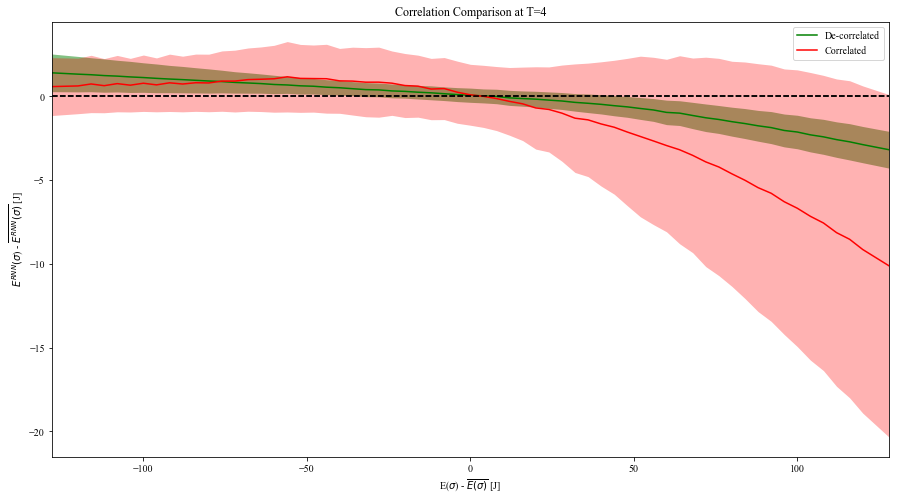

RMSE: 1.6727244943121202
RMSE: 8.813362731393374


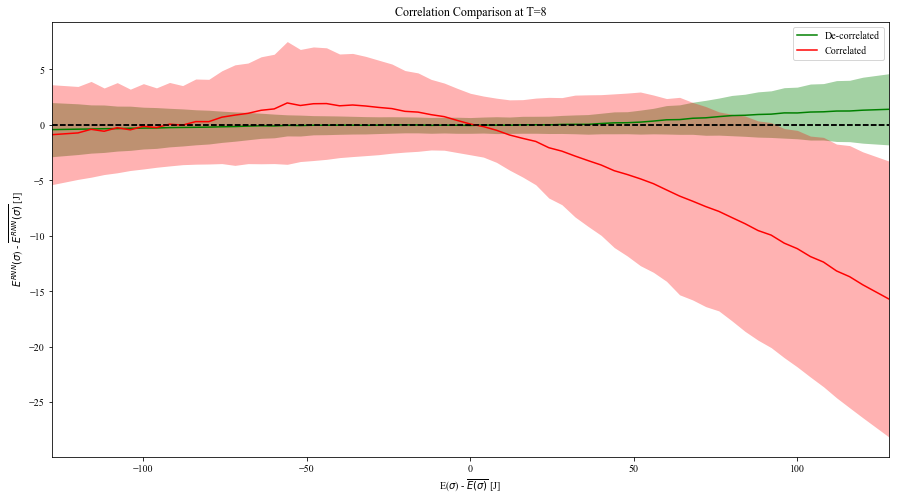

RMSE: 8.813362731393374
RMSE: 5.693786805913293
RMSE: 17.619240692730372


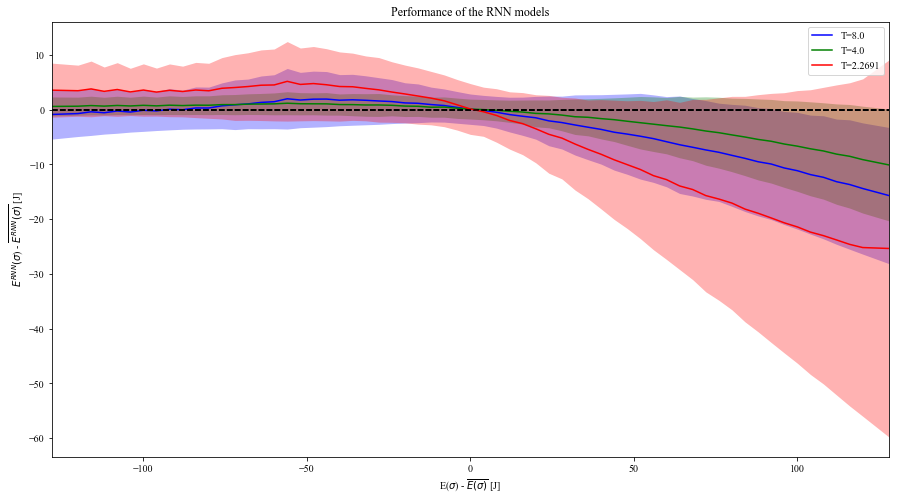

In [13]:
deltaplt(*bin_compare(bins(8),ncrit),"De-correlated","g",points=False,delta=True)
deltaplt(*bin_compare(bins(8),ncrit2),"Correlated","r",points=False,delta=True)
plt.ylabel(r"$E^{%s}(\sigma$) - $\overline{E^{%s}(\sigma)}$ [J]"%("RNN","RNN"))
plt.legend()
plt.title("Correlation Comparison at the Critical Temperature")
plt.show()


deltaplt(*bin_compare(bins(8),nmild2),"De-correlated","g",points=False,delta=True)
deltaplt(*bin_compare(bins(8),nmild),"Correlated","r",points=False,delta=True)
plt.ylabel(r"$E^{%s}(\sigma$) - $\overline{E^{%s}(\sigma)}$ [J]"%("RNN","RNN"))
plt.legend()
plt.title("Correlation Comparison at T=4")
plt.show()


deltaplt(*bin_compare(bins(8),nhot2),"De-correlated","g",points=False,delta=True)
deltaplt(*bin_compare(bins(8),nhot),"Correlated","r",points=False,delta=True)
plt.ylabel(r"$E^{%s}(\sigma$) - $\overline{E^{%s}(\sigma)}$ [J]"%("RNN","RNN"))
plt.legend()
plt.title("Correlation Comparison at T=8")
plt.show()


deltaplt(*bin_compare(bins(8),nhot),"T=8.0","b",points=False,delta=True)
deltaplt(*bin_compare(bins(8),nmild),"T=4.0","g",points=False,delta=True)
deltaplt(*bin_compare(bins(8),ncrit2),"T=2.2691","r",points=False,delta=True)
plt.title("Performance of the RNN models")

#plt.show()

plt.ylabel(r"$E^{%s}(\sigma$) - $\overline{E^{%s}(\sigma)}$ [J]"%("RNN","RNN"))
plt.legend()
plt.savefig("Compare.PDF")

# EDNN PERFORMANCE COMPARISON

RMSE: 12.48878925144471
RMSE: 1.5853018432648758
RMSE: 2.747396847025111
RMSE: 1.2312271548166638
RMSE: 5.045645366216096
RMSE: 0.6512297396079054


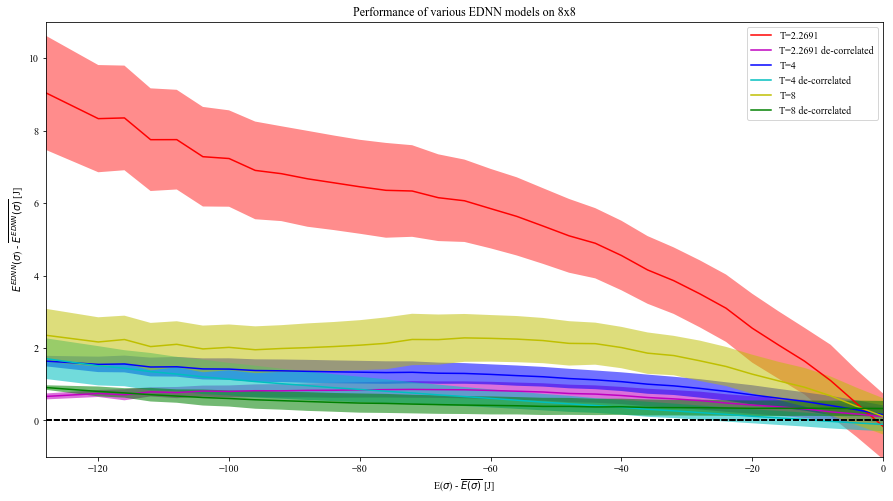

RMSE: 50.43321859866574
RMSE: 6.394467728250597
RMSE: 11.094351092469847
RMSE: 4.950164678158825
RMSE: 20.312398144253134
RMSE: 2.562529421436707


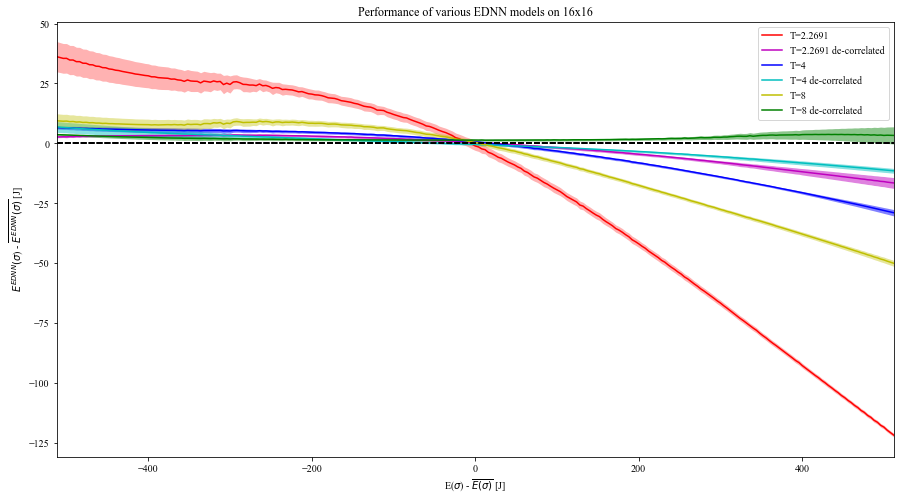

In [21]:

for a in range(len(info8)):
    deltaplt(*bin_compare(bins(8),info8[a]),names[a],"rmbcyg"[a],points=False,delta=True)
plt.legend()
plt.ylabel(r"$E^{%s}(\sigma$) - $\overline{E^{%s}(\sigma)}$ [J]"%("EDNN","EDNN"))
plt.title("Performance of various EDNN models on 8x8")
plt.xlim(-128,0)
plt.ylim(-1,11)
plt.show()

for a in range(len(info16)):
    deltaplt(*bin_compare(bins(16),info16[a]),names[a],"rmbcyg"[a],points=False,delta=True)
plt.legend()
plt.ylabel(r"$E^{%s}(\sigma$) - $\overline{E^{%s}(\sigma)}$ [J]"%("EDNN","EDNN"))
plt.title("Performance of various EDNN models on 16x16")
plt.show()


# RNNs WITH THEIR RESPECTIVE EDNN

RMSE: 17.619240692730372
RMSE: 12.48878925144471


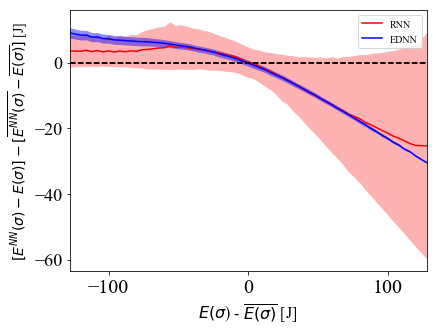

RMSE: 4.471800719710457
RMSE: 1.5853018432648758


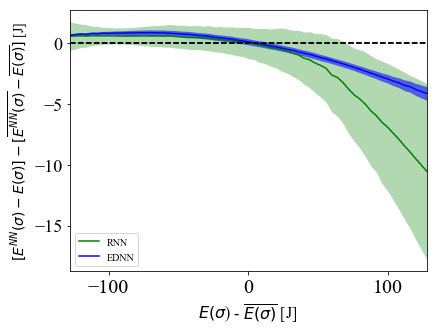

RMSE: 5.693786805913293
RMSE: 2.747396847025111


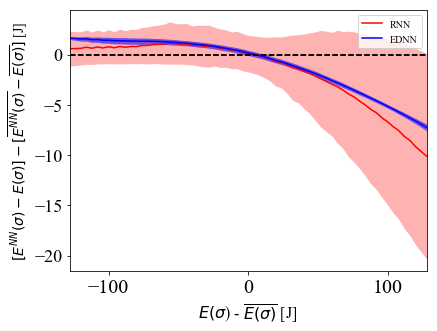

RMSE: 1.4306678097860723
RMSE: 1.2312271548166638


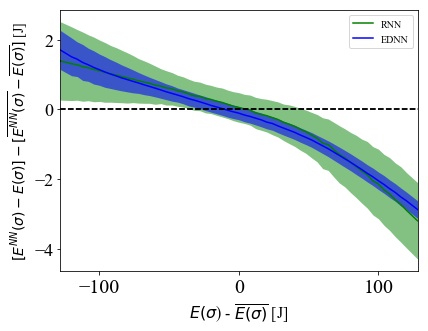

RMSE: 8.813362731393374
RMSE: 5.045645366216096


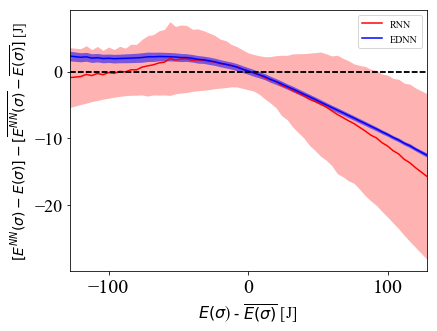

RMSE: 1.6727244943121202
RMSE: 0.6512297396079054


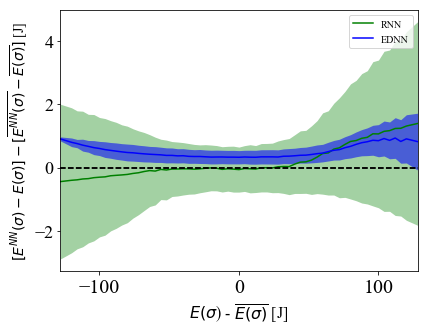

In [186]:
ordering=[ncrit2,ncrit,nmild,nmild2,nhot,nhot2]
plt.rcParams['figure.figsize'] = [6.4, 4.8]
for i in range(6):
    if i%2==0:
        deltaplt(*bin_compare(bins(8),ordering[i]),"RNN","r",points=False,delta=True)
        deltaplt(*bin_compare(bins(8),info8[i]),"EDNN","b",points=False,delta=True)
    else:
        deltaplt(*bin_compare(bins(8),ordering[i]),"RNN","g",points=False,delta=True)
        deltaplt(*bin_compare(bins(8),info8[i]),"EDNN","b",points=False,delta=True)
    plt.ylabel(r"$[E^{%s}(\sigma)-E(\sigma)] - [\overline{E^{%s}(\sigma)}-\overline{E(\sigma)}]$ [J]"%("NN","NN"),fontsize=14)
    plt.legend()
    #plt.title("Ednn and RNN Predicted Vs True (%s)"%names[i])
    plt.savefig(names[i]+".pdf",bbox_inches='tight')
    plt.show()



In [21]:
from Unrolled_RNN import URNN
res=[]
for txt in "ABCDEF":
    model=URNN("D:\\2020\\Export\\32SH"+txt,code="",flat="SPIRAL",model="ISING1",hidden_size=378,T=2.2691)

    res+=[model.entropy()]
    print(res[-1]/64)
    model.close()
print(st_dev(np.asarray(res)/64))

None
T=2.2691, N=8
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHAISING1/model.ckpt-189655
0.6763522720455855
None
T=2.2691, N=8
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHBISING1/model.ckpt-192000
0.6768001610286757
None
T=2.2691, N=8
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHCISING1/model.ckpt-188222
0.6773834192897819
None
T=2.2691, N=8
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHDISING1/model.ckpt-192000
0.6769676677488949
None
T=2.2691, N=8
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHEISING1/model.ckpt-192000
0.6769419478517595
None
T=2.2691, N=8
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SHFISING1/model.ckpt-192000
0.6767824142179081
(0.6768713136971009, 0.00030520361530985644, 0.458154868455286)


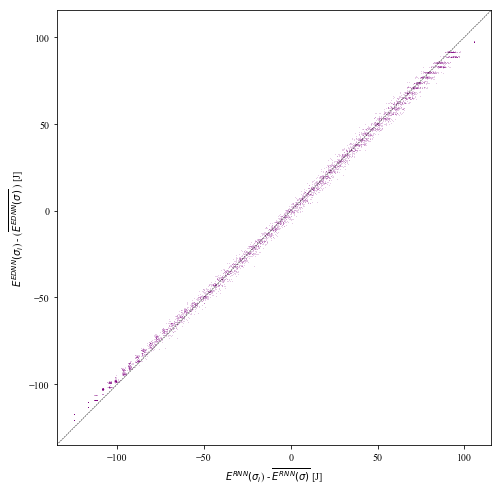

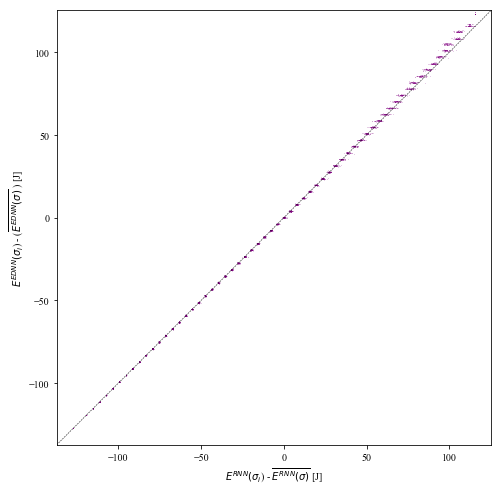

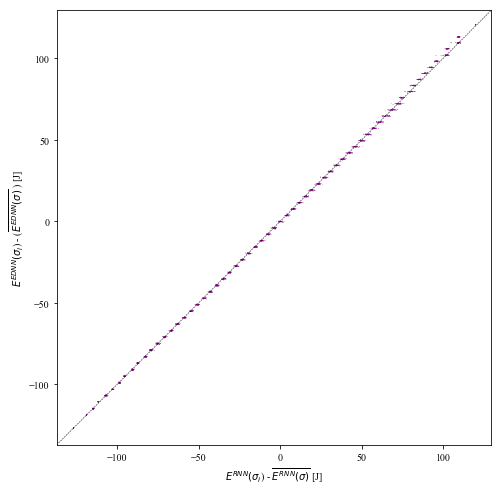

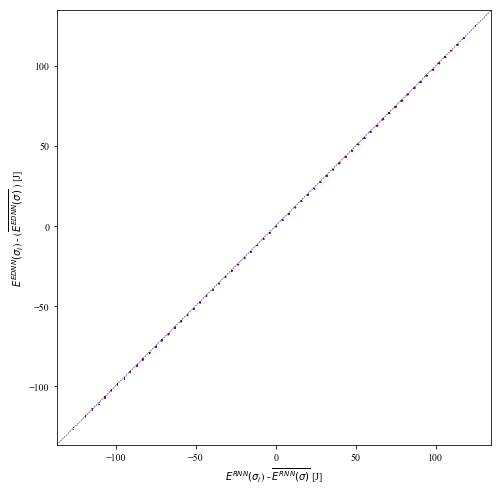

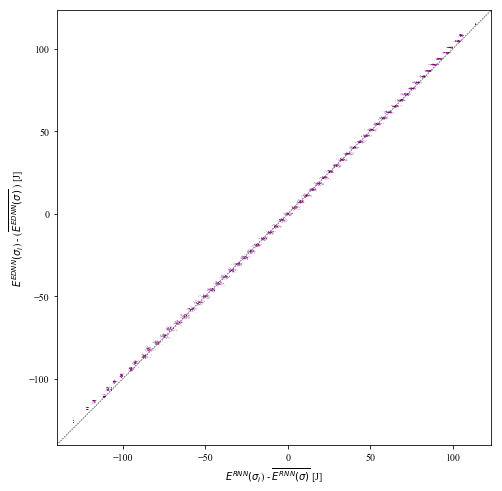

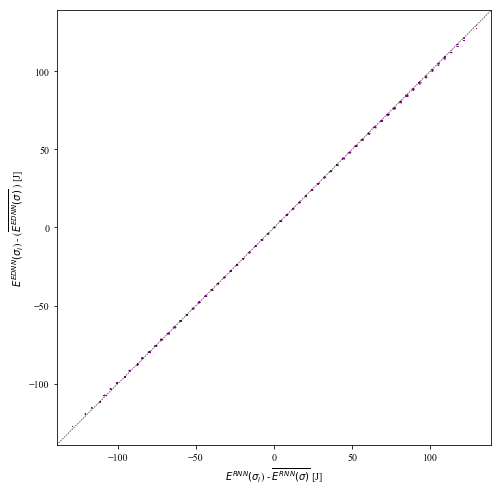

In [16]:
ordering=[crit2,crit,mild,mild2,hot,hot2]
ns=100

#plt.rcParams['figure.figsize'] = [6.4, 4.8]
for i in range(6):
    xi=ordering[i]
    x_=[[sum([xi[k][a][b] for k in range(6)])/6 for b in range(len(xi[0][0]))] for a in range(len(xi[0]))]
    deltaplt([ a for b in x_ for a in b][::ns],[a for b in info8[i] for a in b][::ns],0,"RNN v EDNN","purple",points=True,delta=False)
    #plt.legend()
    plt.ylabel(r"$E^{EDNN}(\sigma_i$) - ($\overline{E^{EDNN}(\sigma)}$ ) [J]")
    plt.xlabel(r"$E^{RNN}(\sigma_i$) - $\overline{E^{RNN}(\sigma)}$ [J]")
    #plt.savefig("C:/Users/sprag/Dropbox/2019-RNN/figures/%s_linear_EDNN_RNN.pdf"%s)
    plt.show()




In [89]:
from Unrolled_RNN import URNN
res=[]
res_alt=[]
res2=[]
res3=[]
res4=[]
model.close()
for txt in "ABC":
    model=URNN("D:\\2020\\Export\\32SP16"+txt,code="",flat="SPIRAL",model="ISING1",hidden_size=378,T=2.2691,N=16)    
    l, E, p = model.generate_data(width=10000, seed=None)
    res+=[sum(np.asarray([H(a) for a in l])-E)/10000]
    res2+=[model.entropy(seed=None)]
    res3+=[(sum(E)/10000+res[-1])]
    res4+=[sum([abs(np.sum(a)) for a in l])/10000]
    
    model.close()
    model=EDNN("D:\\2020\\LAPTOPRUNS\\CRITEDNNISING1",N=16)
    c=(-512-(model.H(np.ones([16,16]))+model.H(np.ones([16,16])*-1))/2)
    res_alt+=[sum(model.Hs(l)-E)/10000+c]
    
    print(res[-1]/256)
    print(res2[-1]/256)
    print(sum([abs(np.sum(a))/256 for a in l])/10000)
    print((sum(E)/10000+res[-1])/256)
    model.close()
    
print(st_dev(np.asarray(res)/256))
print(st_dev(np.asarray(res_alt)/256))
print(st_dev(np.asarray(res2)/16**2))
print(st_dev(np.asarray(res3)/16**2))
print(st_dev(np.asarray(res4)/16**2))

None
T=2.2691, N=16
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SP16AISING1/model.ckpt-828588
INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\CRITEDNNISING1/model.ckpt


D:\Ananconda\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


-2.017540485226927
0.3450149322246765
0.67033515625
-1.2341578124999986
None
T=2.2691, N=16
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SP16BISING1/model.ckpt-639106
INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\CRITEDNNISING1/model.ckpt
-2.112006925007399
0.29949220551715844
0.68782421875
-1.433881249999995
None
T=2.2691, N=16
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SP16CISING1/model.ckpt-779233
INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\CRITEDNNISING1/model.ckpt
-2.0887954073820536
0.31810474590520516
0.67655390625
-1.3691187500000082
(-2.07278093920546, 0.040193900486133, 4.298036371569758)
(-2.0709975743030236, 0.03958539554207422, 4.29059795630923)
(0.3208706278823467, 0.018687201307409158, 0.10330717133031504)
(-1.345719270833334, 0.08319861613695849, 1.8178823656193048)
(0.6782377604166667, 0.0072384782205091236, 0.4600588552219645)


In [80]:
model.close()

In [81]:
model=EDNN("D:\\2020\\LAPTOPRUNS\\CRITEDNNISING1",N=16)

INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\CRITEDNNISING1/model.ckpt


D:\Ananconda\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [3]:
from Unrolled_RNN import URNN

W=10000

res=[]
res_alt=[]
res2=[]
res3=[]
res4=[]
#model.close()
for txt in "ABC":
    model=URNN("D:\\2020\\Export\\32SP24"+txt,code="",flat="SPIRAL",model="ISING1",hidden_size=378,T=2.2691,N=24,device="/cpu:0")    
    l, E, p, preds = model.generate_data(width=W, seed=None,show_pred=True)
    res+=[sum(np.asarray([H(a) for a in l])-E)/W]
    res2+=[model.entropy(seed=None,width=W)]
    res3+=[(sum(E)/W+res[-1])]
    res4+=[sum([abs(np.sum(a)) for a in l])/W]
    
    print(res[-1]/24**2)
    print(res2[-1]/24**2)
    
    model.close()
    model=EDNN("D:\\2020\\LAPTOPRUNS\\CRITEDNNISING1",N=24)
    c=(-24**2*2-(model.H(np.ones([24,24]))+model.H(np.ones([24,24])*-1))/2)
    res_alt+=[sum(model.Hs(l)-E)/W+c]
    
    
    print(sum([abs(np.sum(a))/24**2 for a in l])/W)
    print((sum(E)/W+res[-1])/24**2)
    model.close()
    
print(st_dev(np.asarray(res)/24**2))
print(st_dev(np.asarray(res_alt)/24**2))
print(st_dev(np.asarray(res2)/24**2))
print(st_dev(np.asarray(res3)/24**2))
print(st_dev(np.asarray(res4)/24**2))

None
T=2.2691, N=24
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SP24AISING1/model.ckpt-765172
-2.069198085118034
0.32792701087000686
INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\CRITEDNNISING1/model.ckpt
0.6176680555555559
-1.3226409722222143
None
T=2.2691, N=24
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SP24BISING1/model.ckpt-762355
-2.069403834853221
0.3396881927052399
INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\CRITEDNNISING1/model.ckpt


D:\Ananconda\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


0.4856187499999998
-1.2988152777777675
None
T=2.2691, N=24
INFO:tensorflow:Restoring parameters from D:\2020\Export\32SP24CISING1/model.ckpt-778639
-2.0889171118429117
0.3170608064153122
INFO:tensorflow:Restoring parameters from D:\2020\LAPTOPRUNS\CRITEDNNISING1/model.ckpt
0.6250572916666669
-1.369552777777771
(-2.075839677271389, 0.00924752415398221, 4.309195882437162)
(-2.0736204274100603, 0.008690978454144953, 4.299977210078771)
(0.32822533666351966, 0.00924000004645413, 0.1078172492287393)
(-1.3303363425925843, 0.029386646858910796, 1.770658359436224)
(0.5761146990740741, 0.06406136538085695, 0.33601200502367057)


In [5]:
print(st_dev(np.asarray(res_alt)/24**2-2+(512/24**2)))

(-2.07365847427101, 0.008614812415938105, 4.300133682908936)
